# Bayesian Analysis of ARPAV time series on temperatures 

a project by Erica Brisigotti (2097202) developed in context of the course of **Advanced Statistics for Physics Analysis** held at the University of Padova by Prof. Alberto Garfagnini during Academic Year 2022-2023

-----

ARPAV (Agenzia Regionale per la Prevenzione e Protezione Ambientale del Veneto) is an agency widespread over the territory that collects and analyzes environmental data. Some of the measurement points are quite old and ve a very long time serie (for example in Cavanis, Venice, daily measurements are available since 1900).

The aim of the project is to analyze the data available in three stations from 1993 to 2021, where the environment is quite different, and study the evolution over time. The stations are located in:

<img src="locations_details.png" alt="locations details" width="600">

As shown in the image below, three out of four of the locations (in blue) fall within the Po Valley, while Auronzo di Cadorle (in purple) falls into the alpine region. The difference in climate that comes from this will be taken into account later into the analysis:

<img title="map of the locations" alt="Alt text" src="map.png">


-----

I start my analysis by loading the R packages that I will need and also loading the datasets, which are in CSV format.

In [1]:
library('tidyverse')
library('rjags')
library('forecast')
library('egg') # needed for multiple subplots with ggplot
library('coda')
options(warn=-1)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
FIRST_RUN = FALSE

In [3]:
# if it's the first time I run the code in a path, I run the following code
if (FIRST_RUN){
    # I put together the files relative to Auronzo di Cadore, since they are split into two different CSV files
    file_names_to_merge = c("8_AURONZO_TMINMAX.csv", 
                            "53_Auronzo_Temperatura aria a 2m.csv")
    # I initialize the dataframe in which I'm going to merge the previous files
    df_merged = data.frame()
    # for every dataset to merge
    for (fn in 1:length(file_names_to_merge)) {
        # I upload data automatically
        temp = read.table( file_names_to_merge[fn], header=TRUE, sep=",", dec=".")
        # I then assign a proper name to the columns
        colnames(temp) <- c("date", "minimum_temperature", "average_temperature", "maximum_temperature")  
        # and add the above dataframe to the final dataframe 
        df_merged <- df_merged %>% rbind(temp) }
    # and save the result as a CSV file with a new name, to be reuploaded later
    write.csv(df_merged, file='Auronzo_temperatura.csv', quote=FALSE, row.names=FALSE) }

In [4]:
# if it's the first time I run the code in a path, I run the following code
# now that I have one CSV file per location, I initialize the names of the files I need to upload
file_names=c("101_Porto Tolle - Pradon_Temperatura aria a 2m.csv",
             "119_Roverchiara_Temperatura aria a 2m.csv",
             "34_CASTELFRANCO VENETO_TMINMAX.csv",
             "Auronzo_temperatura.csv")
location_names=c("Porto_Tolle",
                "Roverchiara",
                "Castelfranco_Veneto",
            "Auronzo_di_Cadore")
# for each file name to be loaded
for (fn in 1:length(file_names)) {
    # I upload data automatically
    temp = read.table( file_names[fn], header=TRUE, sep=",", dec=".")
    # I then assign a proper name to its columns
    colnames(temp) <- c("date", "minimum_temperature", "average_temperature", "maximum_temperature") 
    # and extract information from the date, such as the year and month
    temp$month <- as.double(format(as.Date(temp$date, format="%Y-%m-%d"),"%m"))
    temp$year <- as.double(format(as.Date(temp$date, format="%Y-%m-%d"),"%Y"))
    # we will also need a quadrennial and decade indicator, since we want to avoid having too many points
    temp$quadrennium <- as.factor(paste(as.character((round(temp$year/4, digits=0)*4-2)),
                                             as.character((round(temp$year/4, digits=0)*4+2)),sep="-"))
    temp$decade <- as.factor(paste(as.character((round(temp$year/10, digits=0)*10-5)),
                                              as.character((round(temp$year/10, digits=0)*10+5)),sep="-"))
    # and name them based on their location
    assign( location_names[fn], temp) } 

-------

## Part 0: monthly temperatures
Study the evolution over time of the minimum, maximum and average temperatures computed over one month.

In [5]:
for (ln in 1:length(location_names)){
    get(location_names[ln]) %>% 
        group_by(quadrennium, month) %>% 
            summarise(minimum_temperature_std = sd(minimum_temperature)/sqrt(n()),
                      minimum_temperature = min(minimum_temperature),
                      average_temperature_std = sd(average_temperature)/sqrt(n()),
                      average_temperature = mean(average_temperature), 
                      maximum_temperature_std = sd(maximum_temperature)/sqrt(n()),
                      maximum_temperature = max(maximum_temperature) ) -> temp
    assign(paste(location_names[ln],'_monthly_quadrennium', sep=''), temp) }

`summarise()` has grouped output by 'quadrennium'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'quadrennium'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'quadrennium'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'quadrennium'. You can override using the `.groups` argument.


In [6]:
options(repr.plot.width=18, repr.plot.height=20)

all_names = c()
for (ln in 1:length(location_names)){
    
    df = get(paste(location_names[ln],'monthly_quadrennium',sep='_'))
    basic_plot_temp <- ggplot(df, aes(x=quadrennium, color=as.factor(month)))

    minimum_plot_temp <- basic_plot_temp +
                         geom_point(aes(y=minimum_temperature)) +
                         geom_path(aes(y=minimum_temperature, group=as.factor(month))) +
                         geom_errorbar(aes(ymin=minimum_temperature-minimum_temperature_std, 
                                       ymax=minimum_temperature+minimum_temperature_std), width=.2) +
                         ggtitle(location_names[ln]) +
                         theme(legend.position = "none", axis.text.x = element_text(size=8, angle=45))
    minimum_name <- paste(location_names[ln],'minimum_plot',sep='_')
    assign(minimum_name, minimum_plot_temp)

    average_plot_temp <- basic_plot_temp + 
                         geom_point(aes(y=average_temperature)) +
                         geom_path(aes(y=average_temperature, group=as.factor(month))) +
                         geom_errorbar(aes(ymin=average_temperature-average_temperature_std, 
                                       ymax=average_temperature+average_temperature_std), width=.2) +
                         theme(legend.position = "none", axis.text.x = element_text(size=8, angle=45))
    average_name <- paste(location_names[ln],'average_plot',sep='_')
    assign(average_name, average_plot_temp)

    maximum_plot_temp <- basic_plot_temp + 
                         geom_point(aes(y=maximum_temperature)) +
                         geom_path(aes(y=maximum_temperature, group=as.factor(month))) +
                         geom_errorbar(aes(ymin=maximum_temperature-maximum_temperature_std, 
                                      ymax=maximum_temperature+maximum_temperature_std), width=.2) +
                         theme(axis.text.x = element_text(size=8, angle=45)) +
                         guides(fill=guide_legend(title="month"))
    maximum_name <- paste(location_names[ln],'maximum_plot',sep='_')
    assign(maximum_name, maximum_plot_temp)

    all_names <- c(all_names, minimum_name, average_name, maximum_name) }

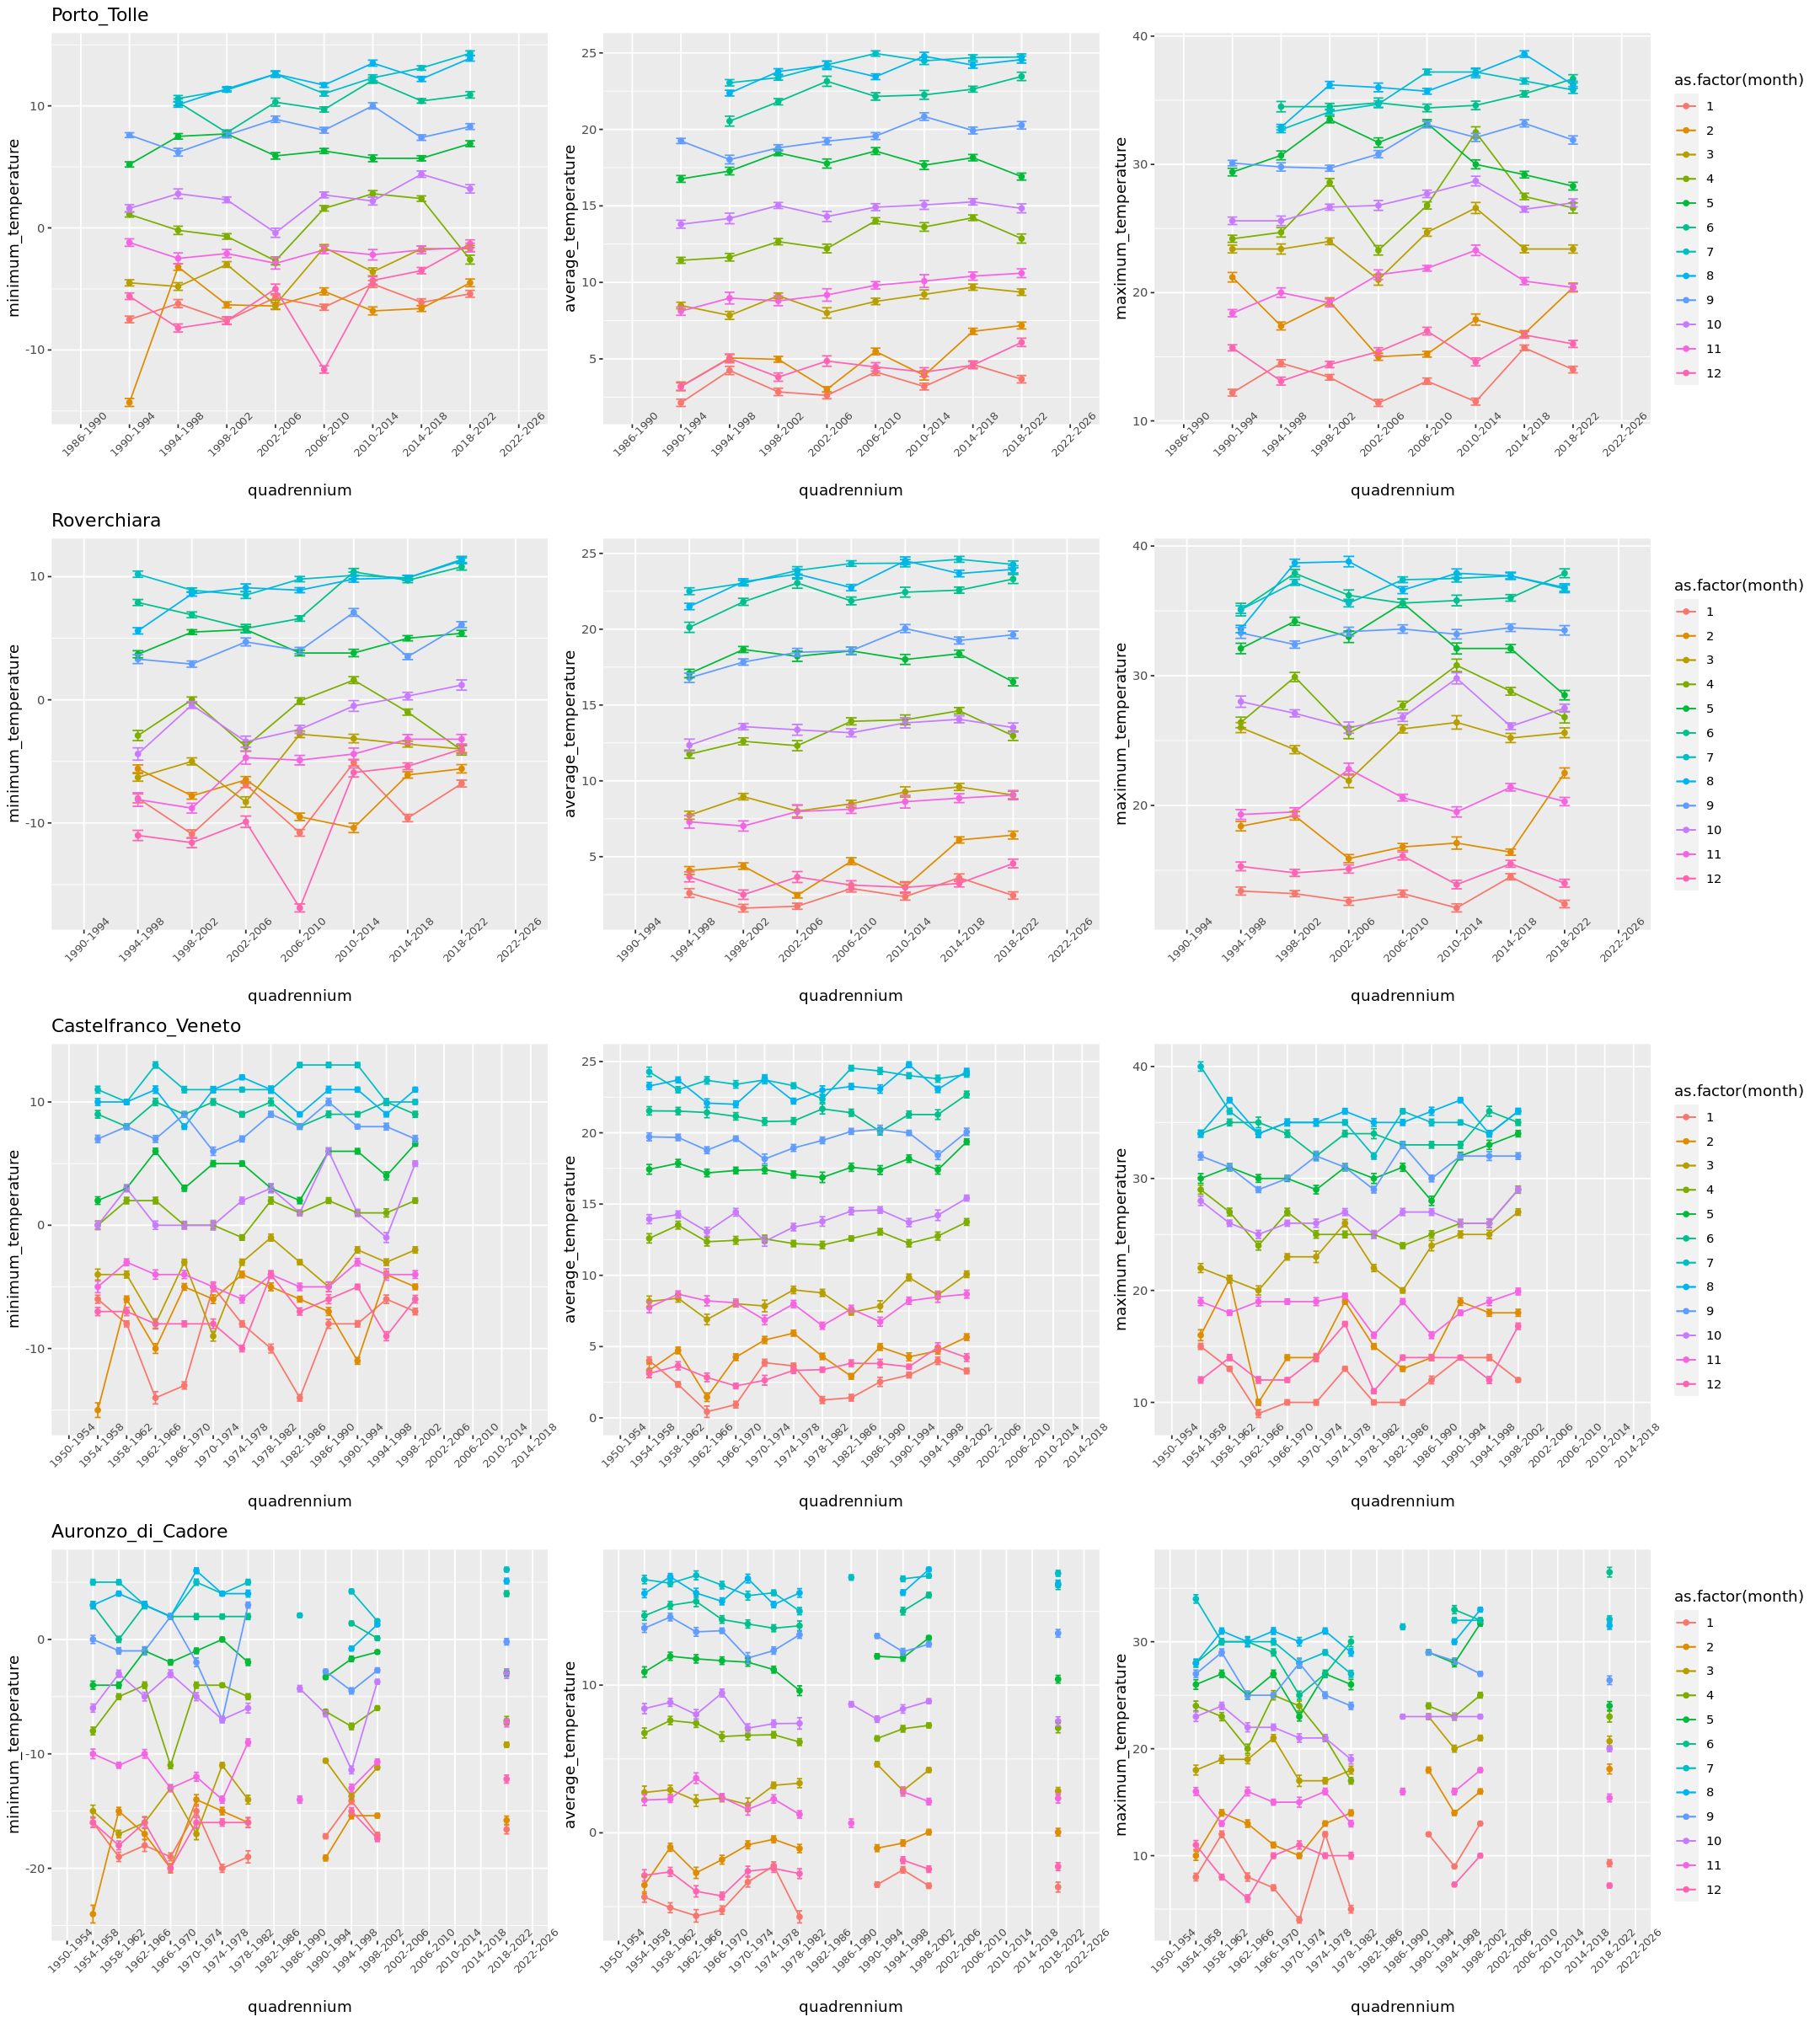

In [7]:
figure <- ggarrange(Porto_Tolle_minimum_plot, Porto_Tolle_average_plot, Porto_Tolle_maximum_plot,
                    Roverchiara_minimum_plot, Roverchiara_average_plot, Roverchiara_maximum_plot,
                    Castelfranco_Veneto_minimum_plot, Castelfranco_Veneto_average_plot, Castelfranco_Veneto_maximum_plot,
                    Auronzo_di_Cadore_minimum_plot, Auronzo_di_Cadore_average_plot, Auronzo_di_Cadore_maximum_plot,
                    ncol = 3, nrow = 4)

In the plots above, each row represents the monthly minimum, average and maximum temperatures over the years: data was split into quadriennium to reduce noise and grouped by month. 
    
Despite grouping data into quadrennums, the plots are still noisy and the multiple lines, corresponding to the months, don't help either, so in the next sections I will focus on annual trends to improve readability of the plots.
    
But, before moving further into the analysis, I observe that there is general rising trend over the years, for all 3 temperatures and all months, which is most visible in Porto Tolle.

------

## Part 1: annual temperatures

Analysise the evolution of the annual average of the minimum, maximum and daily average temperature over time (1993 - 2021):
- study the trend of the annual averages and compare them with a constant value or a rising trend (for instance linear or quadratic)
- perform an analysis using a Bayesian linear regression with JAGS or STAN
- perform the same analysis using a constant regression
- perform a Bayesian hypothesis test comparing the two results
- do you see correlations between data measured at different stations?

In [8]:
# for each location
df_yearly <- data.frame()
for (ln in 1:length(location_names)){
    # I filter the dataframe
    get(location_names[ln]) %>% 
        # based on the quadrennium and month (since I still want to keep information about all months)
        group_by(year) %>% 
        # and retrieve the pieces of information that I need
        summarise(minimum_temperature_std = sd(minimum_temperature)/sqrt(n()),
                  minimum_temperature = min(minimum_temperature),
                  average_temperature_std = sd(average_temperature)/sqrt(n()),
                  average_temperature = mean(average_temperature), 
                  maximum_temperature_std = sd(maximum_temperature)/sqrt(n()),
                  maximum_temperature = max(maximum_temperature) ) -> temp
    temp["location"] <- as.factor(rep(c(location_names[ln]), nrow(temp) )) 
    # and save the result under a new name
    assign(paste(location_names[ln],'_yearly', sep=''), temp) }

In [9]:
options(repr.plot.width=18, repr.plot.height=20)

all_names = c()
for (ln in 1:length(location_names)){
    
    df = get(paste(location_names[ln],'yearly',sep='_'))
    basic_plot_temp <- ggplot(df, aes(x=year))

    minimum_plot_temp <- basic_plot_temp +
                         geom_point(aes(y=minimum_temperature)) +
                         geom_path(aes(y=minimum_temperature, group=1)) +
                         geom_errorbar(aes(ymin=minimum_temperature-minimum_temperature_std, 
                                       ymax=minimum_temperature+minimum_temperature_std), width=.2) +
                         ggtitle(location_names[ln]) +
                         theme(legend.position = "none", axis.text.x = element_text(size=8, angle=45))
    minimum_name <- paste(location_names[ln],'minimum_plot',sep='_')
    assign(minimum_name, minimum_plot_temp)

    average_plot_temp <- basic_plot_temp + 
                         geom_point(aes(y=average_temperature)) +
                         geom_path(aes(y=average_temperature, group=1)) +
                         geom_errorbar(aes(ymin=average_temperature-average_temperature_std, 
                                       ymax=average_temperature+average_temperature_std), width=.2) +
                         theme(legend.position = "none", axis.text.x = element_text(size=8, angle=45))
    average_name <- paste(location_names[ln],'average_plot',sep='_')
    assign(average_name, average_plot_temp)

    maximum_plot_temp <- basic_plot_temp + 
                         geom_point(aes(y=maximum_temperature)) +
                         geom_path(aes(y=maximum_temperature, group=1)) +
                         geom_errorbar(aes(ymin=maximum_temperature-maximum_temperature_std, 
                                      ymax=maximum_temperature+maximum_temperature_std), width=.2) +
                         theme(axis.text.x = element_text(size=8, angle=45)) +
                         guides(fill=guide_legend(title="month"))
    maximum_name <- paste(location_names[ln],'maximum_plot',sep='_')
    assign(maximum_name, maximum_plot_temp)

    all_names <- c(all_names, minimum_name, average_name, maximum_name) }

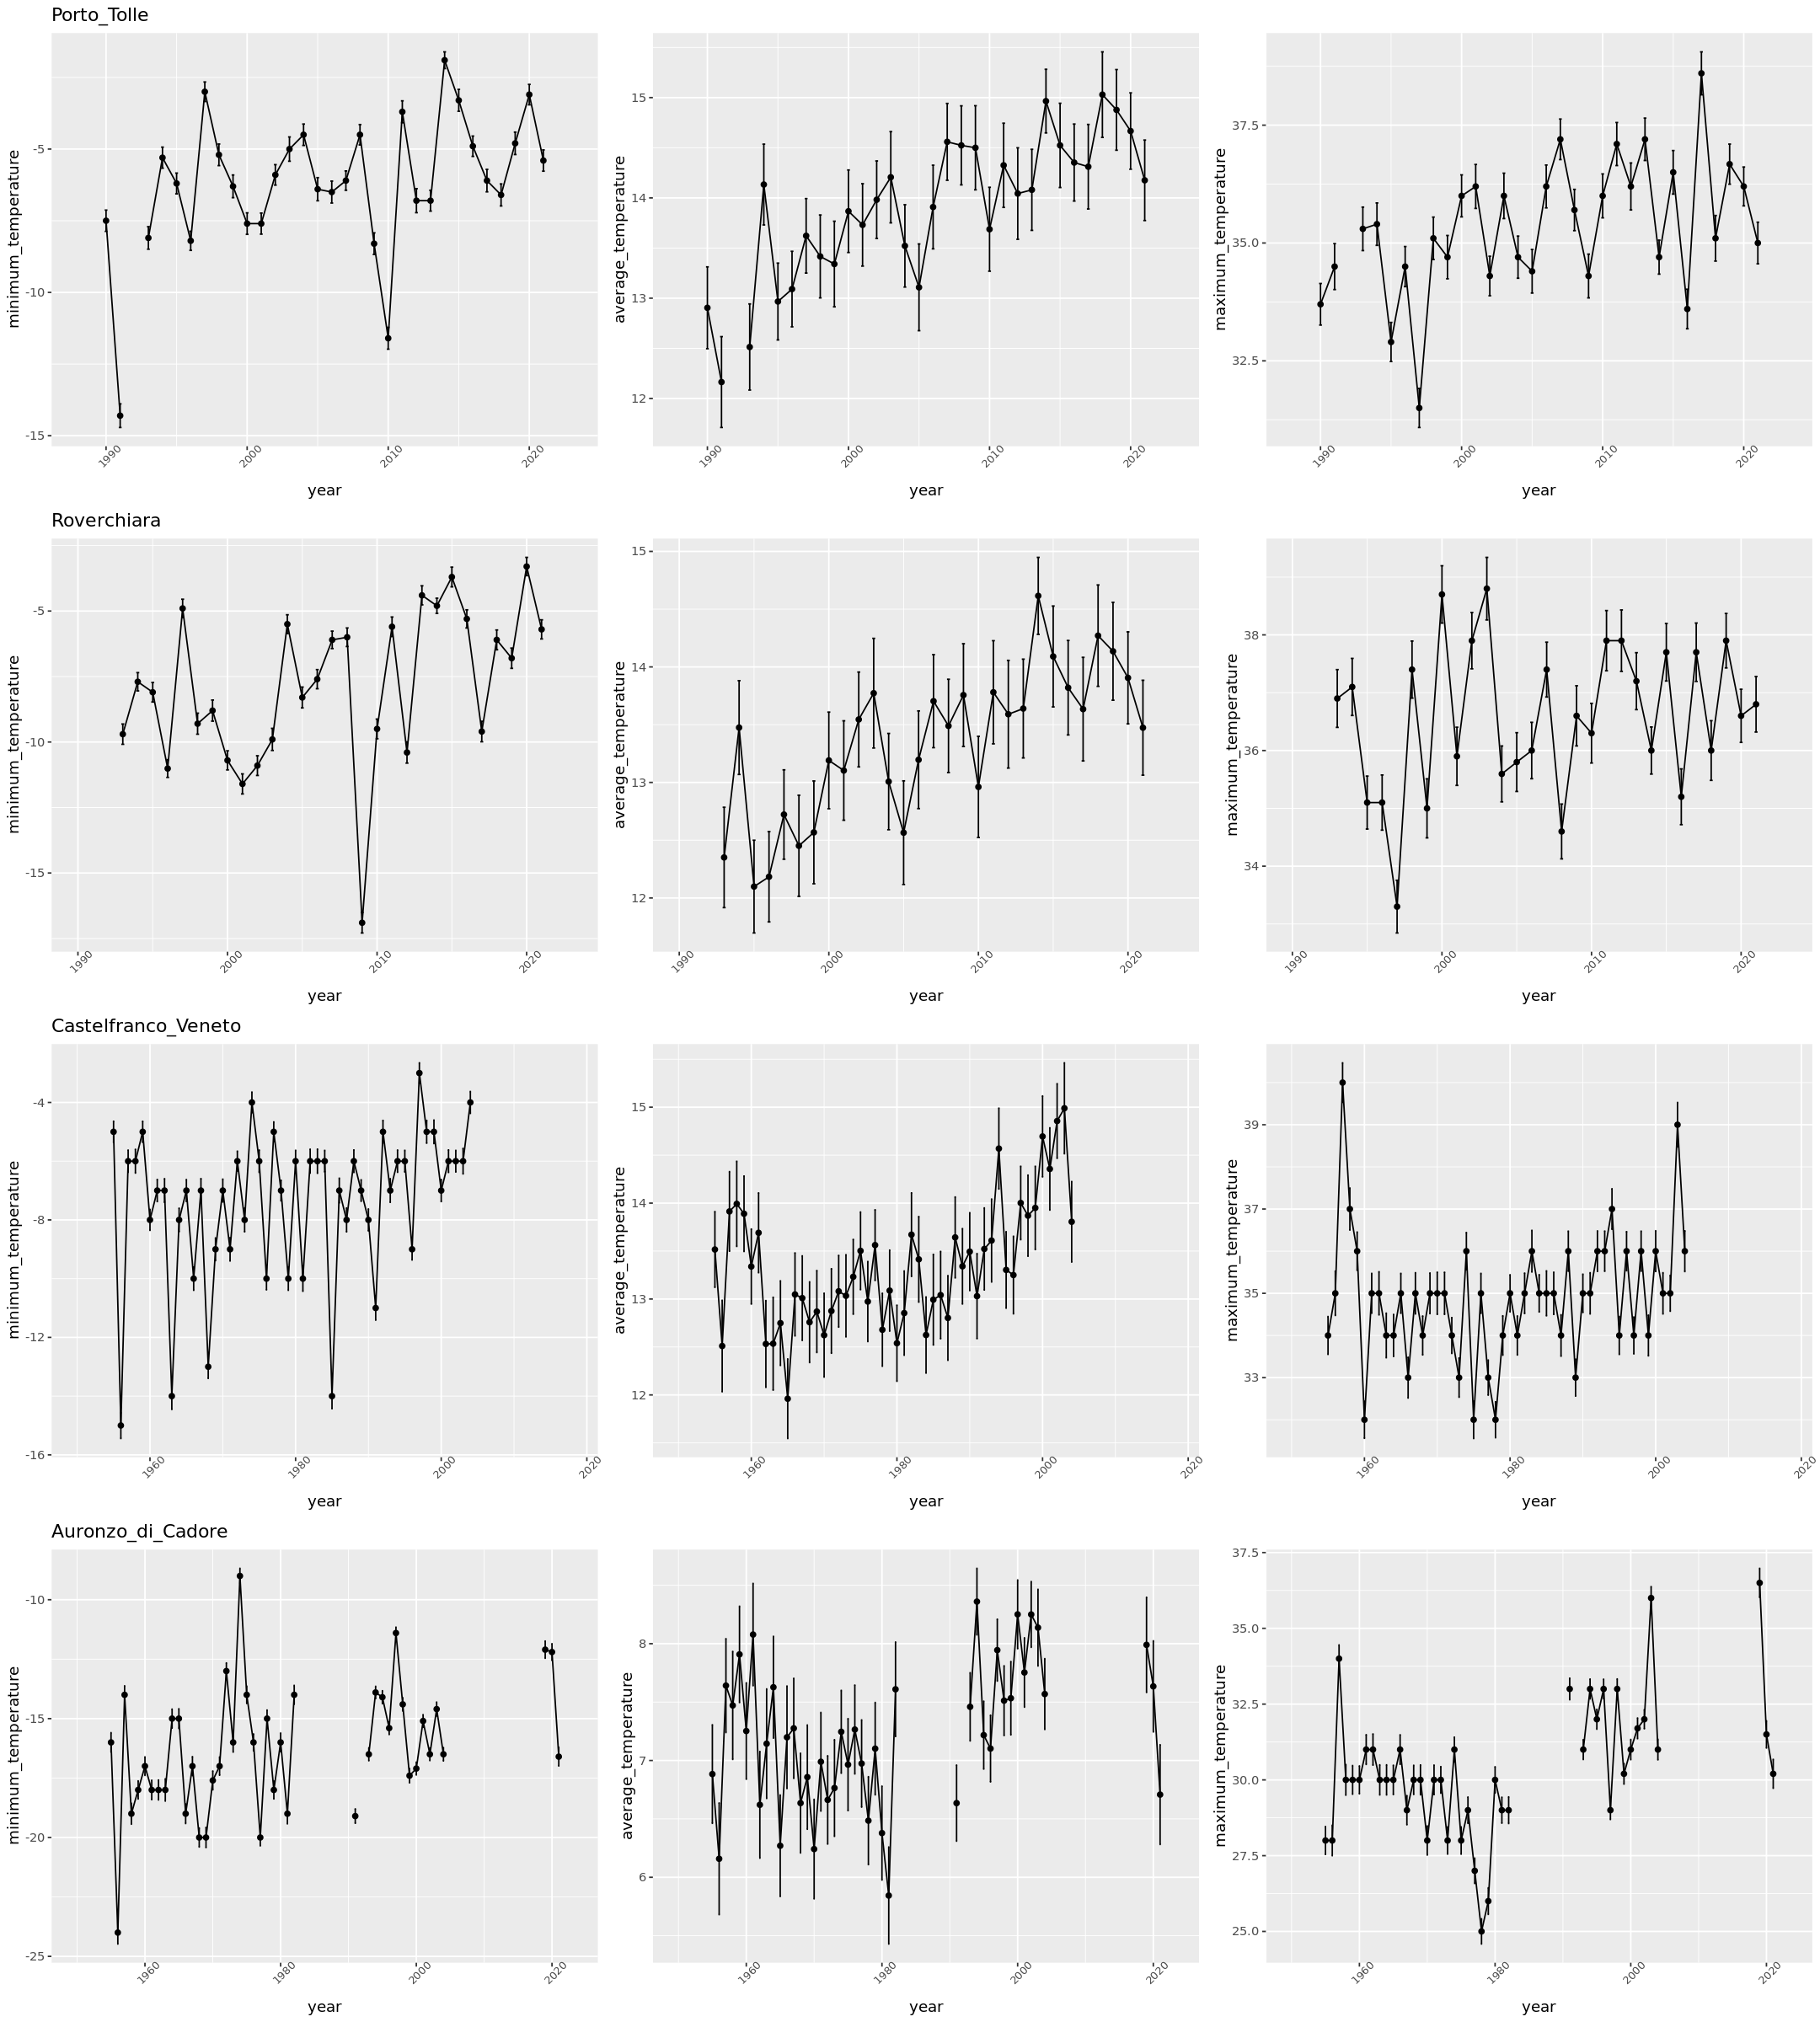

In [10]:
figure <- ggarrange(Porto_Tolle_minimum_plot, Porto_Tolle_average_plot, Porto_Tolle_maximum_plot,
                    Roverchiara_minimum_plot, Roverchiara_average_plot, Roverchiara_maximum_plot,
                    Castelfranco_Veneto_minimum_plot, Castelfranco_Veneto_average_plot, Castelfranco_Veneto_maximum_plot,
                    Auronzo_di_Cadore_minimum_plot, Auronzo_di_Cadore_average_plot, Auronzo_di_Cadore_maximum_plot,
                    ncol = 3, nrow = 4)

In the plot above, each column represents the monthly minimum, average and maximum temperatures over the years. An increase over time is noticeable in all termperatures and locations.
To quantify the increase, I perform regressions with r-JAGS. 

I will start by performing a linear regression and plot the results to see how well the model fits the data. 
Out of the two parameters in the linear model:

$$ y =  mx + q $$ 

I am particularly interested in the slope $m = \frac{\Delta T}{\Delta t}$ which is the rate at which temperature $T$ (in $^\circ$C) changes in time $t$ (measured in years). But the intercept $q$ can also be interesting since it's supposed to represent the temperature $T(t=0)$.

In [11]:
# I start by defining the linear model 
model_text_linear_regression <- "
    model {
      # I set an uniform prior for bot intercept and slope of the linear regression
      beta_0 ~ dunif(0, 1) 
      beta_1 ~ dunif(-50, 50) 

      # Likelihood (Assuming normally distributed errors)
      for (i in 1:N) {
        y[i] ~ dnorm(mu[i], tau)
        mu[i] <- beta_0 + beta_1 * x[i]
      }

      # Precision of the likelihood (inverse of variance)
      tau ~ dgamma(0.001, 0.001)

      # Model error standard deviation
      sigma <- 1 / sqrt(tau)
    }
    "

In [12]:
my_linear_regression <- function(location){
    #function that executes a linear regression over the dataframe which name is related to the input string "location"
    # I prepare the plot
    options(repr.plot.width=18, repr.plot.height=20)
    par( mfrow=c(3,2) )
    # for the specific location
    input_df <- na.omit(get(paste(location,'yearly',sep='_')))
    temperature_names <- c('minimum_temperature', 'average_temperature', 'maximum_temperature')
    location_record <- data.frame()
    # for every temperature I examine
    for (temperature in temperature_names){
        # I prepare the data to be fed to the model
        data_list <- list(
          x = subset(input_df, select = c('year'))[[1]],
          y = subset(input_df, select = c(temperature))[[1]],
          N = nrow( subset(input_df, select = c(temperature)) ) )
        # I initialize the model
        model <- jags.model(textConnection(model_text_linear_regression), data = data_list, quiet = TRUE) 
        # and run the simulation for a certain number of iterations and with a certain burn in
        samples <- coda.samples(model, variable.names = c("beta_0", "beta_1"), n.iter = 10000, n.burnin = 1000) 
        # I save the results in a dataframe
        df <- as.data.frame( as.mcmc(samples) )
        # and retrieve the important information
        invisible( s <- summary(samples) )
        # such as the mean and standard deviation of each parameter
        average <- s$statistics[1,1]
        sigma <- s$statistics[1,2]
#         cat('the intercept estimated from the', temperature,'is: ',
#             round(average,1) , '±', round(sigma,1),'years. \n')
        # I compute the distribution of the parameters
        dens <- density( df$beta_0 ) 
        # to represent it
        plot(dens$x , dens$y, type="l", lwd=2, xaxs="i", col="black", ylim=c(0,1.7), xlab='theta', ylab="density",
                main = paste('intercept distribution for', location, temperature, sep=' '))
        # together with the mean
        abline(v=average, col='red', lwd=2, lty=2)
        # and the 1 sigma interval around it
        abline(v=average+sigma, col='green', lwd=2, lty=2)
        abline(v=average-sigma, col='green', lwd=2, lty=2)
        legend('topright', legend=c("density","average","1 sigma interval"), col=c('black','red','green'), lty = c(1, 2, 2), 
               lwd=c(1, 2, 2), ncol=2, cex=0.8)

        average <- s$statistics[2,1]
        sigma <- s$statistics[2,2]
#         cat('the slope estimated from the', temperature,'is: ',
#             round(average,4) , '±', round(sigma,4), '°C/year. \n')
        dens <- density( df$beta_1 ) 
        plot(dens$x , dens$y, type="l", lwd=2, xaxs="i", col="black", ylim=c(0,3500), xlab='theta', ylab="density",
                main = paste('slope distribution for', location, temperature, sep=' '))
        abline(v=average, col='red', lwd=2, lty=2)
        abline(v=average+sigma, col='green', lwd=2, lty=2)
        abline(v=average-sigma, col='green', lwd=2, lty=2)
        legend('topright', legend=c("density","average","1 sigma interval"), col=c('black','red','green'), lty = c(1, 2, 2), 
               lwd=c(1, 2, 2), ncol=2, cex=0.8)
        
        location_record %>% rbind(data.frame(temperature = temperature, 
                                             slope_mean = s$statistics[2,1], slope_sd = s$statistics[2,2],
                                             intercept_mean = s$statistics[1,1], intercept_sd = s$statistics[1,2])) -> location_record
    }
    print(location_record)
    return(location_record)
}

          temperature   slope_mean     slope_sd intercept_mean intercept_sd
1 minimum_temperature -0.003326341 0.0002670883      0.4994718    0.2879003
2 average_temperature  0.006696184 0.0001518376      0.4786889    0.2829060
3 maximum_temperature  0.017376900 0.0001907293      0.4855696    0.2897156


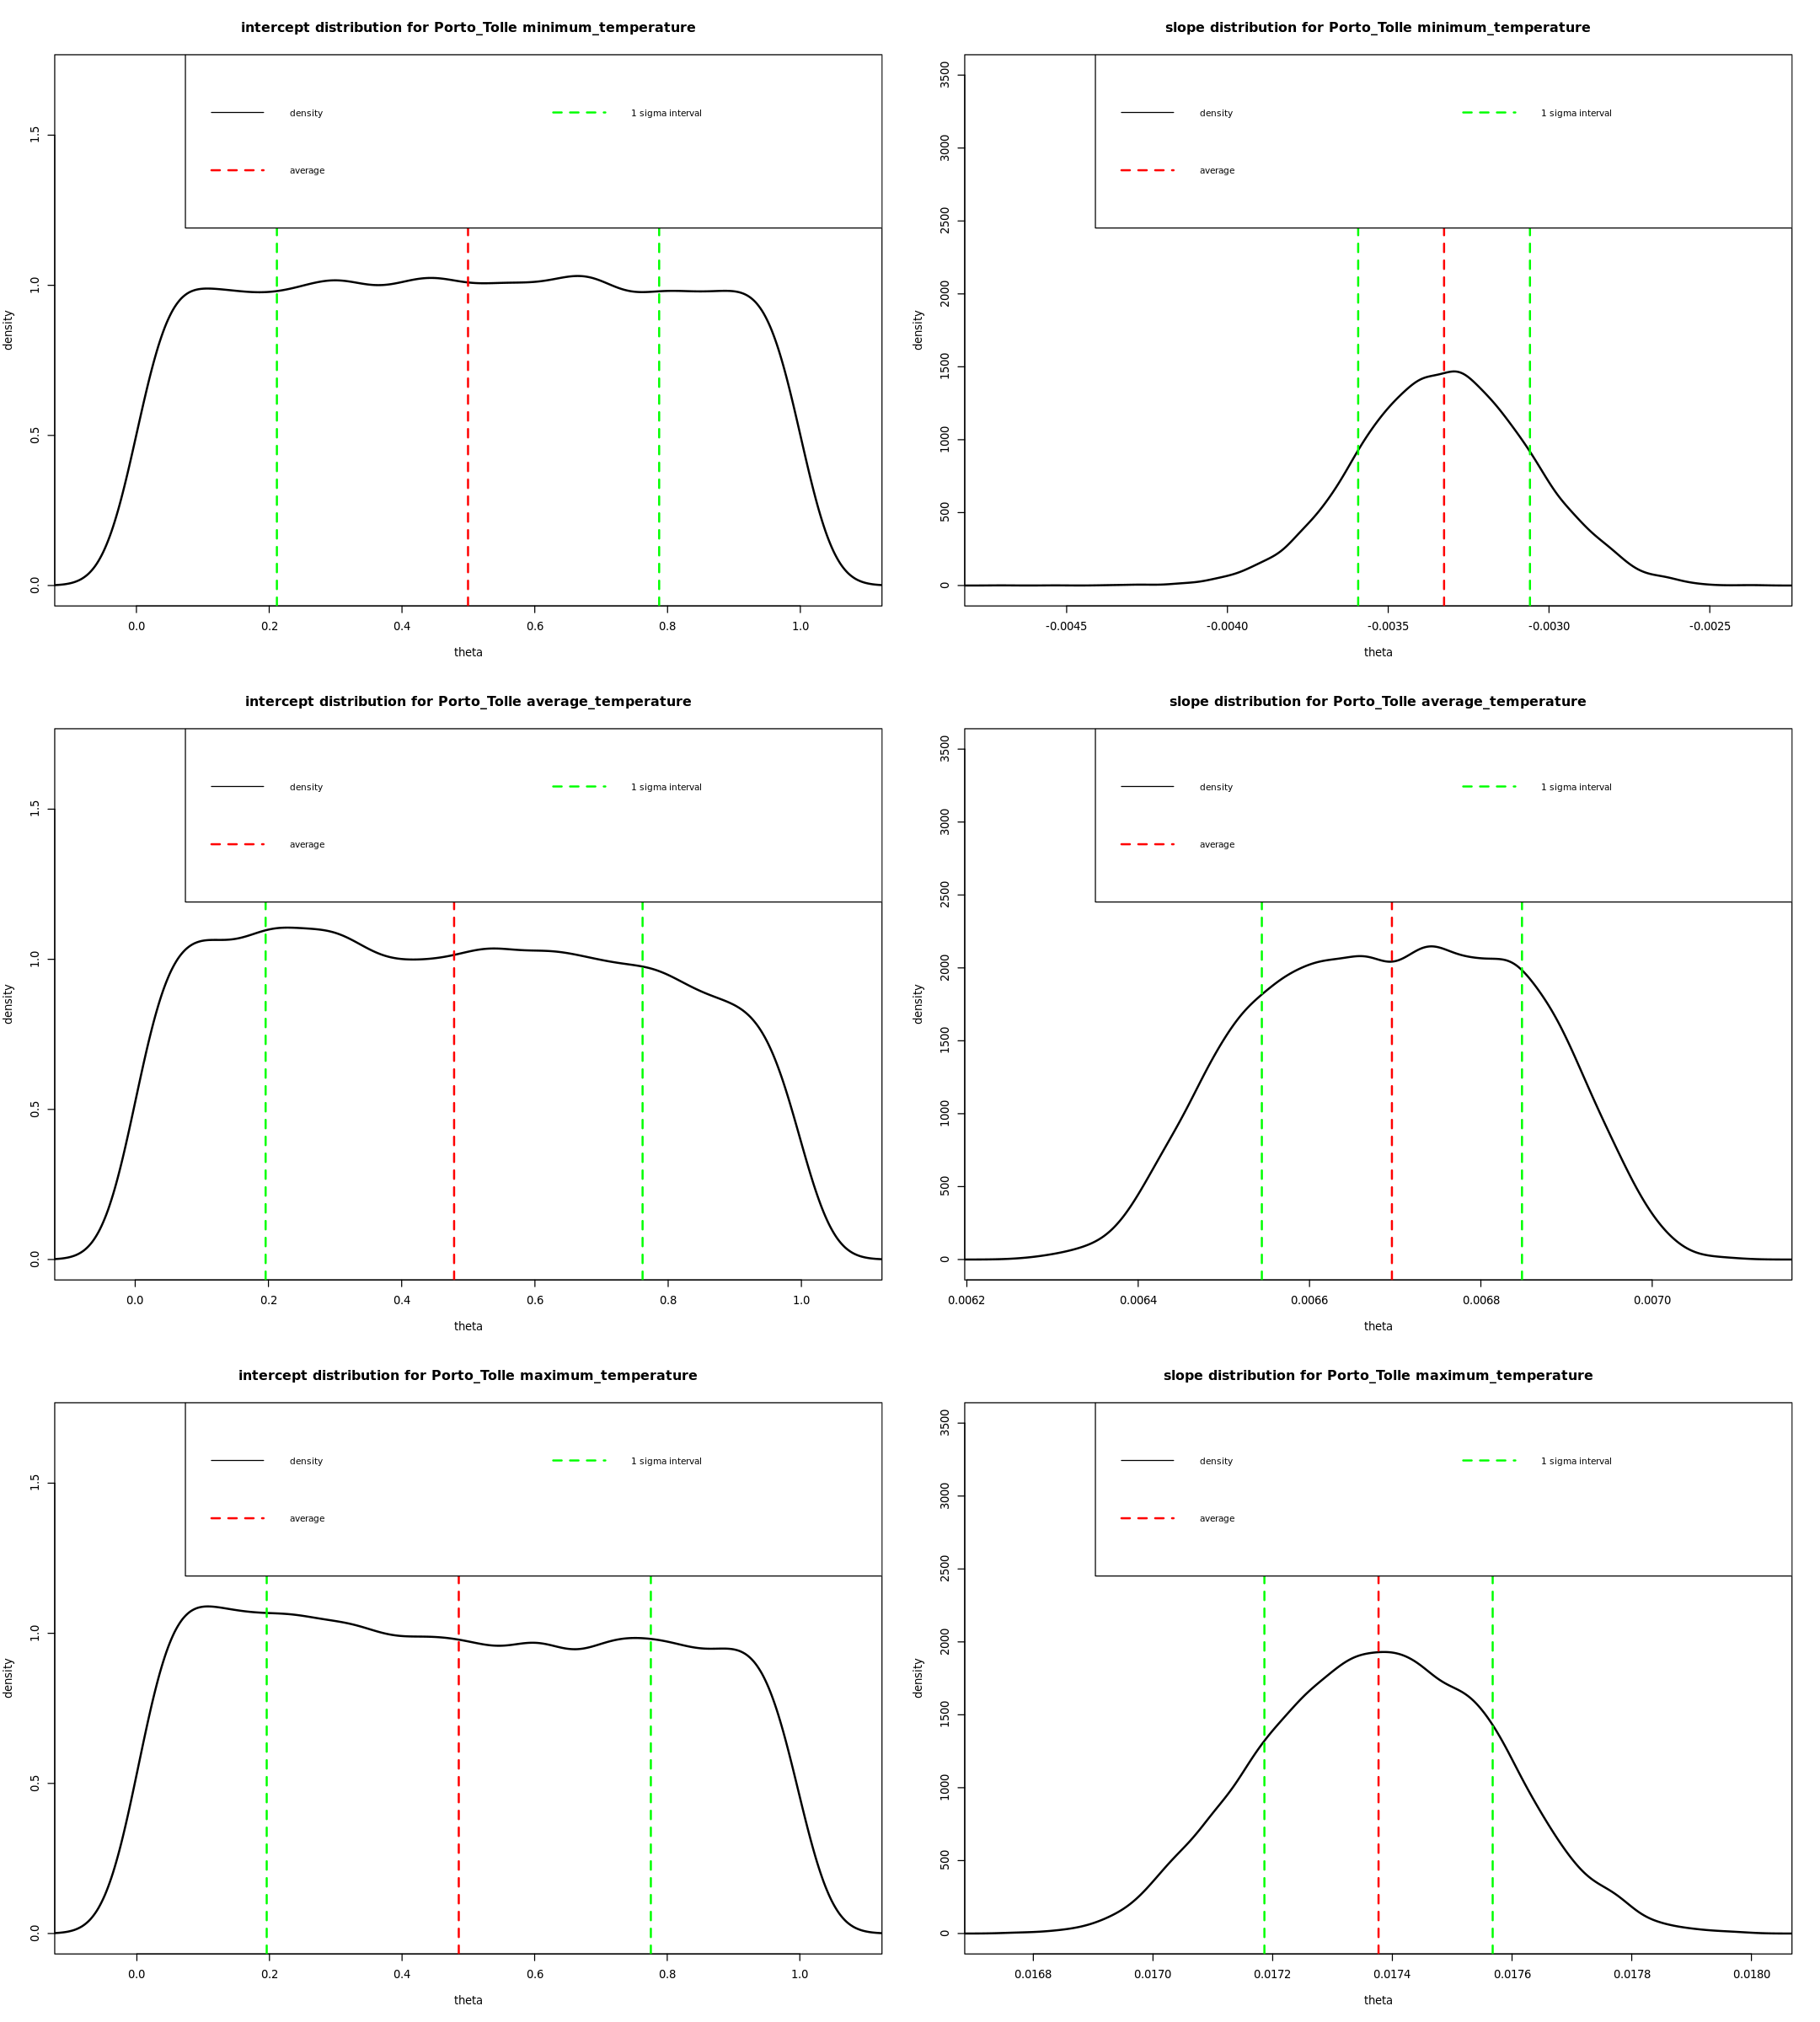

          temperature   slope_mean     slope_sd intercept_mean intercept_sd
1 minimum_temperature -0.004174209 0.0003199917      0.5047403    0.2858884
2 average_temperature  0.006398937 0.0001537679      0.5091738    0.2882324
3 maximum_temperature  0.017972188 0.0001876880      0.4977262    0.2887669


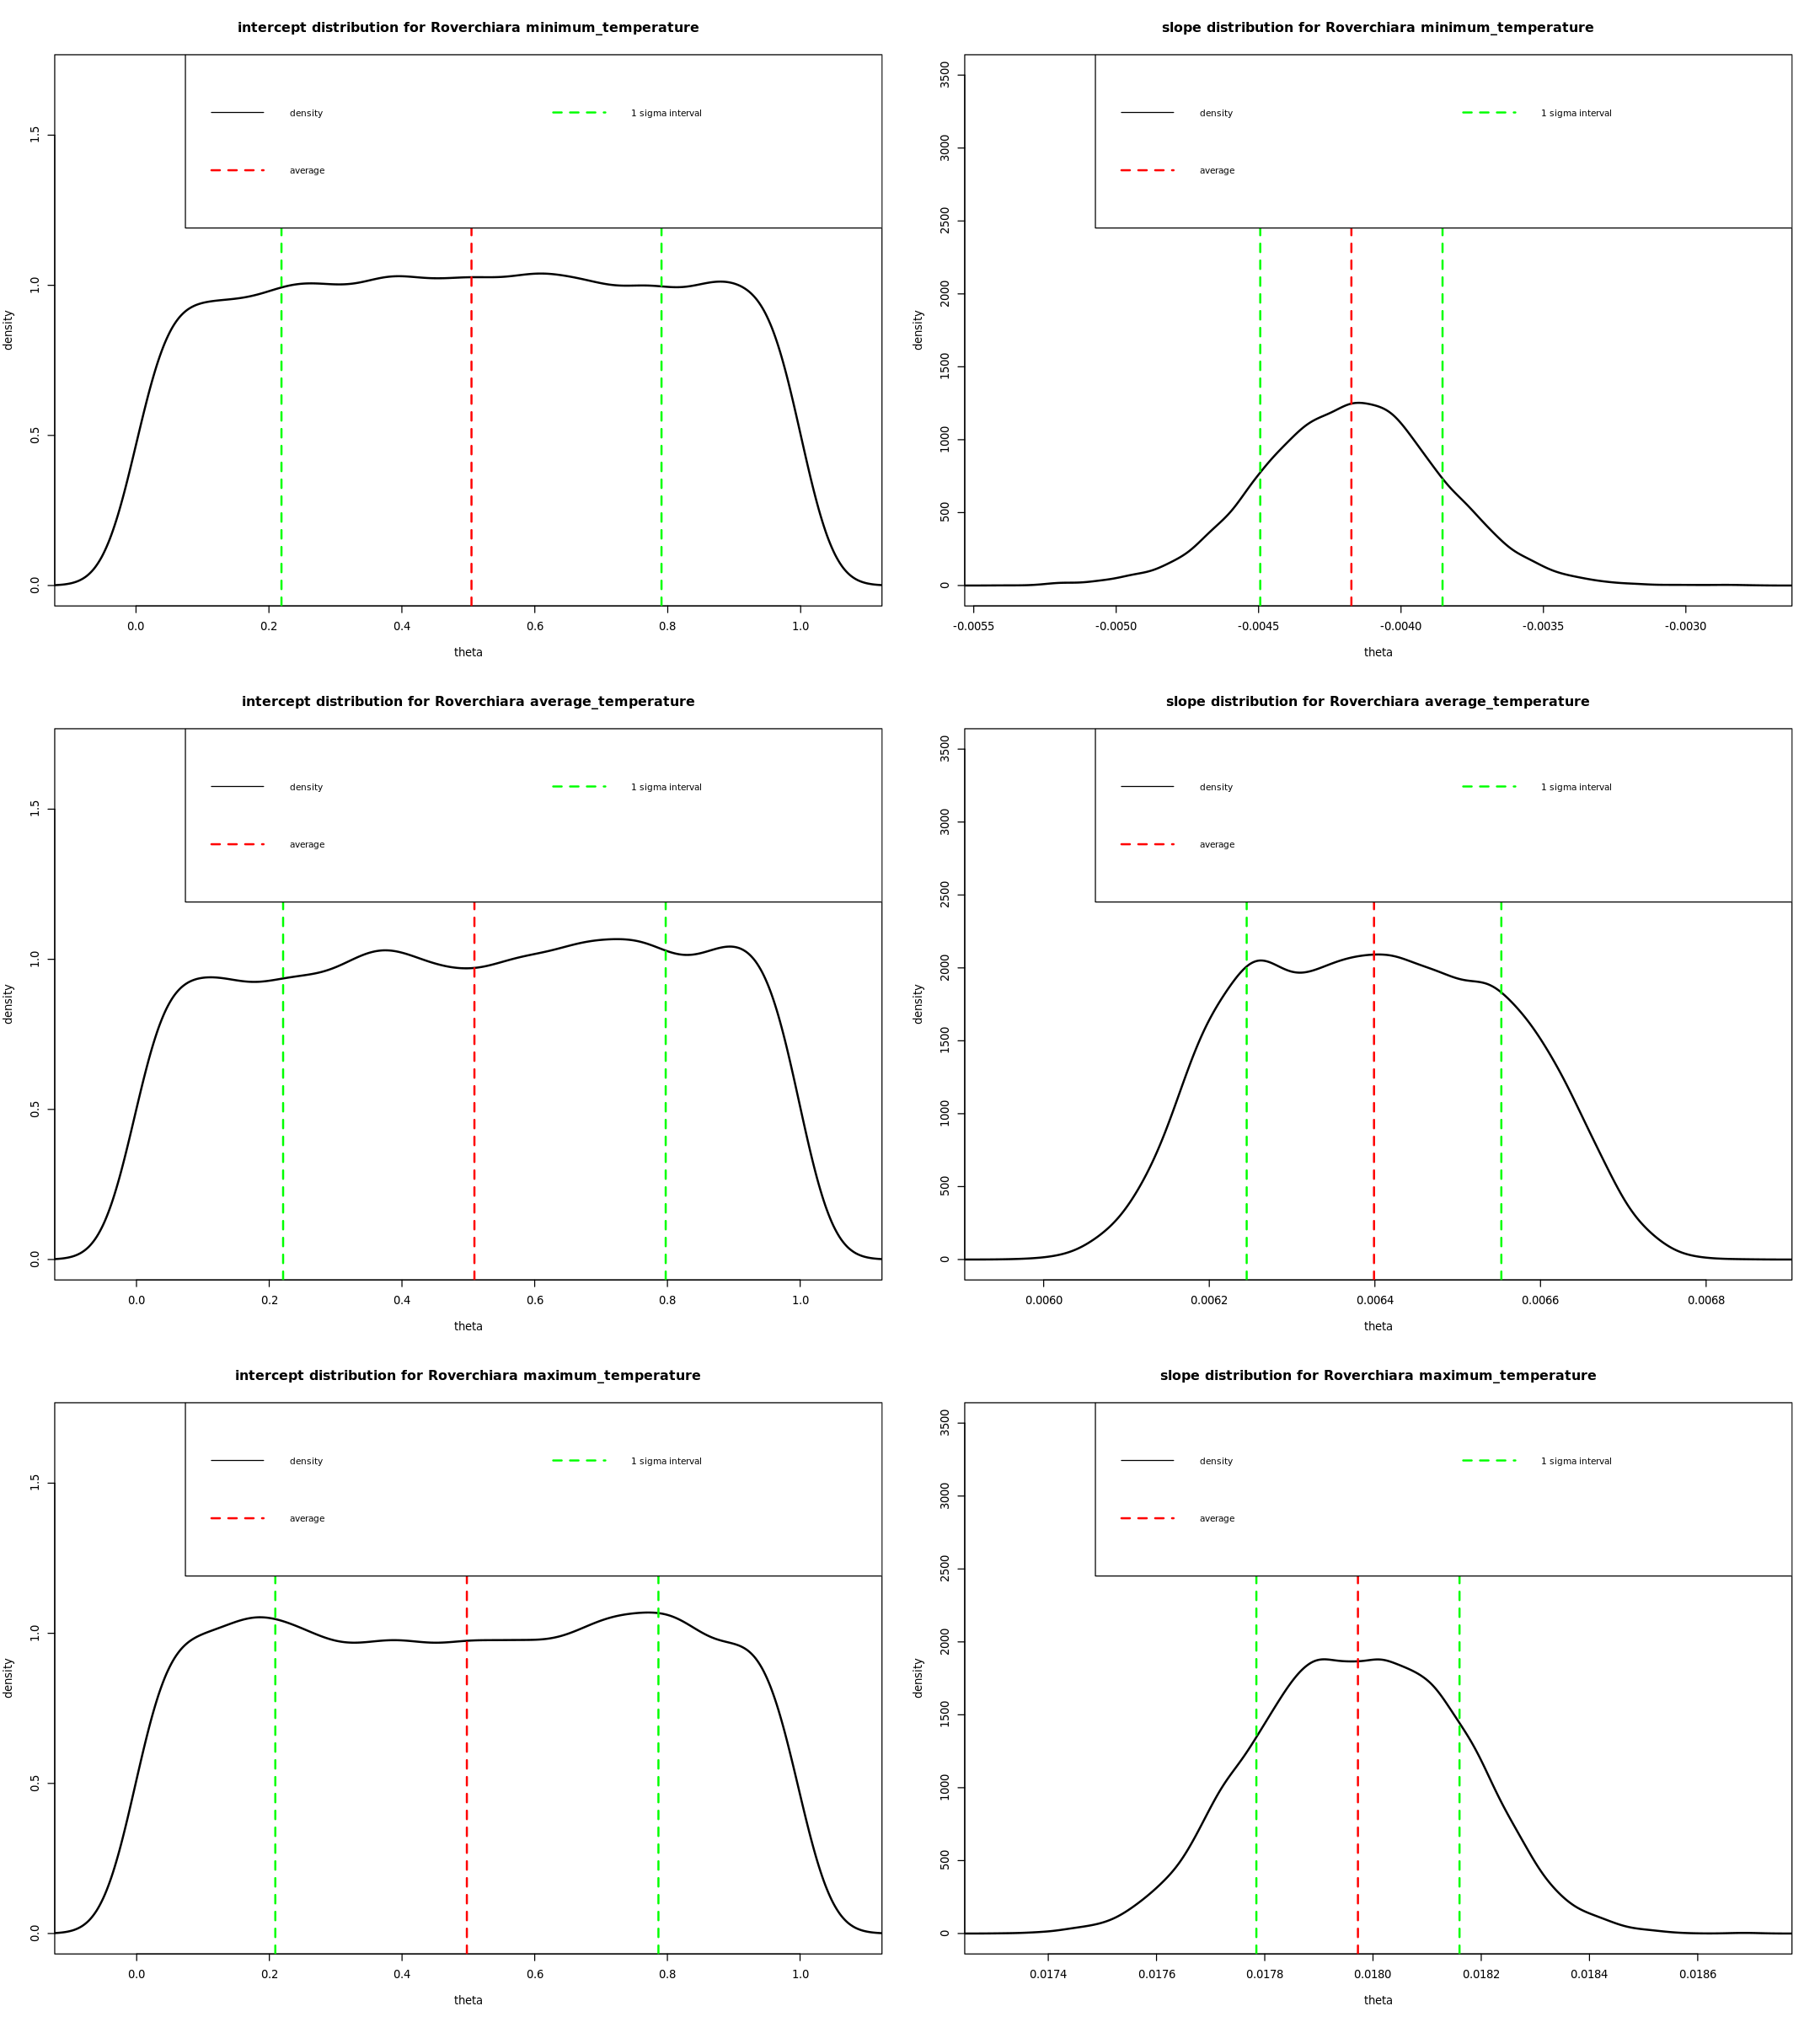

          temperature   slope_mean     slope_sd intercept_mean intercept_sd
1 minimum_temperature -0.003978086 0.0002420829      0.5051302    0.2902960
2 average_temperature  0.006513608 0.0001504363      0.4520809    0.2850270
3 maximum_temperature  0.017382819 0.0001809721      0.4947365    0.2880013


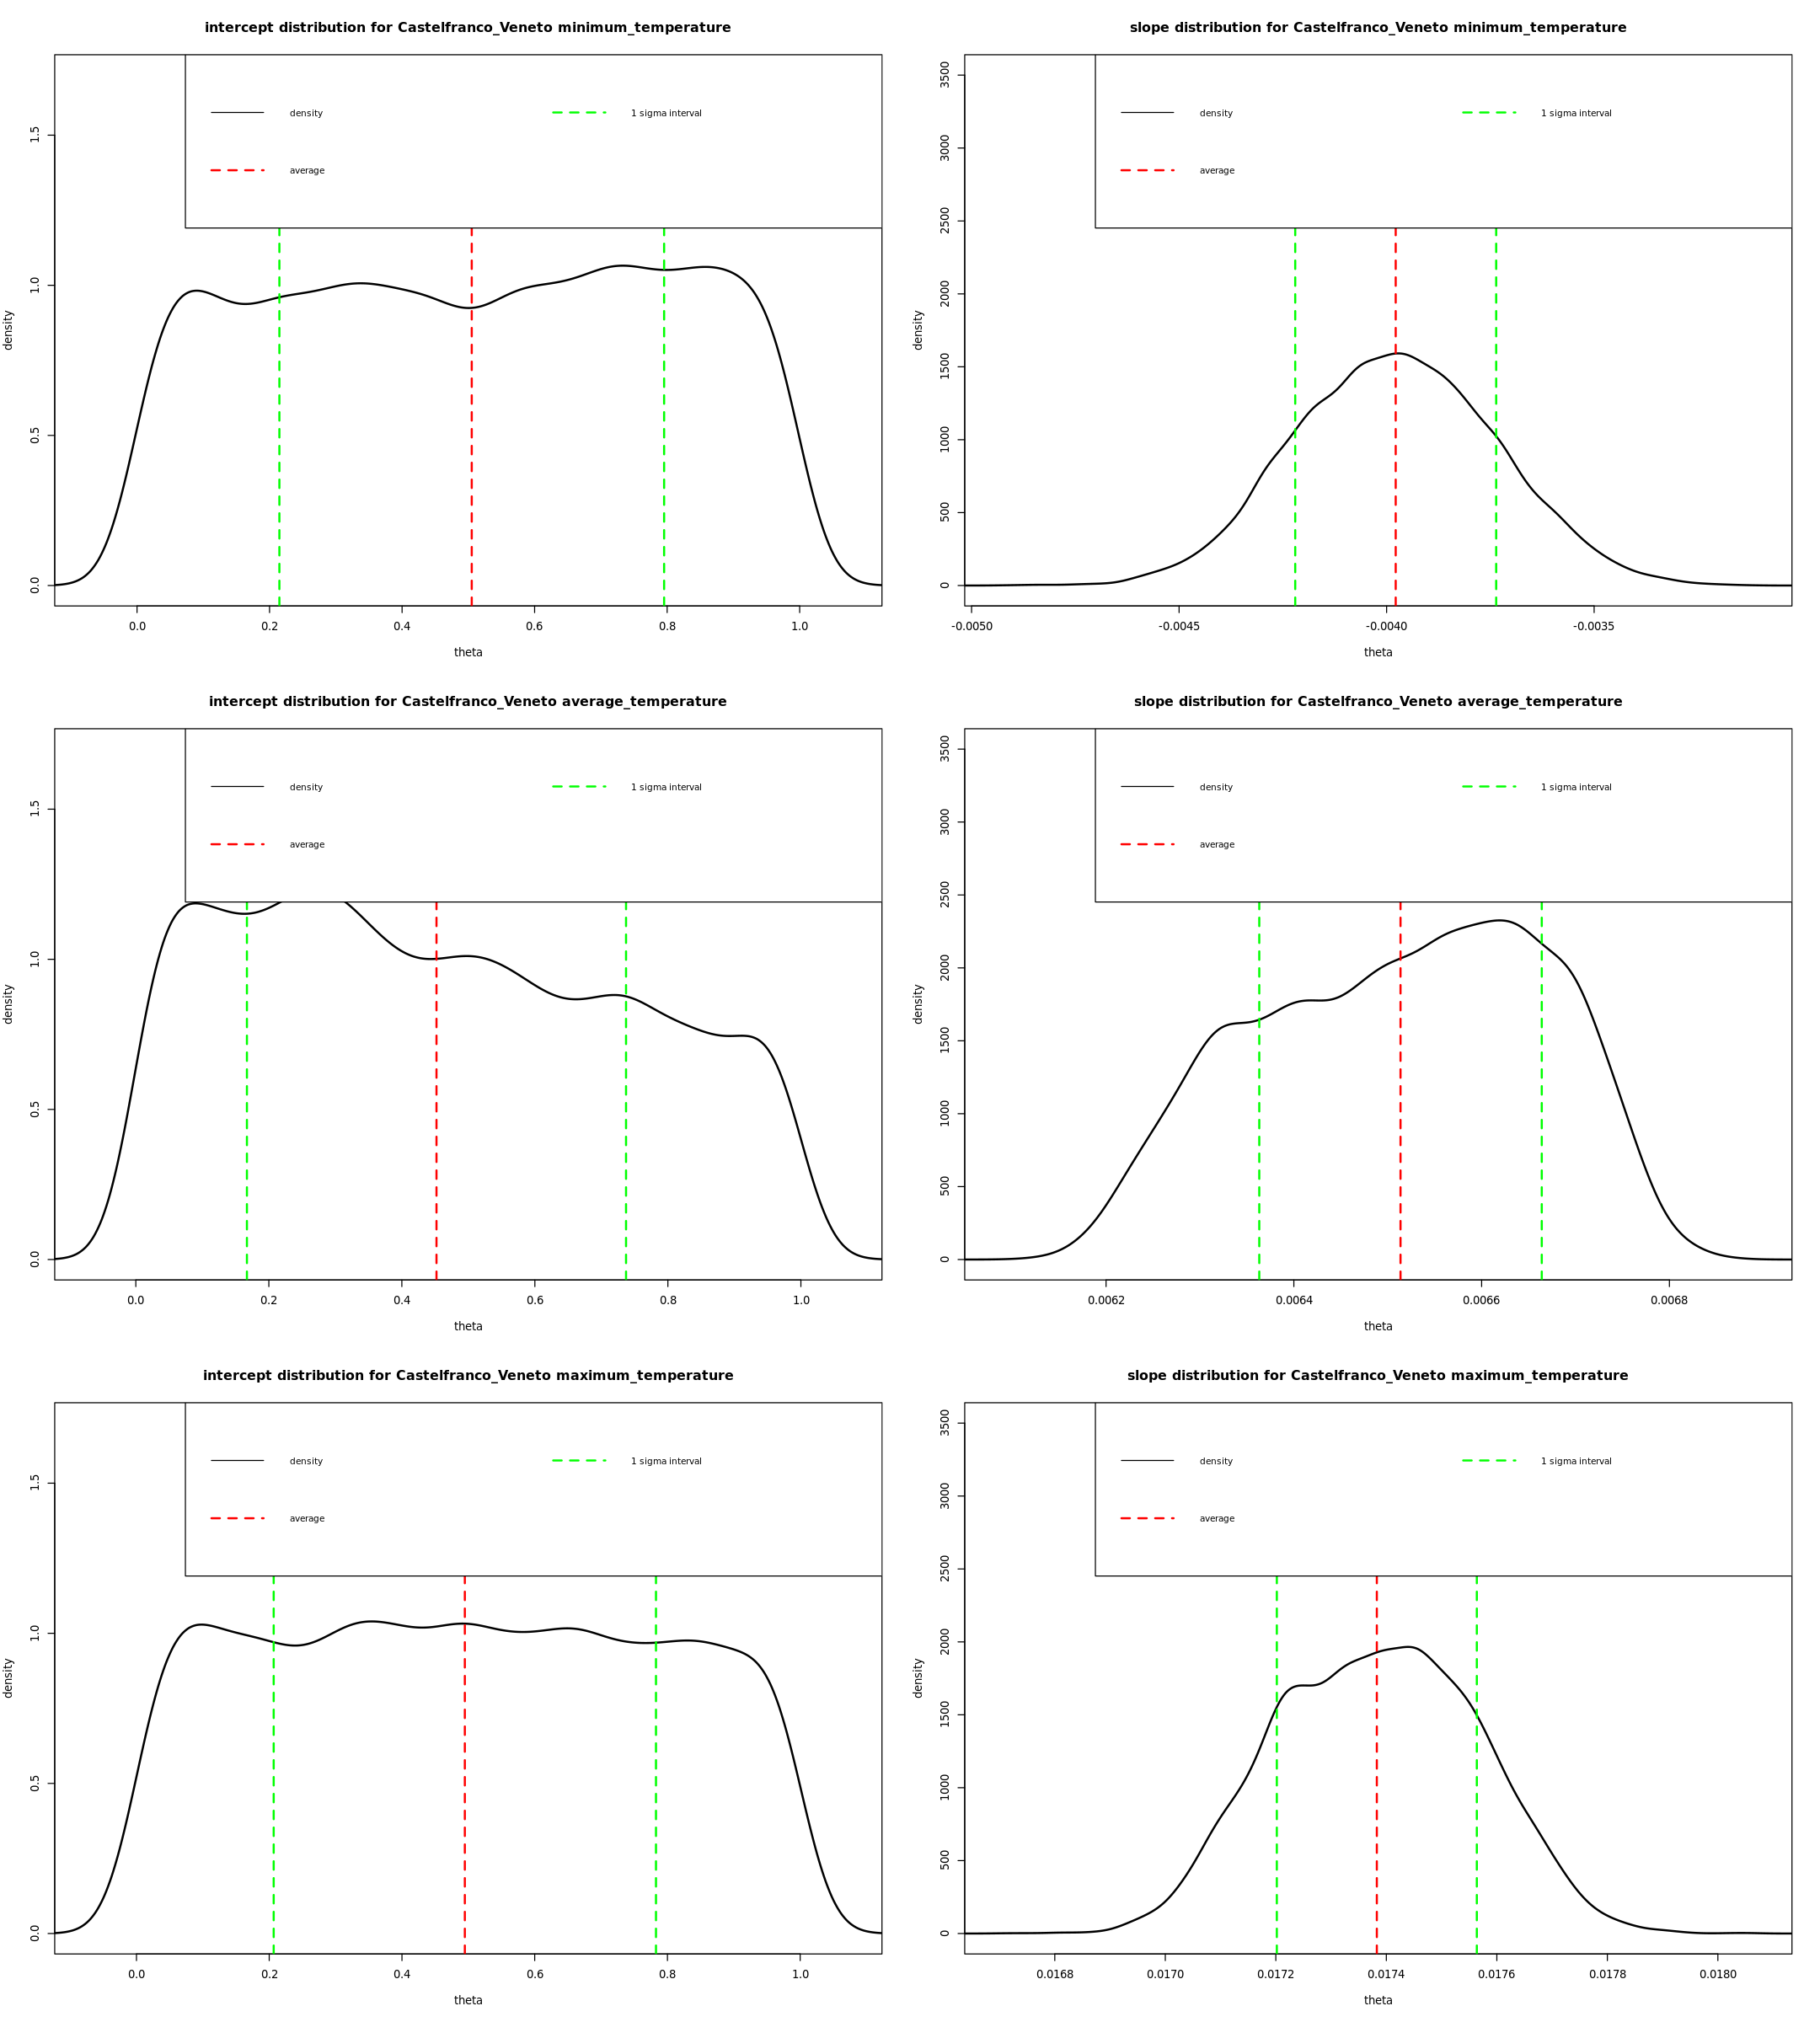

          temperature   slope_mean     slope_sd intercept_mean intercept_sd
1 minimum_temperature -0.008460284 0.0002604039      0.4967042    0.2927364
2 average_temperature  0.003393548 0.0001597200      0.4968658    0.3006736
3 maximum_temperature  0.015084761 0.0002209348      0.4936556    0.2885850


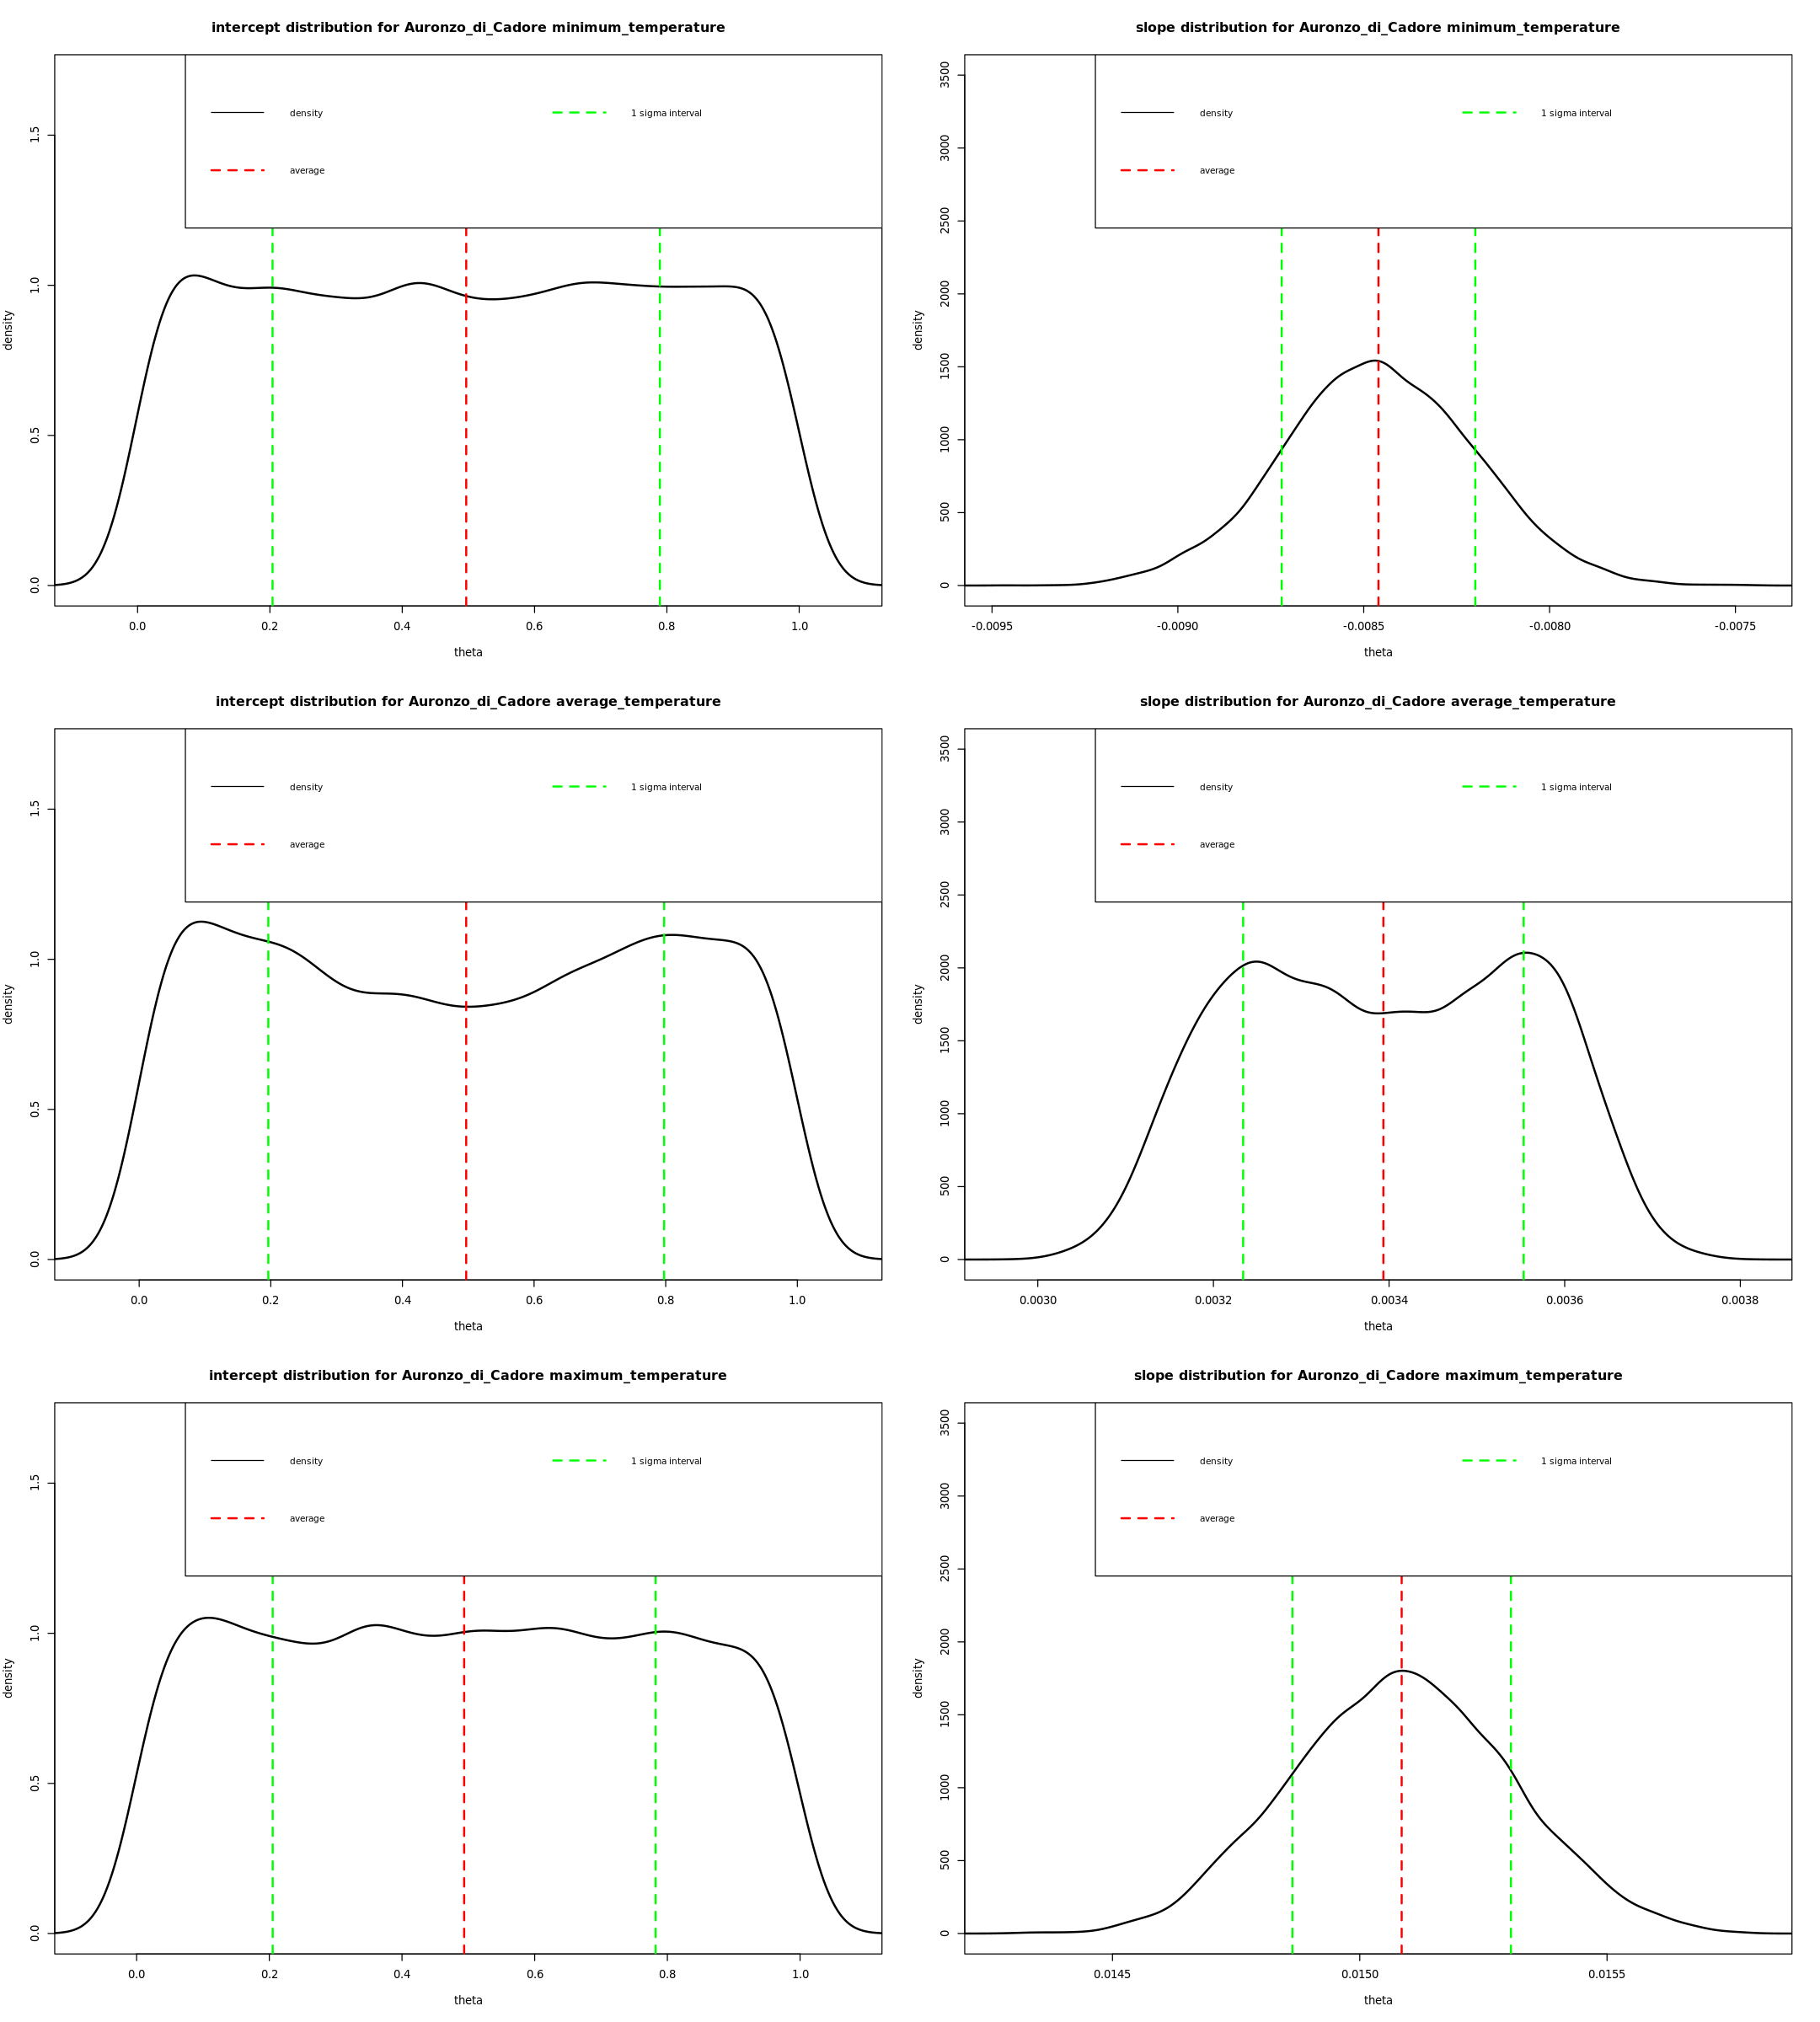

In [13]:
linear_regression_dataframe <- data.frame()
for (ln in location_names){
    temp <- my_linear_regression(ln)
    temp$location <- rep(c(ln), nrow(temp))
    linear_regression_dataframe %>% rbind(temp) -> linear_regression_dataframe }
linear_regression_dataframe %>% arrange(temperature) -> linear_regression_dataframe

In [14]:
linear_regression_dataframe

temperature         slope_mean   slope_sd     intercept_mean intercept_sd
1  average_temperature  0.006696184 0.0001518376 0.4786889      0.2829060   
2  average_temperature  0.006398937 0.0001537679 0.5091738      0.2882324   
3  average_temperature  0.006513608 0.0001504363 0.4520809      0.2850270   
4  average_temperature  0.003393548 0.0001597200 0.4968658      0.3006736   
5  maximum_temperature  0.017376900 0.0001907293 0.4855696      0.2897156   
6  maximum_temperature  0.017972188 0.0001876880 0.4977262      0.2887669   
7  maximum_temperature  0.017382819 0.0001809721 0.4947365      0.2880013   
8  maximum_temperature  0.015084761 0.0002209348 0.4936556      0.2885850   
9  minimum_temperature -0.003326341 0.0002670883 0.4994718      0.2879003   
10 minimum_temperature -0.004174209 0.0003199917 0.5047403      0.2858884   
11 minimum_temperature -0.003978086 0.0002420829 0.5051302      0.2902960   
12 minimum_temperature -0.008460284 0.0002604039 0.4967042      0.2927364   
   location           
1  Porto_Tolle        
2  Roverchiara        
3  Castelfranco_Veneto
4  Auronzo_di_Cadore  
5  Porto_Tolle        
6  Roverchiara        
7  Castelfranco_Veneto
8  Auronzo_di_Cadore  
9  Porto_Tolle        
10 Roverchiara        
11 Castelfranco_Veneto
12 Auronzo_di_Cadore

Let's start from the positives: if I fix a certain temperature, the parameters estimated in different locations are comparable with each other.

I also notice that the simplest assumption that one could take, of homogeniety of the coefficients for all three temperatures, is false, as shown below in the following hypothesis test.

The hypothesis test was executed between the average values over all locations for each type of temperature. The quantity that was examined was the difference between two of the temperatures. Therefore, I used the following formula:

$$ Z = \frac{ (\bar{T_1} - \bar{T_2}) }{\sqrt{ \frac{\sigma^2_1}{N} + \frac{\sigma^2_2}{N} }} \;\; \text{where} \; N=4   $$

The null hypothesis is that the two temperatures in considerations are compatible.

In [15]:
linear_regression_dataframe %>% 
    group_by(temperature) %>% 
    summarize(slope_mean=mean(slope_mean), slope_sd=sqrt(sum(slope_sd))/n(),
              intercept_mean=mean(intercept_mean), intercept_sd=sqrt(sum(intercept_sd))/n()) -> mlrdf

In [16]:
mlrdf

temperature         slope_mean   slope_sd    intercept_mean intercept_sd
1 average_temperature  0.005750569 0.006203637 0.4842023      0.2688911   
2 maximum_temperature  0.016954167 0.006983571 0.4929220      0.2686853   
3 minimum_temperature -0.004984730 0.008252147 0.5015116      0.2688890

In [17]:
Z_slope_average_maximum <- (mlrdf$slope_mean[1] - mlrdf$slope_mean[2])*sqrt(4)/sqrt(mlrdf$slope_sd[1]**2 + mlrdf$slope_sd[2]**2)
Z_slope_average_maximum

[1] -2.398786

In [18]:
Z_slope_average_minimum <- (mlrdf$slope_mean[1] - mlrdf$slope_mean[3])*sqrt(4)/sqrt(mlrdf$slope_sd[1]**2 + mlrdf$slope_sd[3]**2)
Z_slope_average_minimum

[1] 2.079697

In [19]:
Z_slope_maximum_minimum <- (mlrdf$slope_mean[2] - mlrdf$slope_mean[3])*sqrt(4)/sqrt(mlrdf$slope_sd[2]**2 + mlrdf$slope_sd[3]**2)
Z_slope_maximum_minimum

[1] 4.05879

At a 5% level of significance, the rejection region for this test on differences of averages is:
- $|Z|>1.96$ for a two sided test
- $Z > 1.645 \wedge Z < -1.645$ for a one-sided test. 

In both instances and for all three combinations of temperatures, I can reject the null hypothesis (of homogeniety of the three kinds of temperatures) and accept, instead, the alternative hypothesis: the maximum, average, and minimum temperatures are changing differently.

This effect is understandable since global warming effects aren't so straight-forwards to just cause an increase of temperature in all climates. \
As I've been able to see first hand, global warming has effected our climates by causing more extreme weather conditions: colder winterns (henceforth the slightly negative slope for the minimum temperatures) and hotter summers (with a significant positive slope for the maximum temperatures). The warming effect still takes over, causing the average temperatures to still increase but, at least, at a slower rate than the maximum temperatures.

Let's look at the downsides now: as implied by the wide distributions seen above, the parameters estimated by the linear regression aren't very precise. The standard deviation of the slopes is just one order less than its average, and it's even worse for the intercept, which average and standard deviation are of the same order of magnitude. 

So, we need more meaningful models or measurements to make more precise estimations of these parameters, which will be kept separate between mininum, average, and maximum temperature.

So, I decide to first try by changing the model: I first lower and then increase the order of the polinomial model, to test how good the linear approximation really is and, hopefully, find more precise estimates of the parameters.

In [20]:
# I start by defining the linear model 
model_text_constant_regression <- "
    model {
      # I set an uniform prior for bot intercept and slope of the linear regression
      beta_0 ~ dunif(-50, 50) 

      # Likelihood (Assuming normally distributed errors)
      for (i in 1:N) {
        y[i] ~ dnorm(mu[i], tau)
        mu[i] <- beta_0
      }

      # Precision of the likelihood (inverse of variance)
      tau ~ dgamma(0.001, 0.001)

      # Model error standard deviation
      sigma <- 1 / sqrt(tau)
    }
    "

In [21]:
my_constant_regression <- function(location){
    #function that executes a linear regression over the dataframe which name is related to the input string "location"
    # I prepare the plot
    options(repr.plot.width=18, repr.plot.height=6)
    par( mfrow=c(1,3) )
    # for the specific location
    input_df <- na.omit(get(paste(location,'yearly',sep='_')))
    temperature_names <- c('minimum_temperature', 'average_temperature', 'maximum_temperature')
    location_record <- data.frame()
    # for every temperature I examine
    for (temperature in temperature_names){
        # I prepare the data to be fed to the model
        data_list <- list(
          x = subset(input_df, select = c('year'))[[1]],
          y = subset(input_df, select = c(temperature))[[1]],
          N = nrow( subset(input_df, select = c(temperature)) ) )
        # I initialize the model
        model <- jags.model(textConnection(model_text_constant_regression), data = data_list, quiet = TRUE) 
        # and run the simulation for a certain number of iterations and with a certain burn in
        samples <- coda.samples(model, variable.names = c("beta_0", "beta_1"), n.iter = 10000, n.burnin = 1000) 
        # I save the results in a dataframe
        df <- as.data.frame( as.mcmc(samples) )
        # and retrieve the important information
        invisible( s <- summary(samples) )
        # such as the mean and standard deviation of each parameter
        average <- s$statistics[1]
        sigma <- s$statistics[2]
#         cat('the intercept estimated from the', temperature,'is: ',
#             round(average,1) , '±', round(sigma,1),'years. \n')
        # I compute the distribution of the parameters
        dens <- density( df$beta_0 ) 
        # to represent it
        plot(dens$x , dens$y, type="l", lwd=2, xaxs="i", col="black", ylim=c(0,4.5), xlab='theta', ylab="density",
                main = paste('intercept distribution for', location, temperature, sep=' '))
        # together with the mean
        abline(v=average, col='red', lwd=2, lty=2)
        # and the 1 sigma interval around it
        abline(v=average+sigma, col='green', lwd=2, lty=2)
        abline(v=average-sigma, col='green', lwd=2, lty=2)
        legend('topright', legend=c("density","average","1 sigma interval"), col=c('black','red','green'), lty = c(1, 2, 2), 
               lwd=c(1, 2, 2), ncol=2, cex=0.8)
        
        location_record %>% rbind(data.frame(temperature = temperature, 
                                             intercept_mean = s$statistics[1], intercept_sd = s$statistics[2])) -> location_record
    }
    print(location_record)
    return(location_record)
}

              temperature intercept_mean intercept_sd
Mean  minimum_temperature      -6.174979    0.4562388
Mean1 average_temperature      13.905731    0.1328221
Mean2 maximum_temperature      35.338411    0.2691560


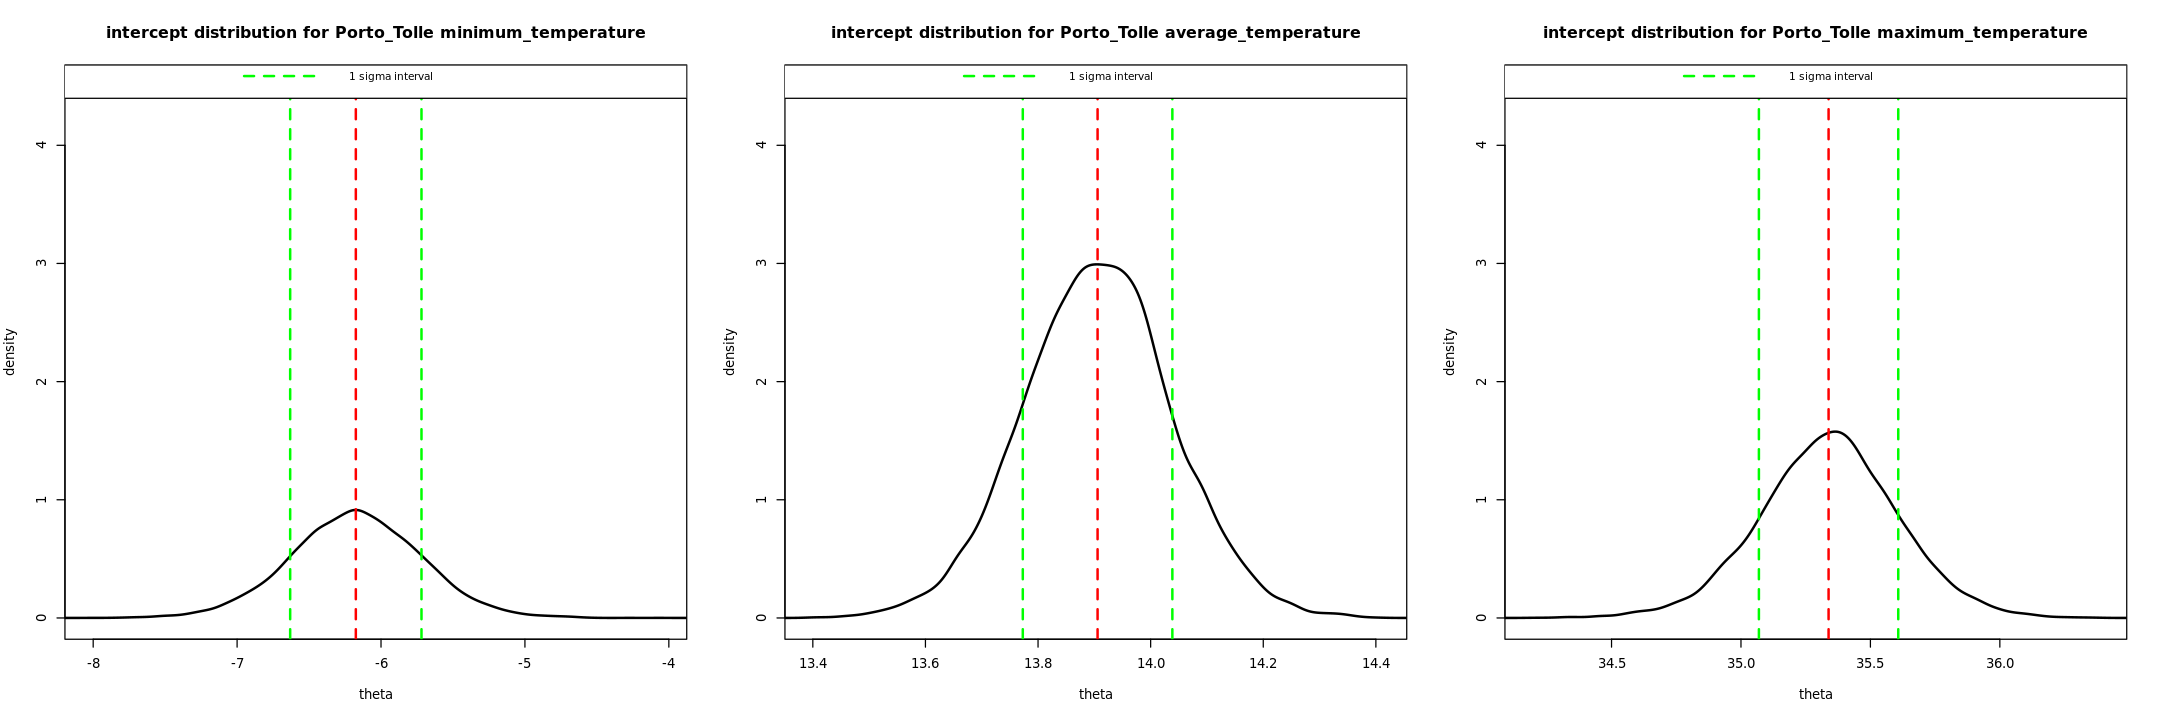

              temperature intercept_mean intercept_sd
Mean  minimum_temperature      -7.883824    0.5655297
Mean1 average_temperature      13.348874    0.1243330
Mean2 maximum_temperature      36.562817    0.2497781


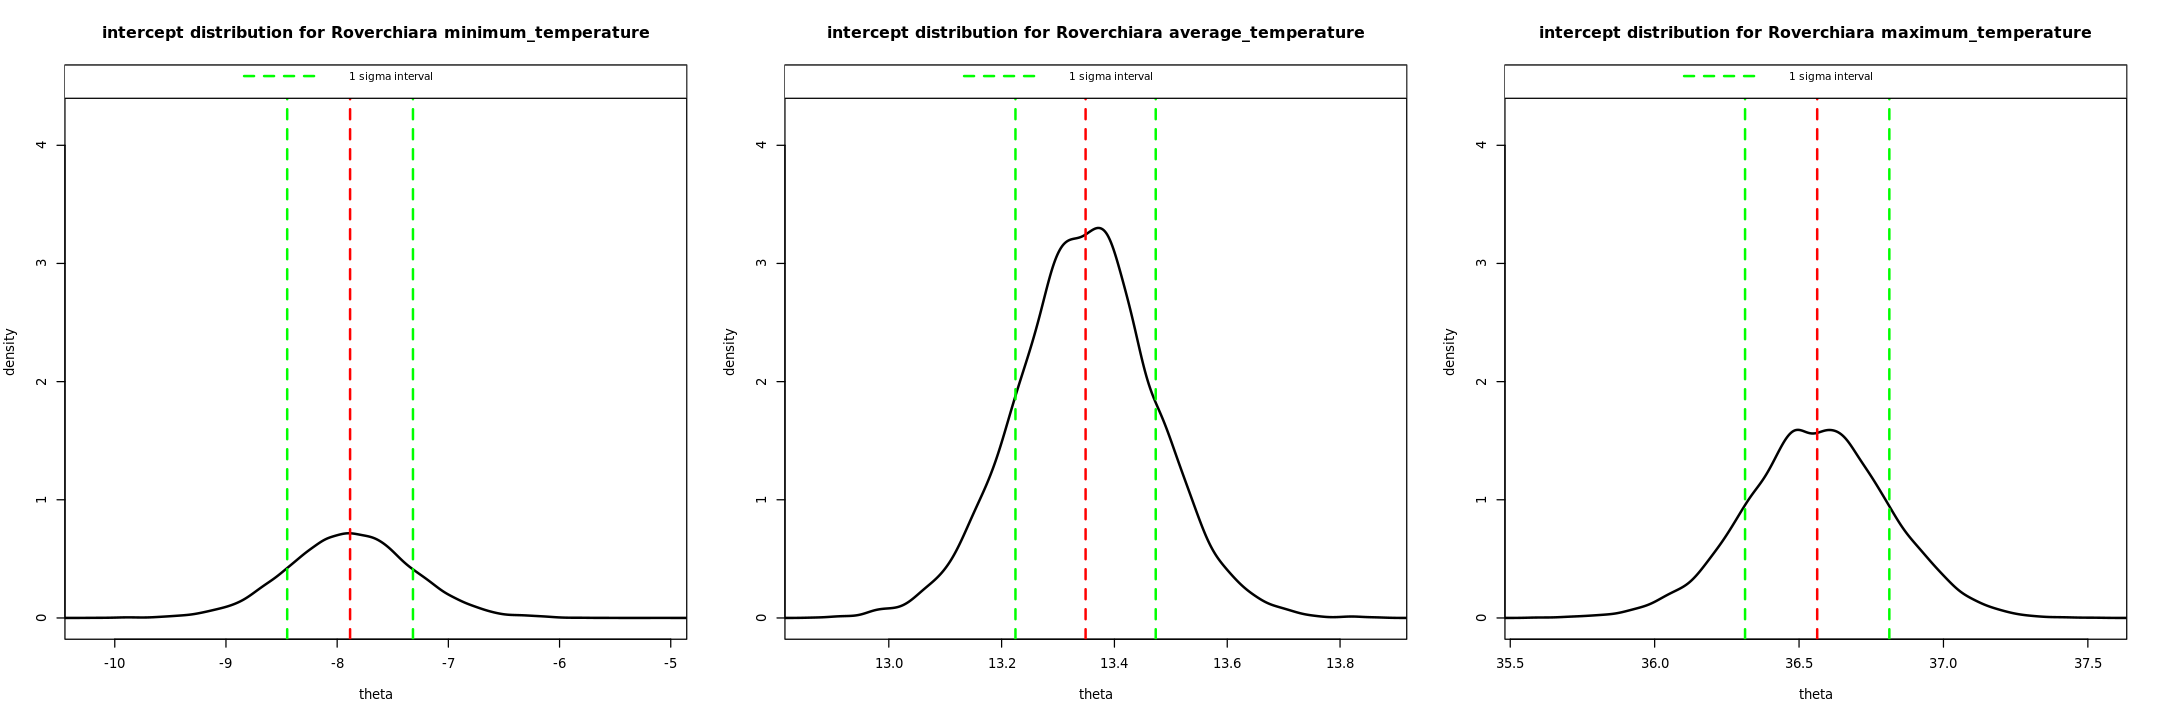

              temperature intercept_mean intercept_sd
Mean  minimum_temperature      -7.374688   0.37957402
Mean1 average_temperature      13.343598   0.09339834
Mean2 maximum_temperature      34.901355   0.21865793


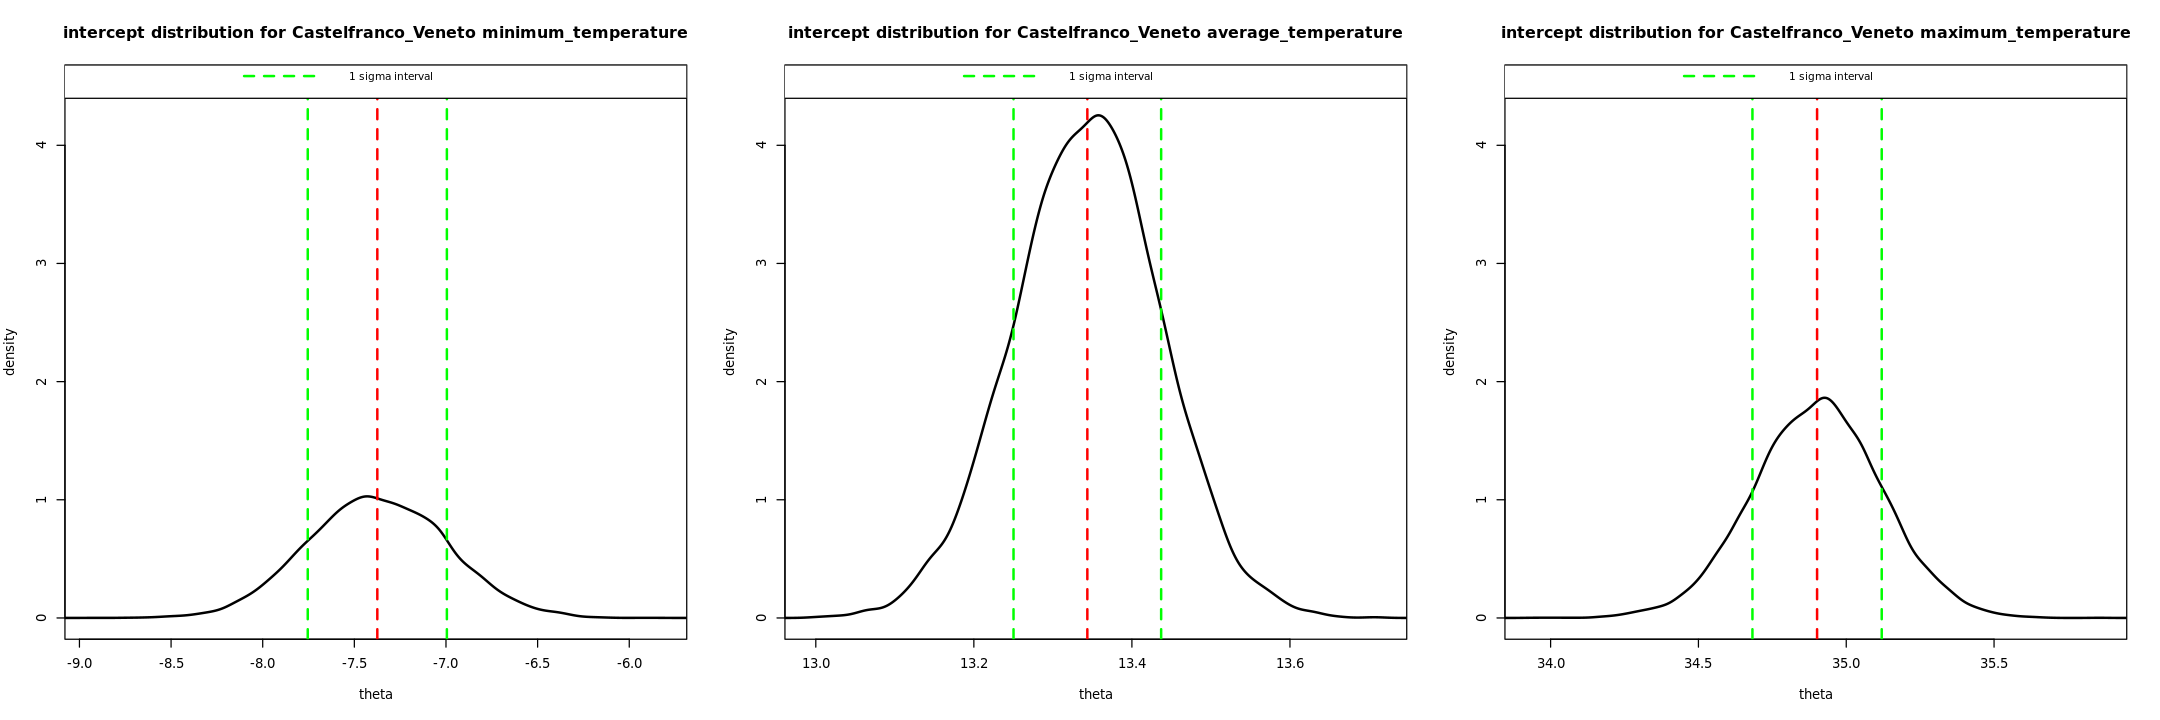

              temperature intercept_mean intercept_sd
Mean  minimum_temperature     -16.262408   0.41857237
Mean1 average_temperature       7.218386   0.09630039
Mean2 maximum_temperature      30.365314   0.35020399


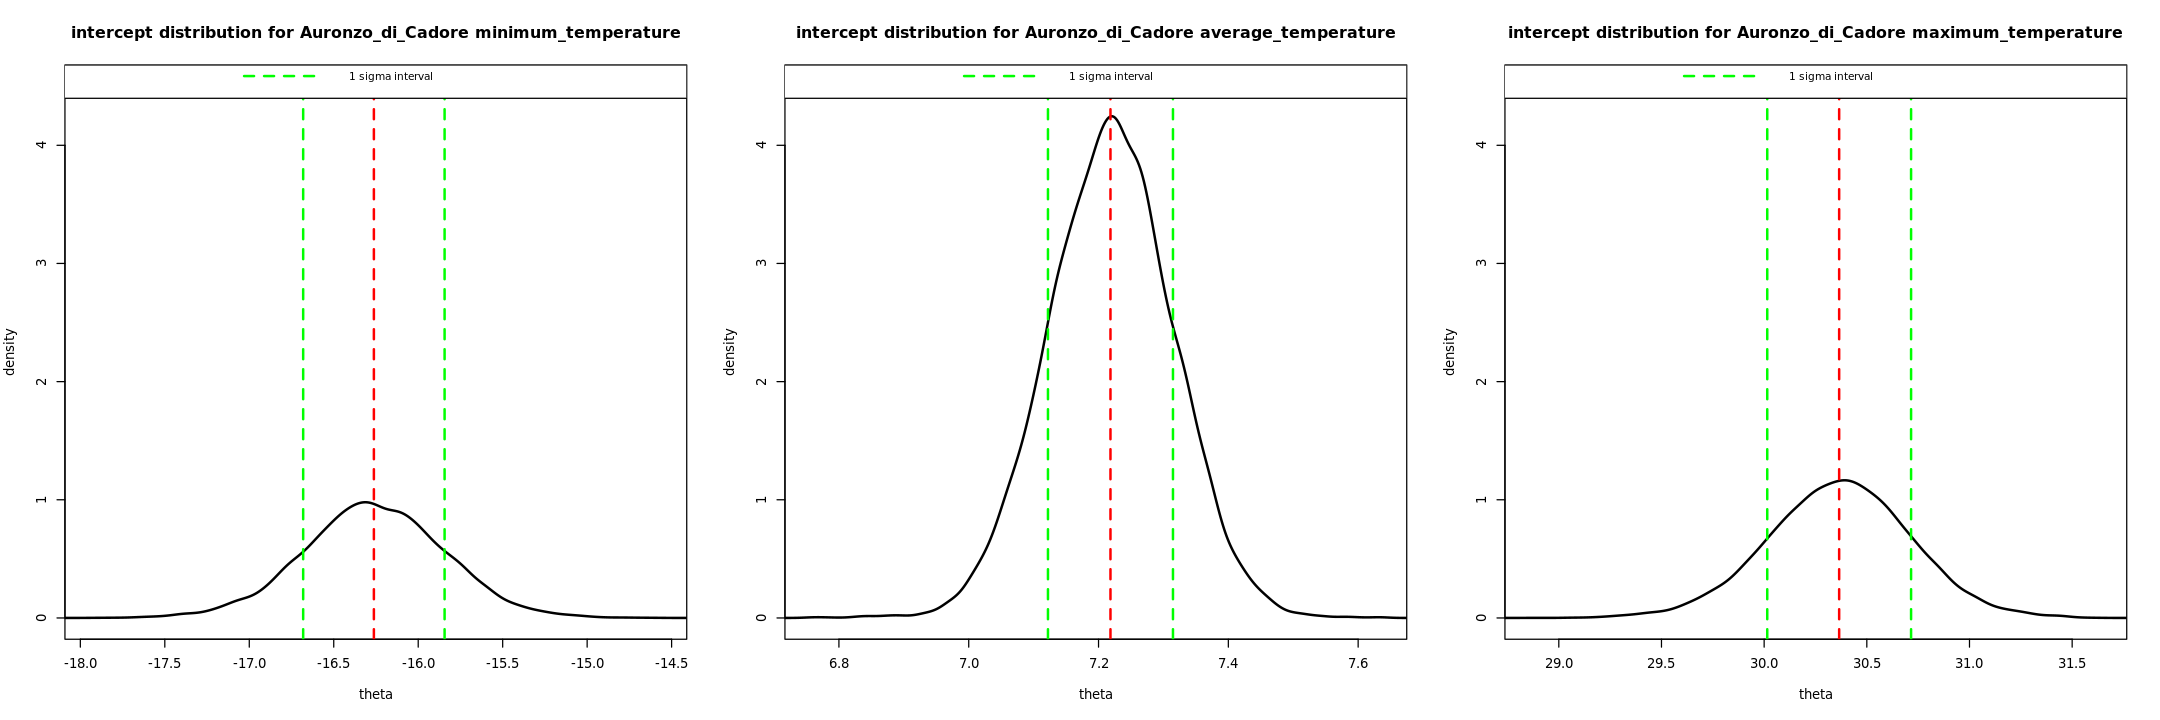

In [22]:
constant_regression_dataframe <- data.frame()
for (ln in location_names){
    temp <- my_constant_regression(ln)
    temp$location <- rep(c(ln), nrow(temp))
    constant_regression_dataframe %>% rbind(temp) -> constant_regression_dataframe }
constant_regression_dataframe %>% arrange(temperature) -> constant_regression_dataframe

In [23]:
constant_regression_dataframe

temperature         intercept_mean intercept_sd location           
Mean1  average_temperature  13.905731     0.13282215   Porto_Tolle        
Mean11 average_temperature  13.348874     0.12433296   Roverchiara        
Mean12 average_temperature  13.343598     0.09339834   Castelfranco_Veneto
Mean13 average_temperature   7.218386     0.09630039   Auronzo_di_Cadore  
Mean2  maximum_temperature  35.338411     0.26915599   Porto_Tolle        
Mean21 maximum_temperature  36.562817     0.24977810   Roverchiara        
Mean22 maximum_temperature  34.901355     0.21865793   Castelfranco_Veneto
Mean23 maximum_temperature  30.365314     0.35020399   Auronzo_di_Cadore  
Mean   minimum_temperature  -6.174979     0.45623883   Porto_Tolle        
Mean3  minimum_temperature  -7.883824     0.56552966   Roverchiara        
Mean4  minimum_temperature  -7.374688     0.37957402   Castelfranco_Veneto
Mean5  minimum_temperature -16.262408     0.41857237   Auronzo_di_Cadore

Fitting with a constant model allows for thinner distributions of the intercepts. This effect doesn't translate that much into better precisions of the estimated parameters, which average is still only one order of magnitude bigger than 

The bland results obtained don't support the assumption of a constant trend, which is equivalent to the climate change deniers' stance (of global warming not affecting temperatures).

I decide to dig deeper in the opposite direction by changing, one last time, the regression model to a quadratic one.

In [24]:
# I start by defining the linear model 
model_text_quadratic_regression <- "
    model {
        # I set an uniform prior for bot intercept and slope of the linear regression
        beta_0 ~ dunif(-50, 50) 
        beta_1 ~ dunif(-50, 50) 
        beta_2 ~ dunif(-50, 50) 

        # Likelihood (Assuming normally distributed errors)
        for (i in 1:N) {
          y[i] ~ dnorm(mu[i], tau)
          mu[i] <- beta_0 + beta_1 * x[i] + beta_2 * x[i]**2
        }

        # Precision of the likelihood (inverse of variance)
        tau ~ dgamma(0.001, 0.001)

        # Model error standard deviation
        sigma <- 1 / sqrt(tau)
    }
    "

In [25]:
my_quadratic_regression <- function(location){
    #function that executes a linear regression over the dataframe which name is related to the input string "location"
    # I prepare the plot
    options(repr.plot.width=18, repr.plot.height=20)
    par( mfrow=c(3,3) )
    # for the specific location
    input_df <- na.omit(get(paste(location,'yearly',sep='_')))
    temperature_names <- c('minimum_temperature', 'average_temperature', 'maximum_temperature')
    location_record <- data.frame()
    # for every temperature I examine
    for (temperature in temperature_names){
        # I prepare the data to be fed to the model
        data_list <- list(
          x = subset(input_df, select = c('year'))[[1]],
          y = subset(input_df, select = c(temperature))[[1]],
          N = nrow( subset(input_df, select = c(temperature)) ) )
        # I initialize the model
        model <- jags.model(textConnection(model_text_quadratic_regression), data = data_list, quiet = TRUE) 
        # and run the simulation for a certain number of iterations and with a certain burn in
        samples <- coda.samples(model, variable.names = c("beta_0", "beta_1", 'beta_2'), n.iter = 10000, n.burnin = 1000) 
        # I save the results in a dataframe
        df <- as.data.frame( as.mcmc(samples) )
        # and retrieve the important information
        invisible( s <- summary(samples) )
        # such as the mean and standard deviation of each parameter
        average <- s$statistics[1,1]
        sigma <- s$statistics[1,2]
#         cat('the intercept estimated from the', temperature,'is: ',
#             round(average,1) , '±', round(sigma,1),'years. \n')
        # I compute the distribution of the parameters
        dens <- density( df$beta_0 ) 
        # to represent it
        plot(dens$x , dens$y, type="l", lwd=2, xaxs="i", col="black", ylim=c(0,0.3), xlab='theta', ylab="density",
                main = paste('intercept distribution for', location, temperature, sep=' '))
        # together with the mean
        abline(v=average, col='red', lwd=2, lty=2)
        # and the 1 sigma interval around it
        abline(v=average+sigma, col='green', lwd=2, lty=2)
        abline(v=average-sigma, col='green', lwd=2, lty=2)
        legend('topright', legend=c("density","average","1 sigma interval"), col=c('black','red','green'), lty = c(1, 2, 2), 
               lwd=c(1, 2, 2), ncol=1, cex=0.8)

        average <- s$statistics[2,1]
        sigma <- s$statistics[2,2]
#         cat('the slope estimated from the', temperature,'is: ',
#             round(average,4) , '±', round(sigma,4), '°C/year. \n')
        dens <- density( df$beta_1 ) 
        plot(dens$x , dens$y, type="l", lwd=2, xaxs="i", col="black", ylim=c(0,350), xlab='theta', ylab="density",
                main = paste('slope distribution for', location, temperature, sep=' '))
        abline(v=average, col='red', lwd=2, lty=2)
        abline(v=average+sigma, col='green', lwd=2, lty=2)
        abline(v=average-sigma, col='green', lwd=2, lty=2)
        legend('topright', legend=c("density","average","1 sigma interval"), col=c('black','red','green'), lty = c(1, 2, 2), 
               lwd=c(1, 2, 2), ncol=1, cex=0.8)
        
        average <- s$statistics[3,1]
        sigma <- s$statistics[3,2]
#         cat('the slope estimated from the', temperature,'is: ',
#             round(average,4) , '±', round(sigma,4), '°C/year. \n')
        dens <- density( df$beta_2 ) 
        plot(dens$x , dens$y, type="l", lwd=2, xaxs="i", col="black", ylim=c(0,500000), xlab='theta', ylab="density",
                main = paste('a distribution for', location, temperature, sep=' '))
        abline(v=average, col='red', lwd=2, lty=2)
        abline(v=average+sigma, col='green', lwd=2, lty=2)
        abline(v=average-sigma, col='green', lwd=2, lty=2)
        legend('topright', legend=c("density","average","1 sigma interval"), col=c('black','red','green'), lty = c(1, 2, 2), 
               lwd=c(1, 2, 2), ncol=1, cex=0.8)
        
        location_record %>% rbind(data.frame(temperature=temperature, 
                                             slope_mean=s$statistics[2,1], slope_sd=s$statistics[2,2],
                                             intercept_mean=s$statistics[1,1], intercept_sd=s$statistics[1,2],
                                             a_mean=s$statistics[3,1], a_sd=s$statistics[3,2])) -> location_record
    }
    print(location_record)
    return(location_record)
}

          temperature   slope_mean    slope_sd intercept_mean intercept_sd
1 minimum_temperature -0.005948267 0.010244578      0.2042922     20.91331
2 average_temperature  0.012432630 0.001583532    -25.5589122     11.07387
3 maximum_temperature  0.013188551 0.004530996    -25.1837710     14.34583
        a_mean         a_sd
1 1.381219e-06 2.900449e-06
2 3.610771e-06 2.295864e-06
3 8.465965e-06 3.155207e-06


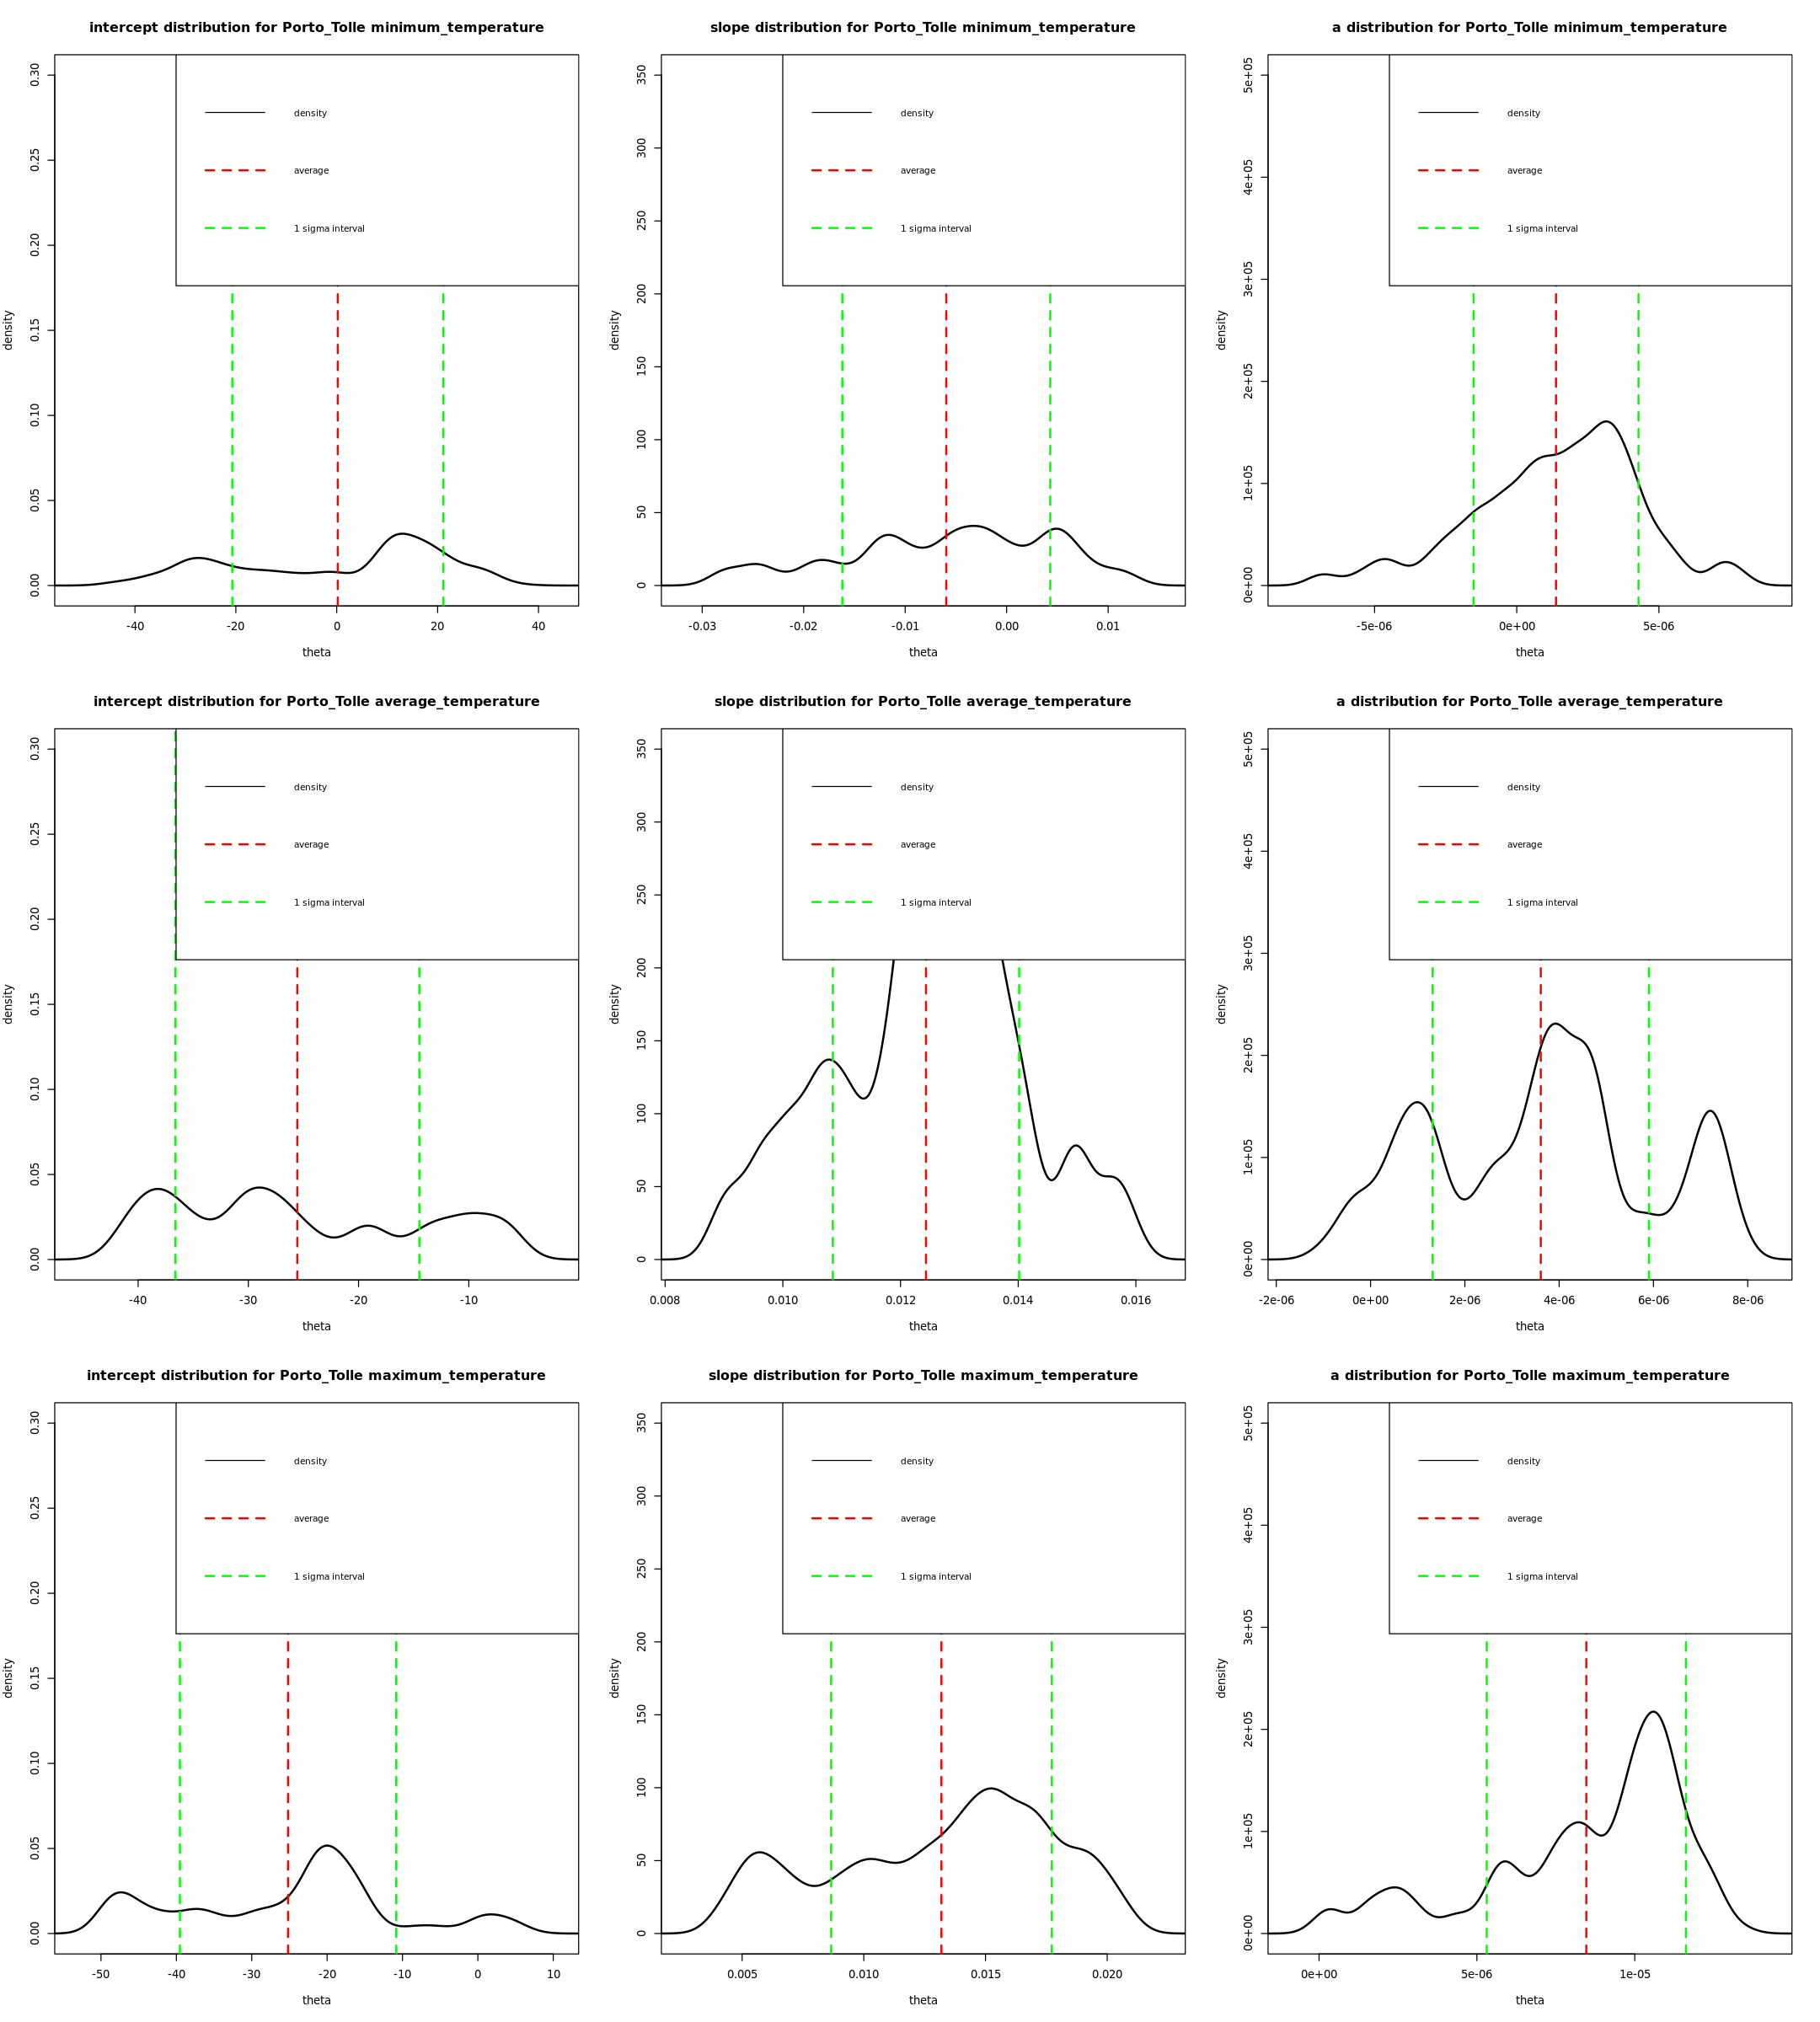

          temperature   slope_mean    slope_sd intercept_mean intercept_sd
1 minimum_temperature -0.018413233 0.016687833     -25.558399    14.596357
2 average_temperature  0.007157236 0.002418197      -8.742275     6.122649
3 maximum_temperature  0.020385713 0.006768539      -3.258044    10.009204
         a_mean         a_sd
1  1.356711e-05 8.320345e-06
2  1.918447e-06 1.789198e-06
3 -2.706179e-07 1.607538e-06


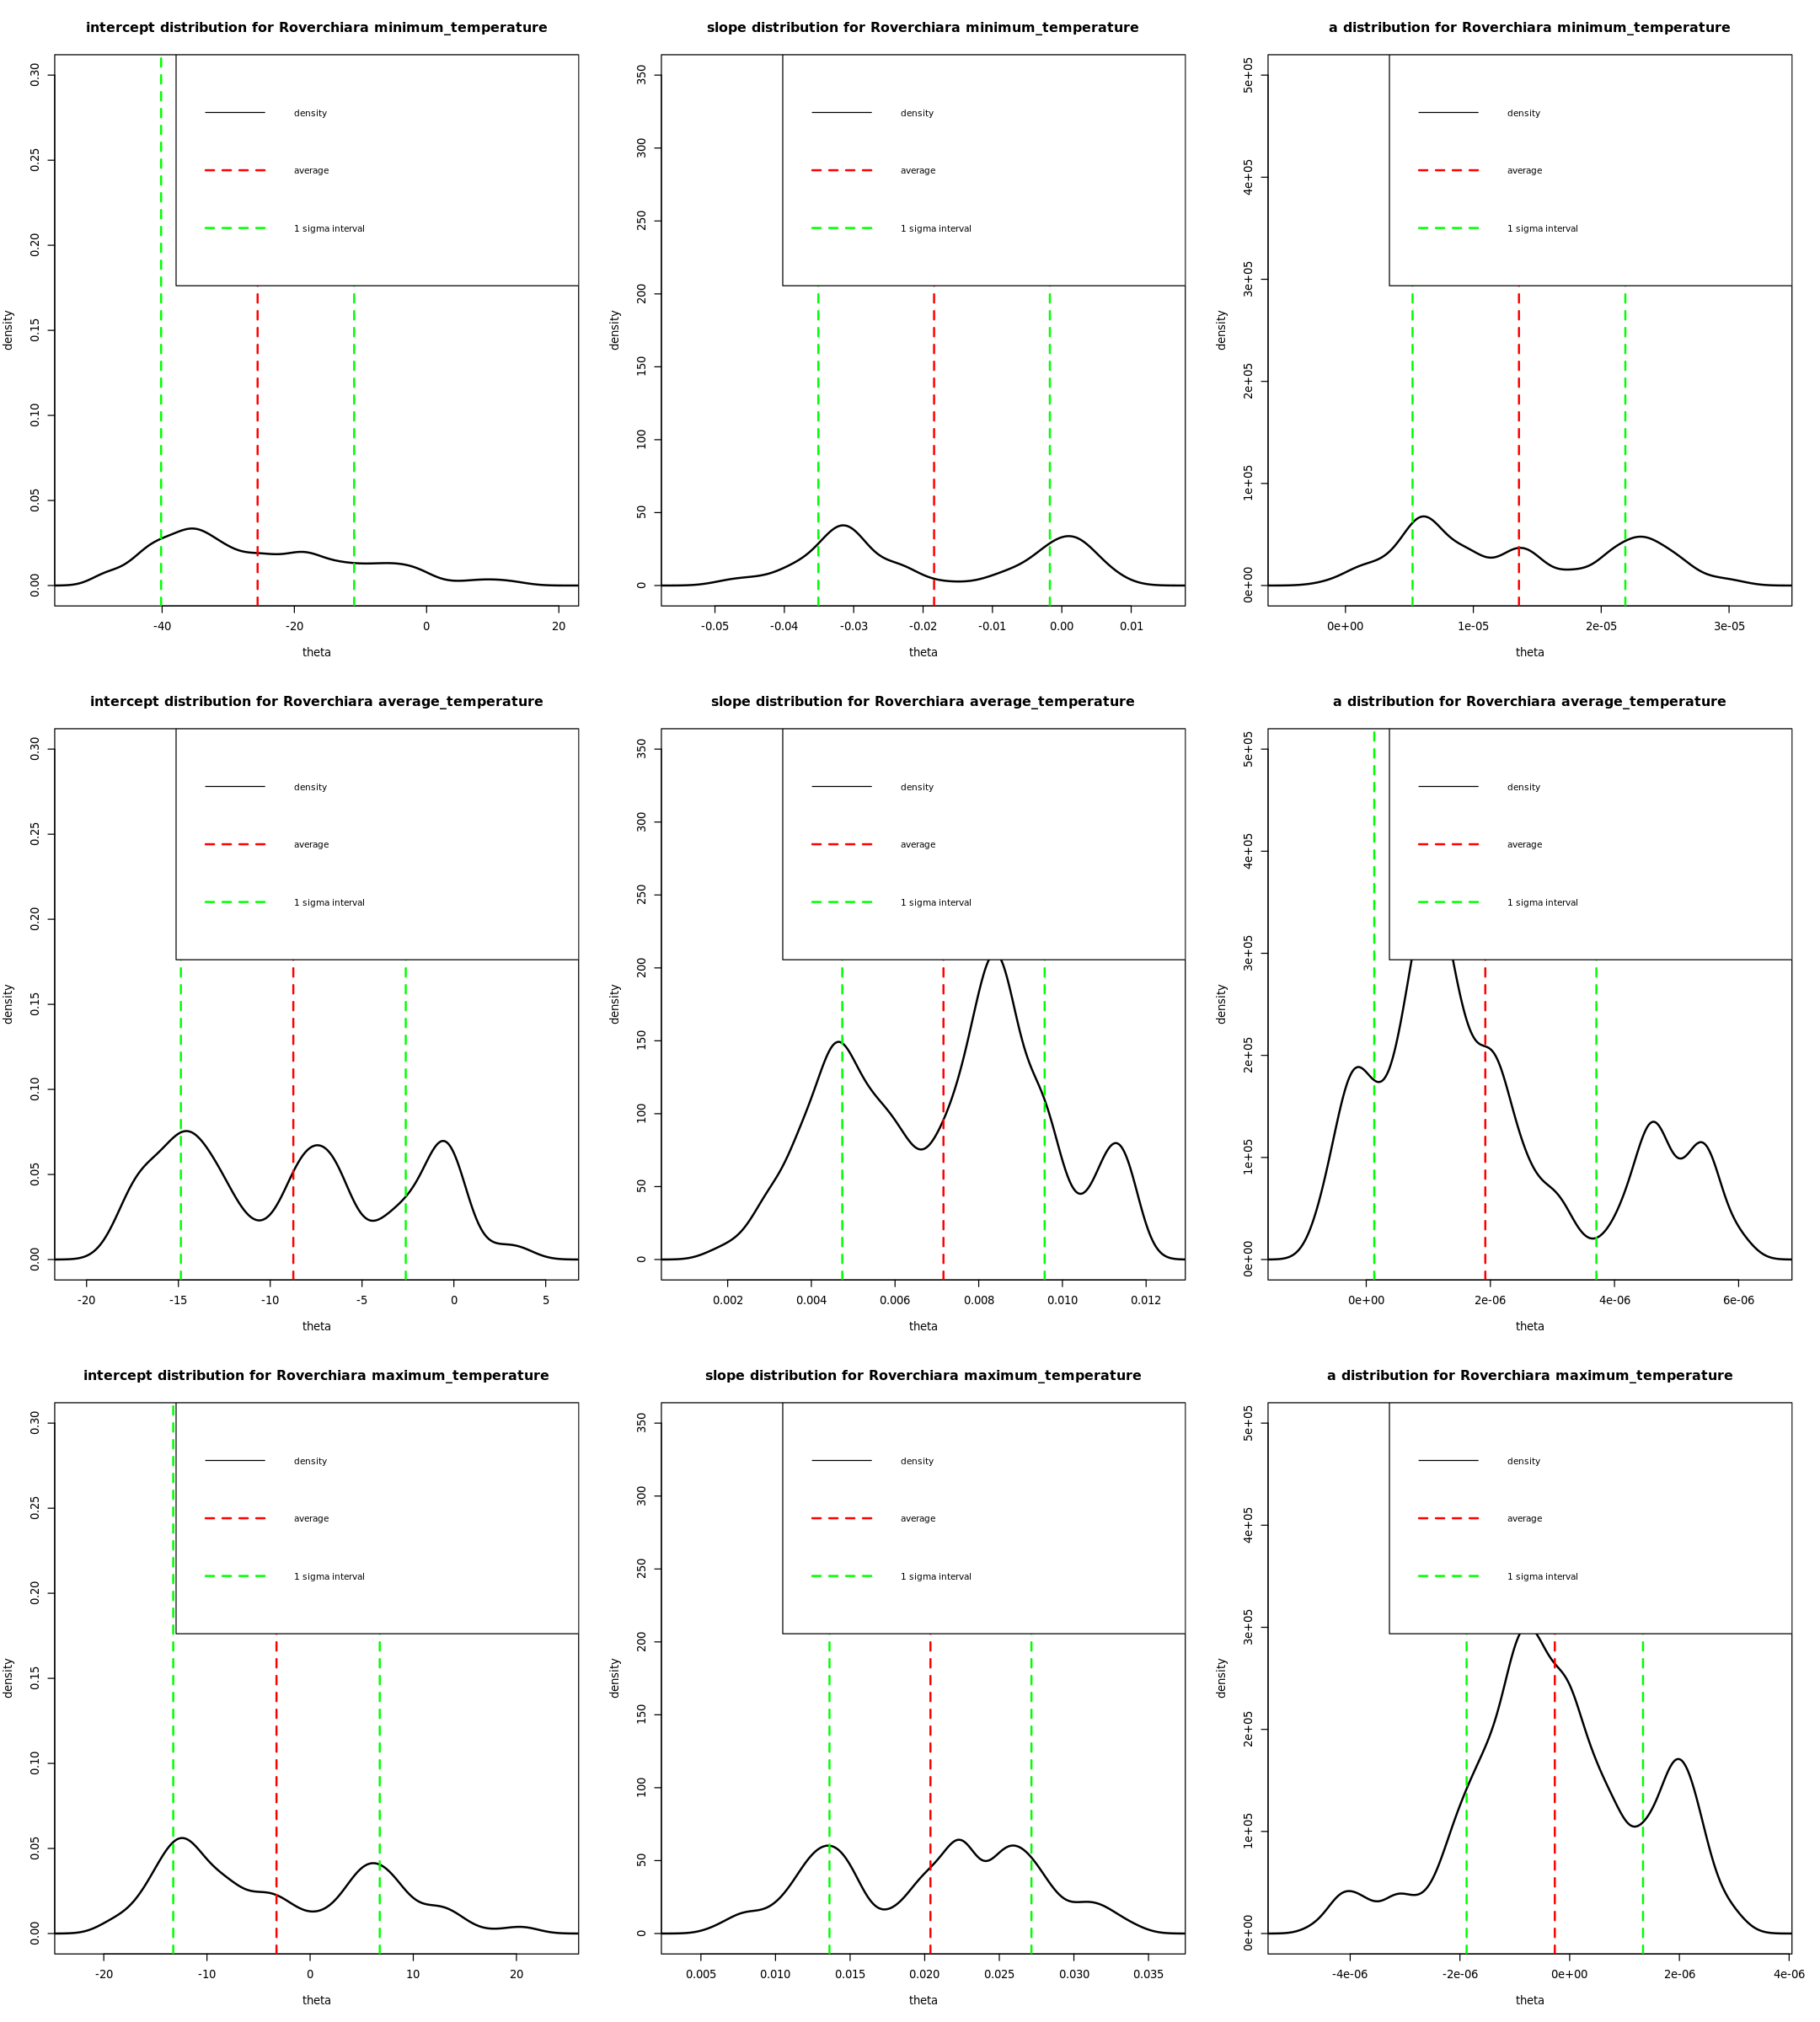

          temperature   slope_mean    slope_sd intercept_mean intercept_sd
1 minimum_temperature -0.005367663 0.007485093      12.743235    10.445235
2 average_temperature  0.011994214 0.002276313     -17.460472     1.864738
3 maximum_temperature  0.019616632 0.005808423       2.069249     3.427347
         a_mean         a_sd
1 -2.422046e-06 4.433438e-06
2  1.802468e-06 9.602831e-07
3 -1.530973e-06 2.935051e-06


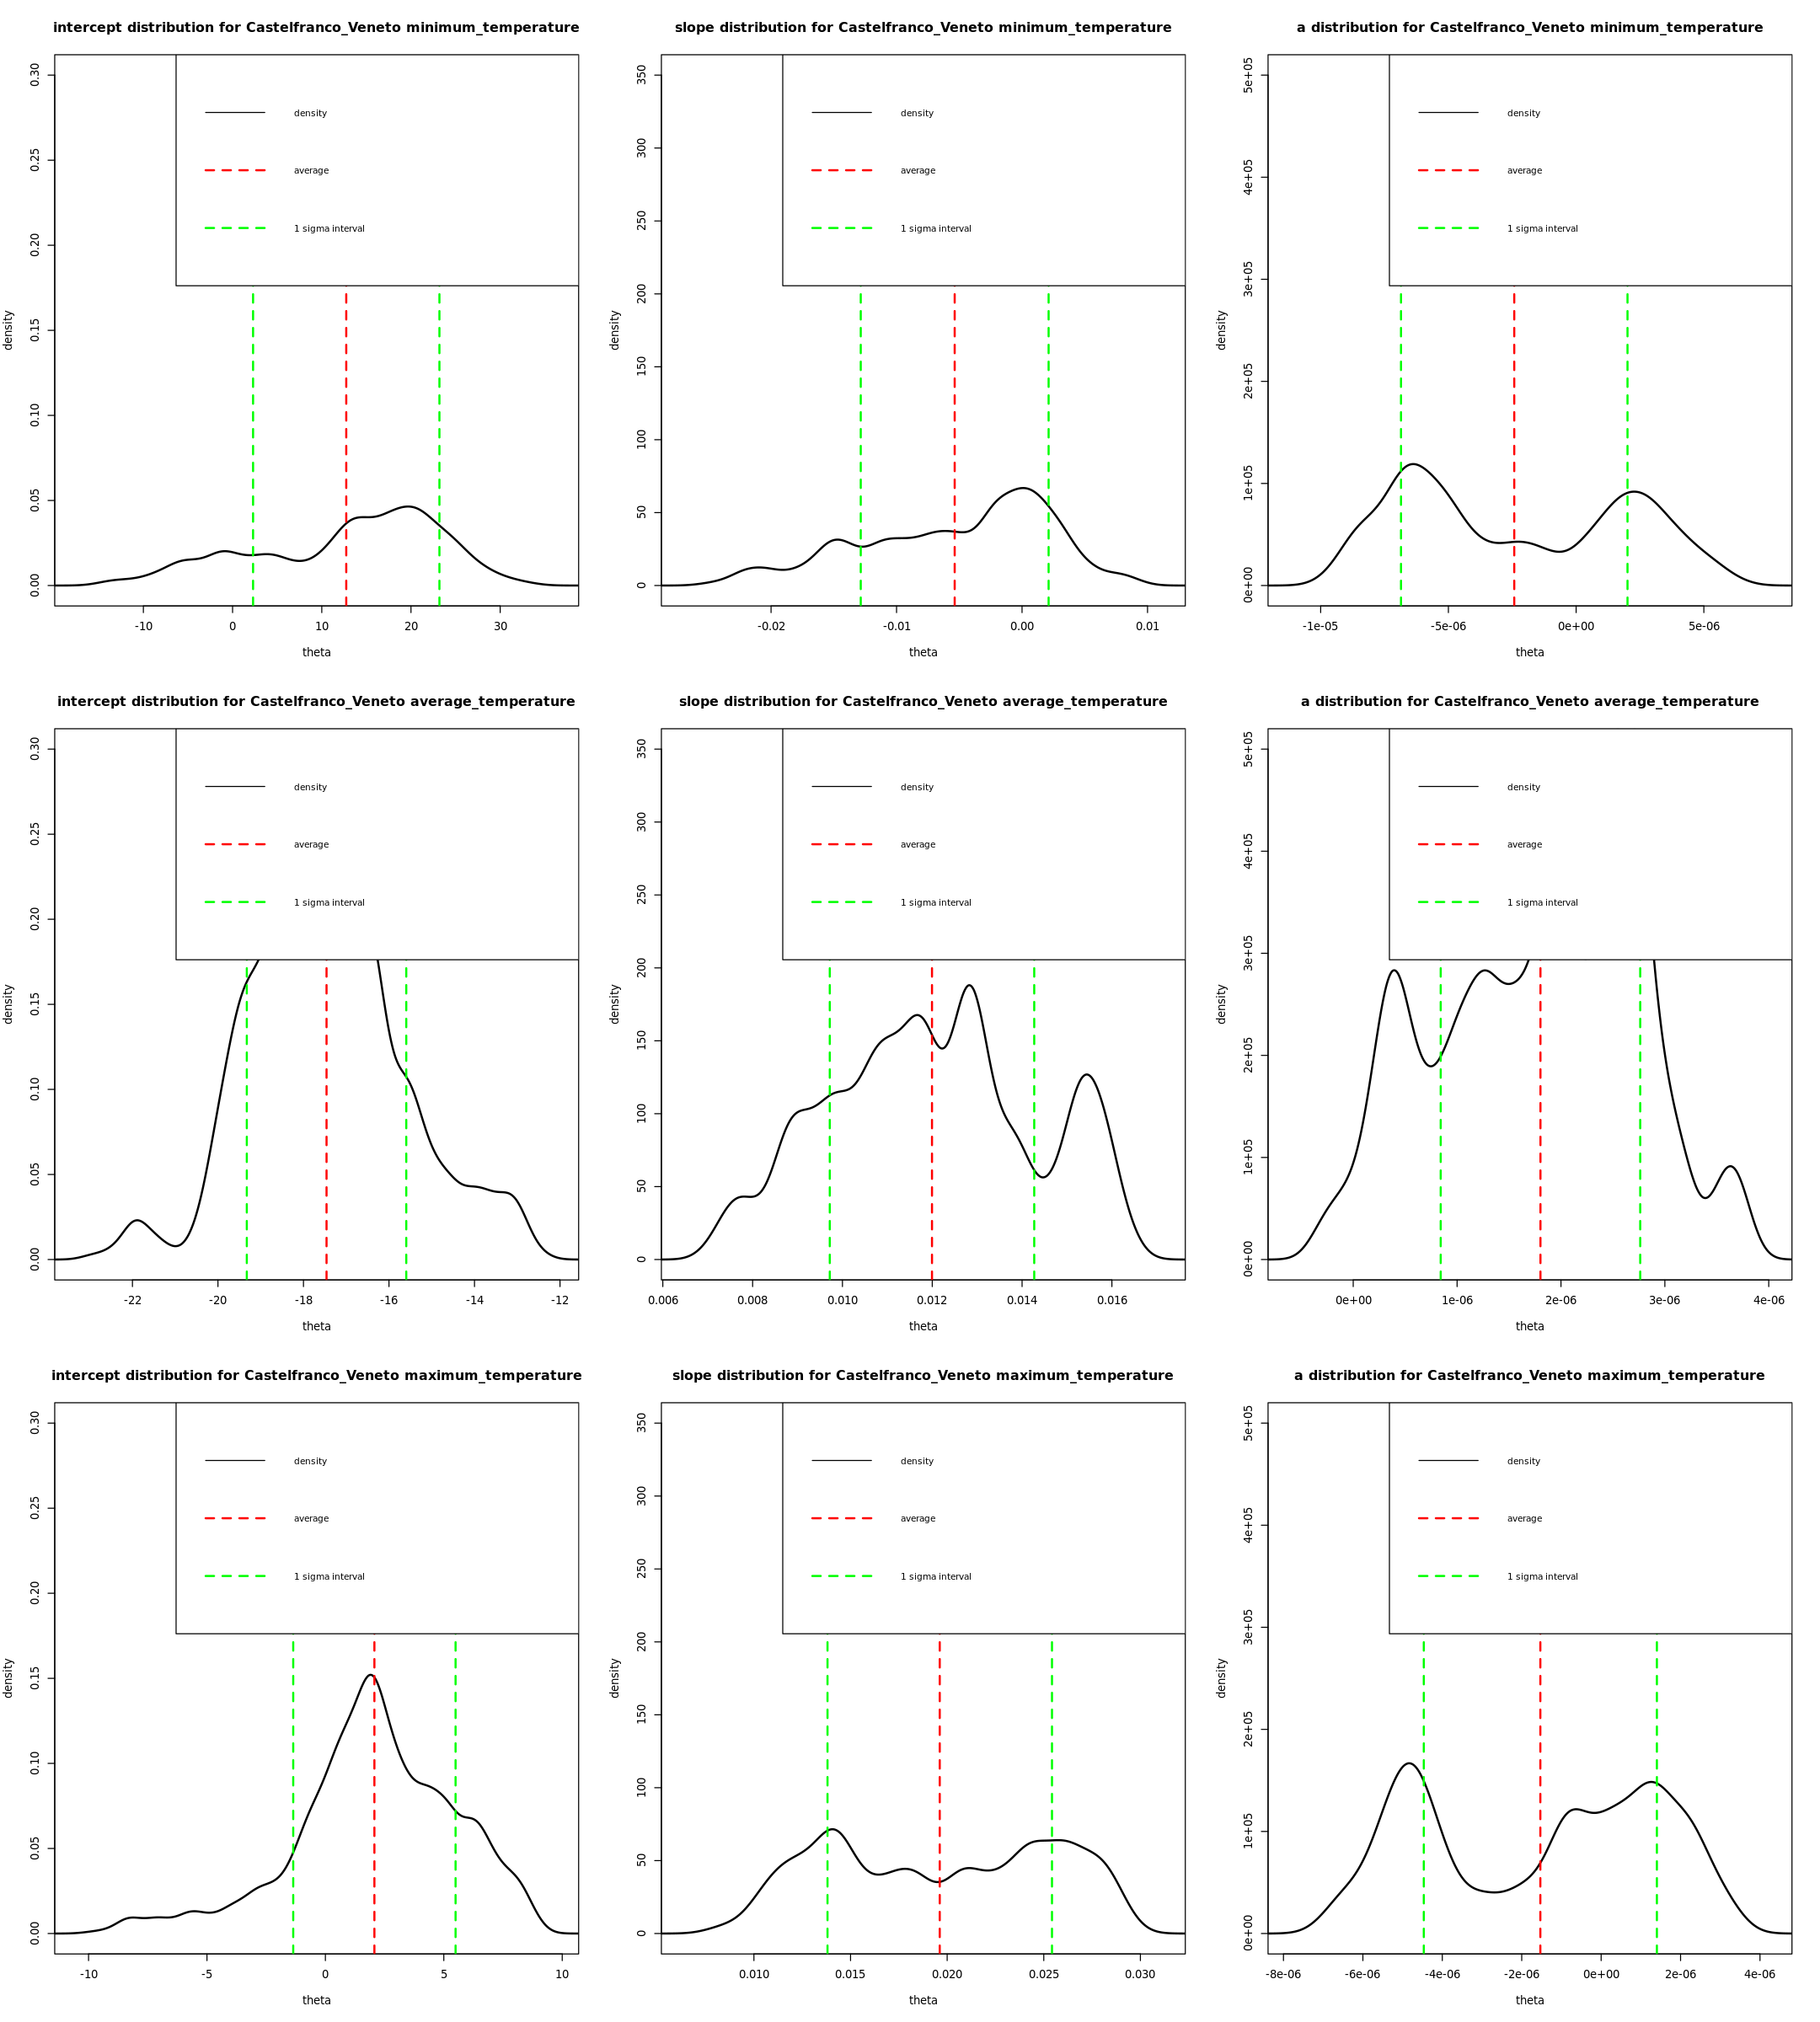

          temperature   slope_mean    slope_sd intercept_mean intercept_sd
1 minimum_temperature -0.022116894 0.016655456     -39.336010     9.476117
2 average_temperature  0.004085672 0.001270514      -4.331837     1.878819
3 maximum_temperature  0.043567242 0.005849472     -41.025819     8.092376
         a_mean         a_sd
1  1.704937e-05 9.488237e-06
2  8.817758e-07 4.338881e-07
3 -3.794843e-06 2.357108e-06


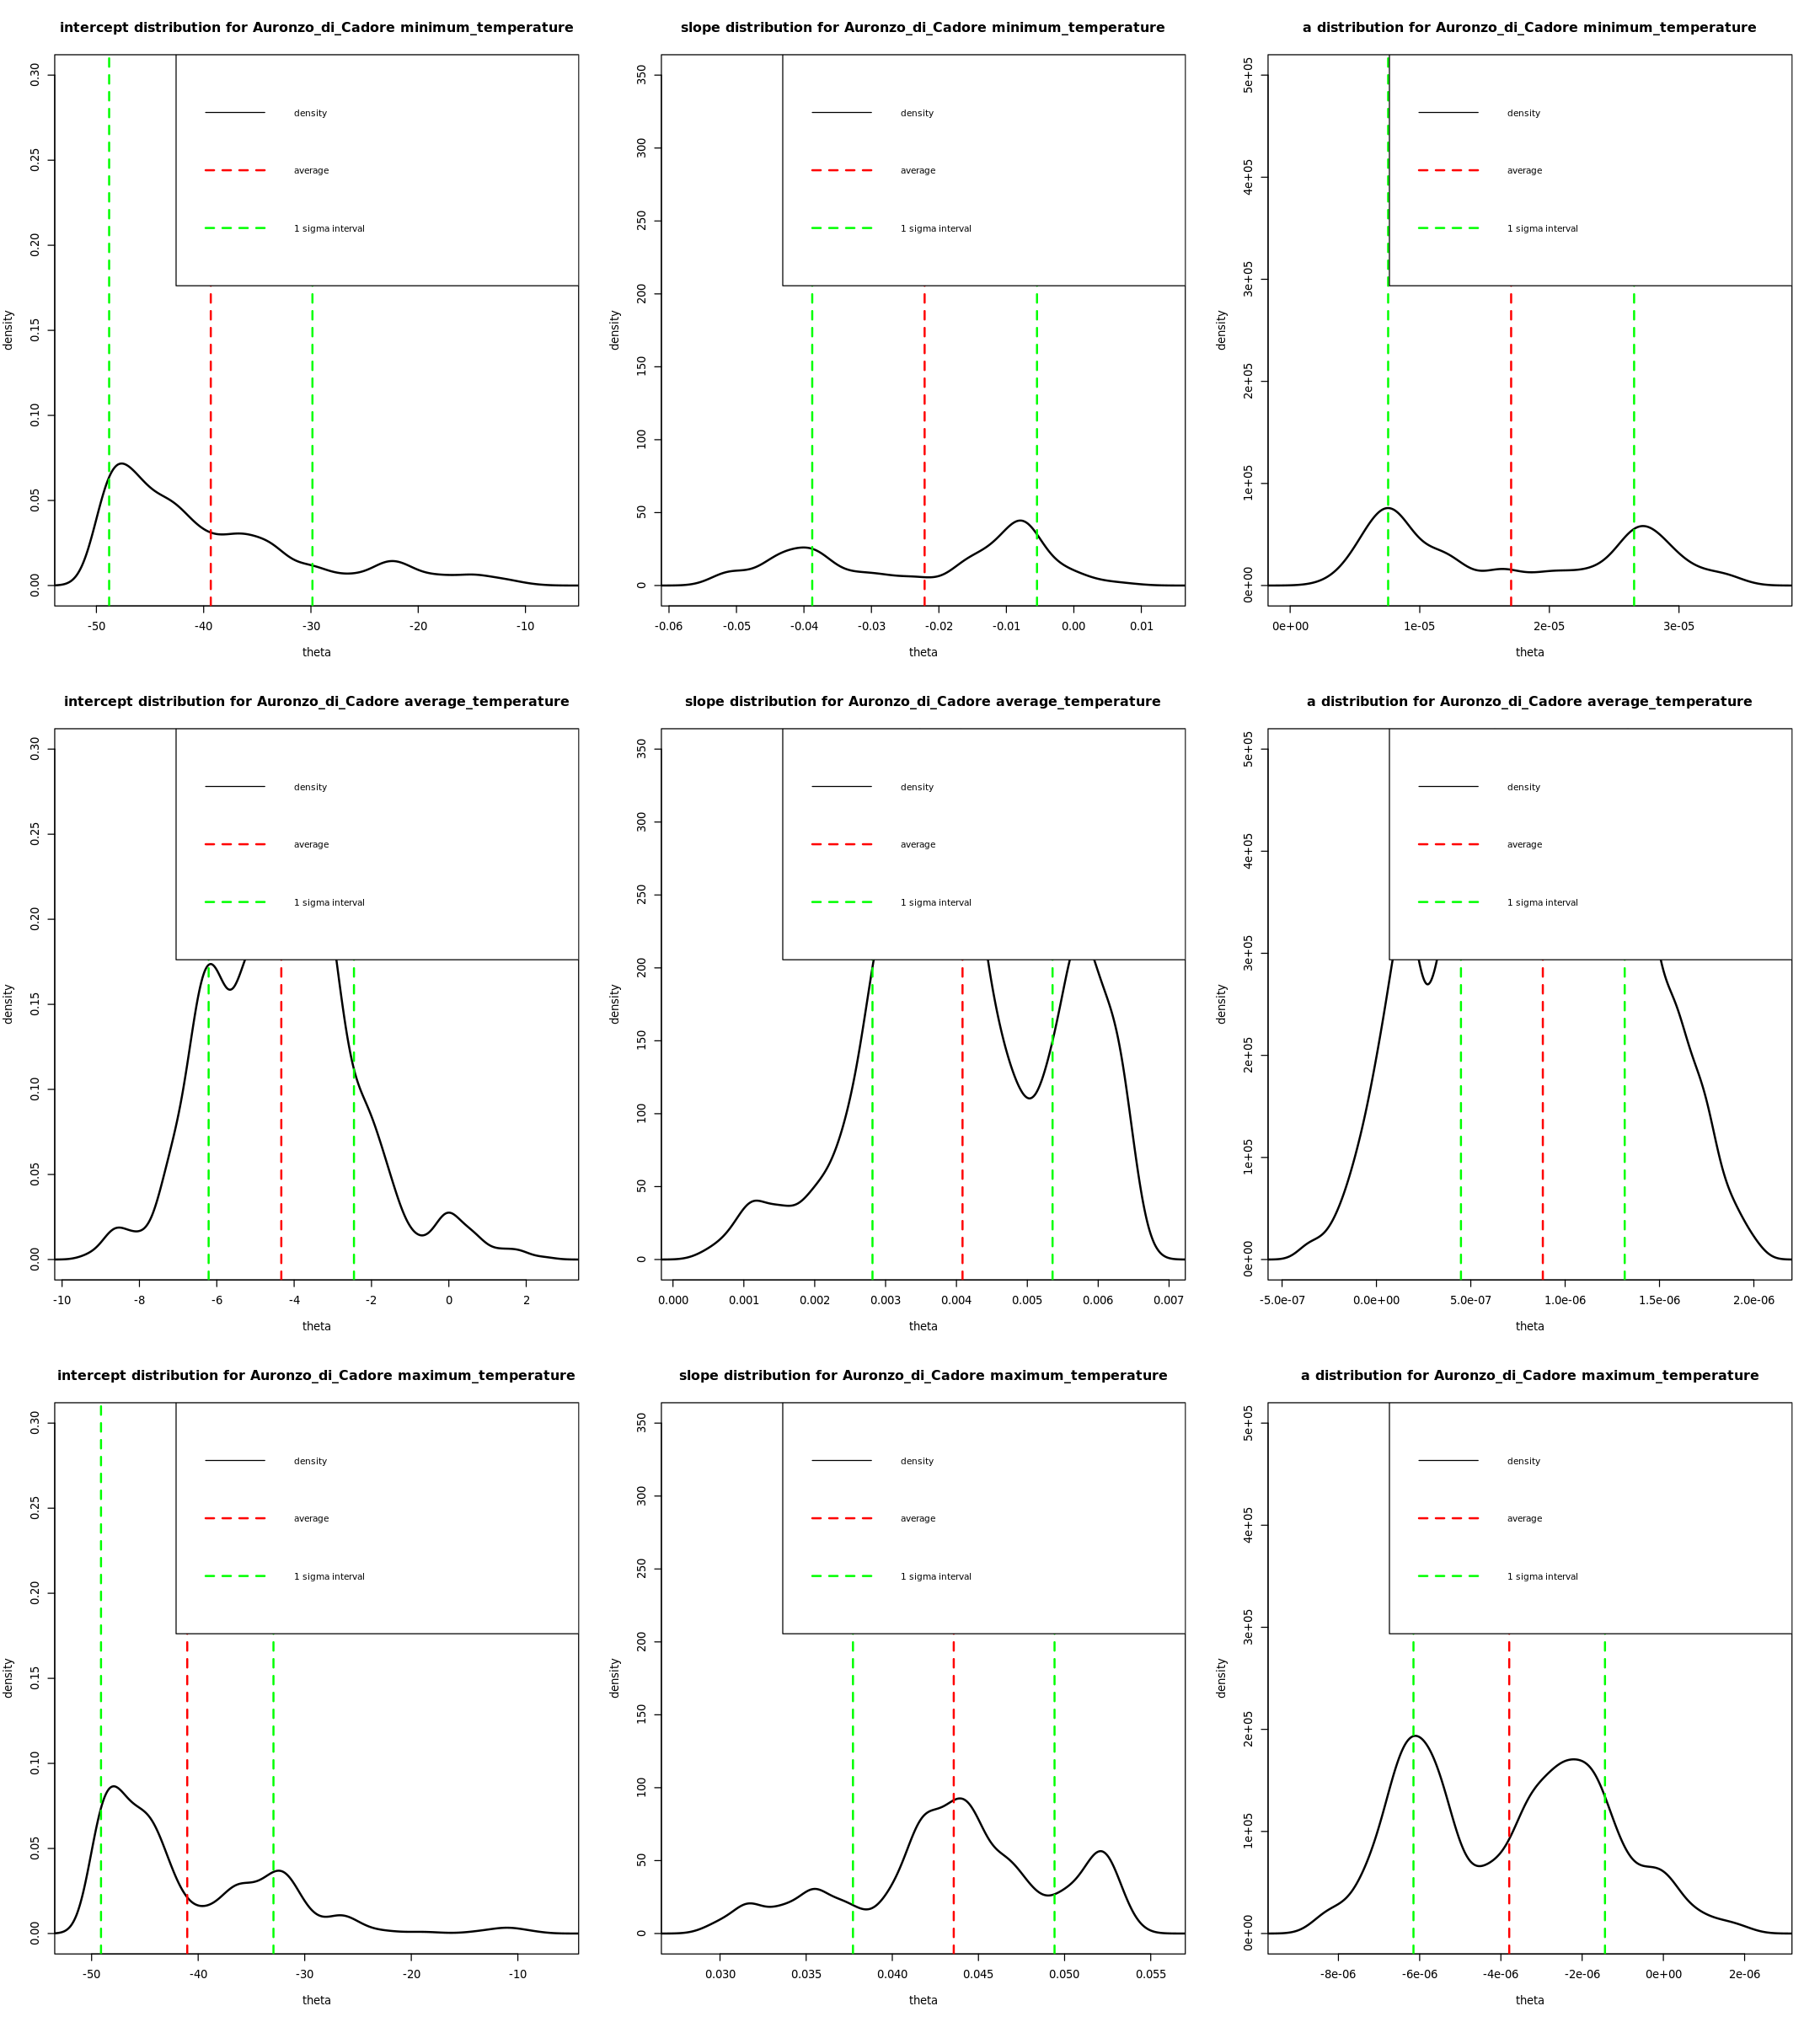

In [26]:
quadratic_regression_dataframe <- data.frame()
for (ln in location_names){
    temp <- my_quadratic_regression(ln)
    temp$location <- rep(c(ln), nrow(temp))
    quadratic_regression_dataframe %>% rbind(temp) -> quadratic_regression_dataframe }
quadratic_regression_dataframe %>% arrange(temperature) -> quadratic_regression_dataframe

In [27]:
quadratic_regression_dataframe

temperature         slope_mean   slope_sd    intercept_mean intercept_sd
1  average_temperature  0.012432630 0.001583532 -25.5589122    11.073874   
2  average_temperature  0.007157236 0.002418197  -8.7422746     6.122649   
3  average_temperature  0.011994214 0.002276313 -17.4604725     1.864738   
4  average_temperature  0.004085672 0.001270514  -4.3318367     1.878819   
5  maximum_temperature  0.013188551 0.004530996 -25.1837710    14.345825   
6  maximum_temperature  0.020385713 0.006768539  -3.2580438    10.009204   
7  maximum_temperature  0.019616632 0.005808423   2.0692489     3.427347   
8  maximum_temperature  0.043567242 0.005849472 -41.0258187     8.092376   
9  minimum_temperature -0.005948267 0.010244578   0.2042922    20.913314   
10 minimum_temperature -0.018413233 0.016687833 -25.5583992    14.596357   
11 minimum_temperature -0.005367663 0.007485093  12.7432346    10.445235   
12 minimum_temperature -0.022116894 0.016655456 -39.3360099     9.476117   
   a_mean        a_sd         location           
1   3.610771e-06 2.295864e-06 Porto_Tolle        
2   1.918447e-06 1.789198e-06 Roverchiara        
3   1.802468e-06 9.602831e-07 Castelfranco_Veneto
4   8.817758e-07 4.338881e-07 Auronzo_di_Cadore  
5   8.465965e-06 3.155207e-06 Porto_Tolle        
6  -2.706179e-07 1.607538e-06 Roverchiara        
7  -1.530973e-06 2.935051e-06 Castelfranco_Veneto
8  -3.794843e-06 2.357108e-06 Auronzo_di_Cadore  
9   1.381219e-06 2.900449e-06 Porto_Tolle        
10  1.356711e-05 8.320345e-06 Roverchiara        
11 -2.422046e-06 4.433438e-06 Castelfranco_Veneto
12  1.704937e-05 9.488237e-06 Auronzo_di_Cadore

This attempt isn't successful either: the distributions are wide and don't have a clear peak. Therefore, the standard deviations of the parameters are of the same order of magnitude of the averages.

Like before, the quadratic method isn't supported by data either, especially because the coefficient of the quadratic term is very close to zero.

Therefore, I decide to go back to square 1 and proceed my analysis with a linear regression, and change instead the dataset by grouping it better.

------

## Part 2: quadrennial analysis

Analysise the evolution of the annual difference of the minimum, maximum and daily average temperature over time (1993 - 2021):
- assuming you found an increasing trend in the temperature, compute it considering 4-years intervals and compare the results with those shown in SNPA (Sistema Nazionale per la Protezione Ambiente) in [1].
- perform an analysis using a Bayesian linear regression with JAGS or STAN

I change the dataset by grouping the data that I have based on the quadrennium that they fall into. This should reduce noise and improve readability of the plots. I will still keep the three types of temperatures separate, since they follow different trends. For each temperature, I will try, when possible, to keep 

In [28]:
# for each location
for (ln in 1:length(location_names)){
    # I filter the dataframe
    get(location_names[ln]) %>% 
        # based on the quadrennium and month (since I still want to keep information about all months)
        group_by(quadrennium) %>% 
        # and retrieve the pieces of information that I need
        summarise(minimum_temperature_std = sd(minimum_temperature)/sqrt(n()),
                  minimum_temperature = min(minimum_temperature),
                  average_temperature_std = sd(average_temperature)/sqrt(n()),
                  average_temperature = mean(average_temperature), 
                  maximum_temperature_std = sd(maximum_temperature)/sqrt(n()),
                  maximum_temperature = max(maximum_temperature) ) -> temp
    temp["location"] <- as.factor(rep(c(location_names[ln]), nrow(temp) )) 
    # and save the result under a new name
    assign(paste(location_names[ln],'_quadrennium', sep=''), temp) }

In [29]:
options(repr.plot.width=18, repr.plot.height=20)

all_names = c()
for (ln in 1:length(location_names)){
    
    df = get(paste(location_names[ln],'quadrennium',sep='_'))
    basic_plot_temp <- ggplot(df, aes(x=quadrennium))

    minimum_plot_temp <- basic_plot_temp +
                         geom_point(aes(y=minimum_temperature)) +
                         geom_path(aes(y=minimum_temperature, group=1)) +
                         geom_errorbar(aes(ymin=minimum_temperature-minimum_temperature_std, 
                                       ymax=minimum_temperature+minimum_temperature_std), width=.2) +
                         ggtitle(location_names[ln]) +
                         theme(legend.position = "none", axis.text.x = element_text(size=8, angle=45))
    minimum_name <- paste(location_names[ln],'minimum_plot',sep='_')
    assign(minimum_name, minimum_plot_temp)

    average_plot_temp <- basic_plot_temp + 
                         geom_point(aes(y=average_temperature)) +
                         geom_path(aes(y=average_temperature, group=1)) +
                         geom_errorbar(aes(ymin=average_temperature-average_temperature_std, 
                                       ymax=average_temperature+average_temperature_std), width=.2) +
                         theme(legend.position = "none", axis.text.x = element_text(size=8, angle=45))
    average_name <- paste(location_names[ln],'average_plot',sep='_')
    assign(average_name, average_plot_temp)

    maximum_plot_temp <- basic_plot_temp + 
                         geom_point(aes(y=maximum_temperature)) +
                         geom_path(aes(y=maximum_temperature, group=1)) +
                         geom_errorbar(aes(ymin=maximum_temperature-maximum_temperature_std, 
                                      ymax=maximum_temperature+maximum_temperature_std), width=.2) +
                         theme(axis.text.x = element_text(size=8, angle=45)) +
                         guides(fill=guide_legend(title="month"))
    maximum_name <- paste(location_names[ln],'maximum_plot',sep='_')
    assign(maximum_name, maximum_plot_temp)

    all_names <- c(all_names, minimum_name, average_name, maximum_name) }

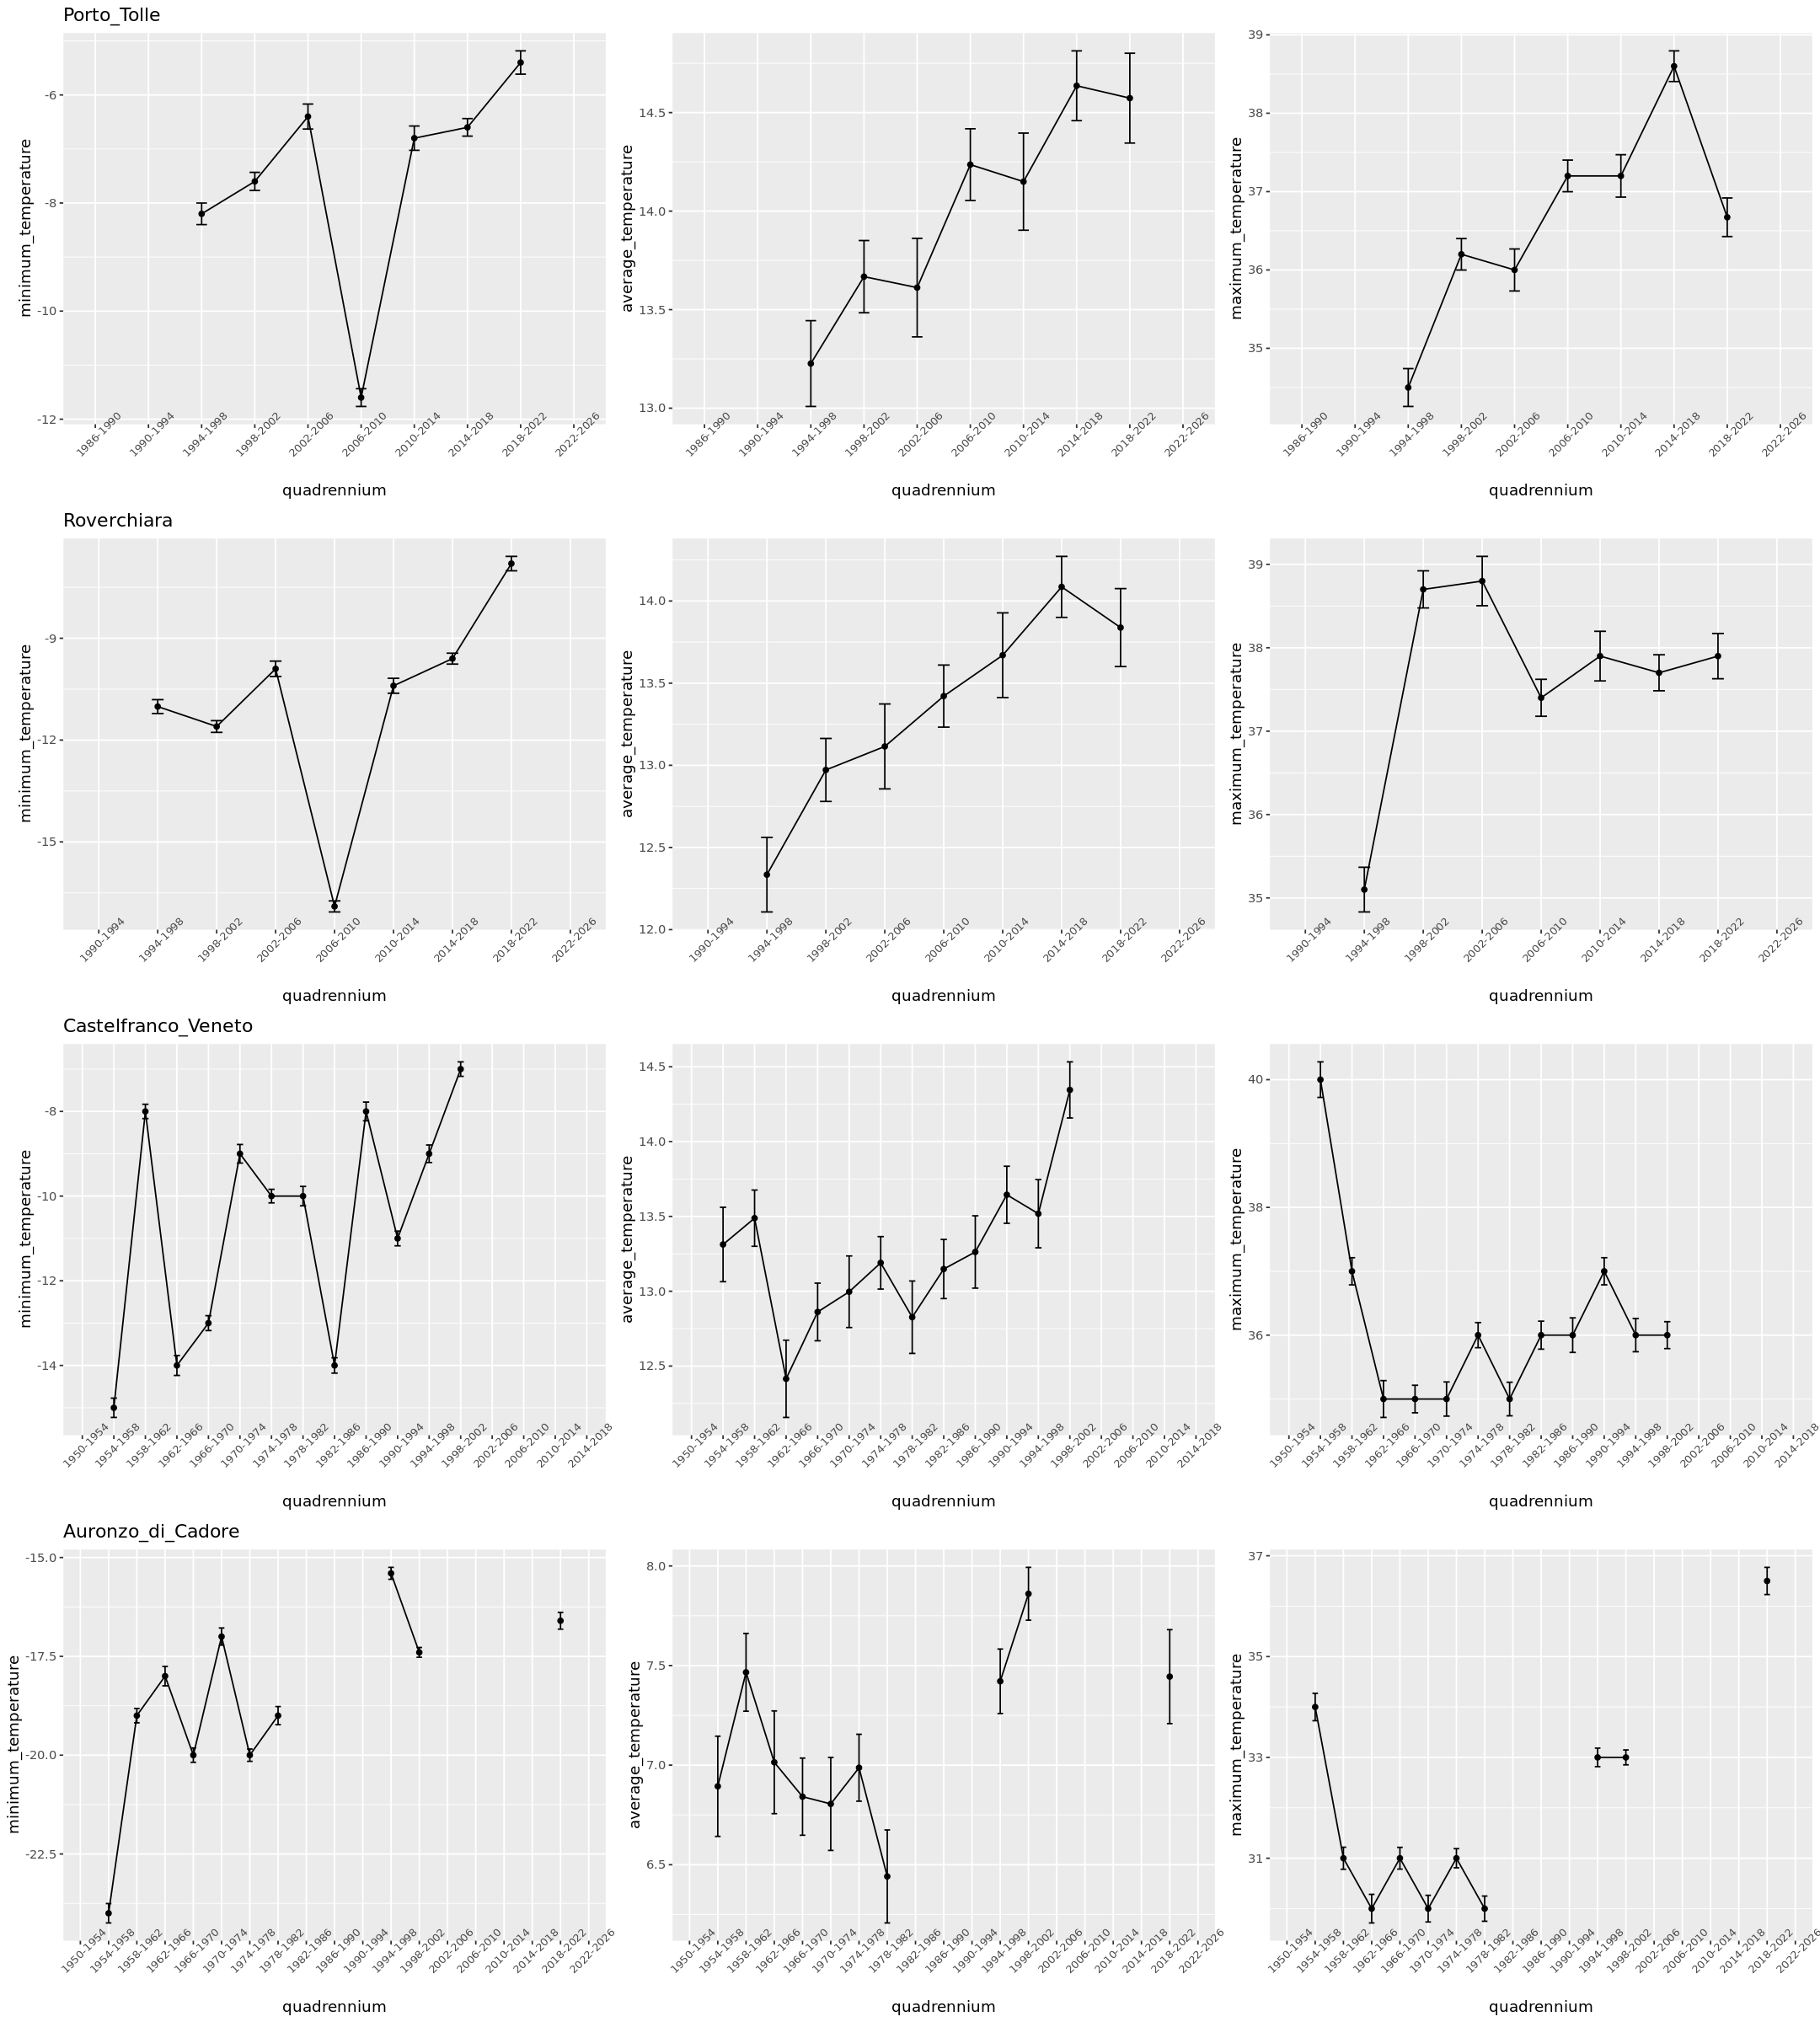

In [30]:
figure <- ggarrange(Porto_Tolle_minimum_plot, Porto_Tolle_average_plot, Porto_Tolle_maximum_plot,
                    Roverchiara_minimum_plot, Roverchiara_average_plot, Roverchiara_maximum_plot,
                    Castelfranco_Veneto_minimum_plot, Castelfranco_Veneto_average_plot, Castelfranco_Veneto_maximum_plot,
                    Auronzo_di_Cadore_minimum_plot, Auronzo_di_Cadore_average_plot, Auronzo_di_Cadore_maximum_plot,
                    ncol = 3, nrow = 4)

The data seems more promissing since it's less noisy. I will now perform the linear regression, keeping the three types of temperatures separate. The results from this sections will be compared to the ones in the SNPA report in the Conclusions section.

In [31]:
my_final_linear_regression <- function(location){
    #function that executes a linear regression over the dataframe which name is related to the input string "location"
    # I prepare the plot
    options(repr.plot.width=18, repr.plot.height=20)
    par( mfrow=c(3,2) )
    # for the specific location
    input_df <- na.omit(get(paste(location,'quadrennium',sep='_')))
    temperature_names <- c('minimum_temperature', 'average_temperature', 'maximum_temperature')
    location_record <- data.frame()
    # for every temperature I examine
    for (temperature in temperature_names){
        # I prepare the data to be fed to the model
        data_list <- list(
          x = subset(input_df, select = c('quadrennium'))[[1]],
          y = subset(input_df, select = c(temperature))[[1]],
          N = nrow( subset(input_df, select = c(temperature)) ) )
        # I initialize the model
        model <- jags.model(textConnection(model_text_linear_regression), data = data_list, quiet = TRUE) 
        # and run the simulation for a certain number of iterations and with a certain burn in
        samples <- coda.samples(model, variable.names = c("beta_0", "beta_1"), n.iter = 10000, n.burnin = 1000) 
        # I save the results in a dataframe
        df <- as.data.frame( as.mcmc(samples) )
        # and retrieve the important information
        invisible( s <- summary(samples) )
        # such as the mean and standard deviation of each parameter
        average <- s$statistics[1,1]
        sigma <- s$statistics[1,2]
#         cat('the intercept estimated from the', temperature,'is: ',
#             round(average,1) , '±', round(sigma,1),'years. \n')
        # I compute the distribution of the parameters
        dens <- density( df$beta_0 ) 
        # to represent it
        plot(dens$x , dens$y, type="l", lwd=2, xaxs="i", col="black", ylim=c(0,2), xlab='theta', ylab="density",
                main = paste('intercept distribution for', location, temperature, sep=' '))
        # together with the mean
        abline(v=average, col='red', lwd=2, lty=2)
        # and the 1 sigma interval around it
        abline(v=average+sigma, col='green', lwd=2, lty=2)
        abline(v=average-sigma, col='green', lwd=2, lty=2)
        legend('topright', legend=c("density","average","1 sigma interval"), col=c('black','red','green'), lty = c(1, 2, 2), 
               lwd=c(1, 2, 2), ncol=2, cex=0.8)

        average <- s$statistics[2,1]
        sigma <- s$statistics[2,2]
#         cat('the slope estimated from the', temperature,'is: ',
#             round(average,4) , '±', round(sigma,4), '°C/year. \n')
        dens <- density( df$beta_1 ) 
        plot(dens$x , dens$y, type="l", lwd=2, xaxs="i", col="black", ylim=c(0,5), xlab='theta', ylab="density",
                main = paste('slope distribution for', location, temperature, sep=' '))
        abline(v=average, col='red', lwd=2, lty=2)
        abline(v=average+sigma, col='green', lwd=2, lty=2)
        abline(v=average-sigma, col='green', lwd=2, lty=2)
        legend('topright', legend=c("density","average","1 sigma interval"), col=c('black','red','green'), lty = c(1, 2, 2), 
               lwd=c(1, 2, 2), ncol=2, cex=0.8)
        
        location_record %>% rbind(data.frame(temperature = temperature, 
                                             slope_mean = s$statistics[2,1]/4, slope_sd = s$statistics[2,2]/4,
                                             intercept_mean = s$statistics[1,1]/4, intercept_sd = s$statistics[1,2]/4)) -> location_record
    }
    print(location_record)
    return(location_record)
}

          temperature slope_mean   slope_sd intercept_mean intercept_sd
1 minimum_temperature -0.2906405 0.07354527      0.1161945   0.07248515
2 average_temperature  0.5120843 0.07721855      0.1349537   0.07224965
3 maximum_temperature  1.3653113 0.21404511      0.1296672   0.07257195


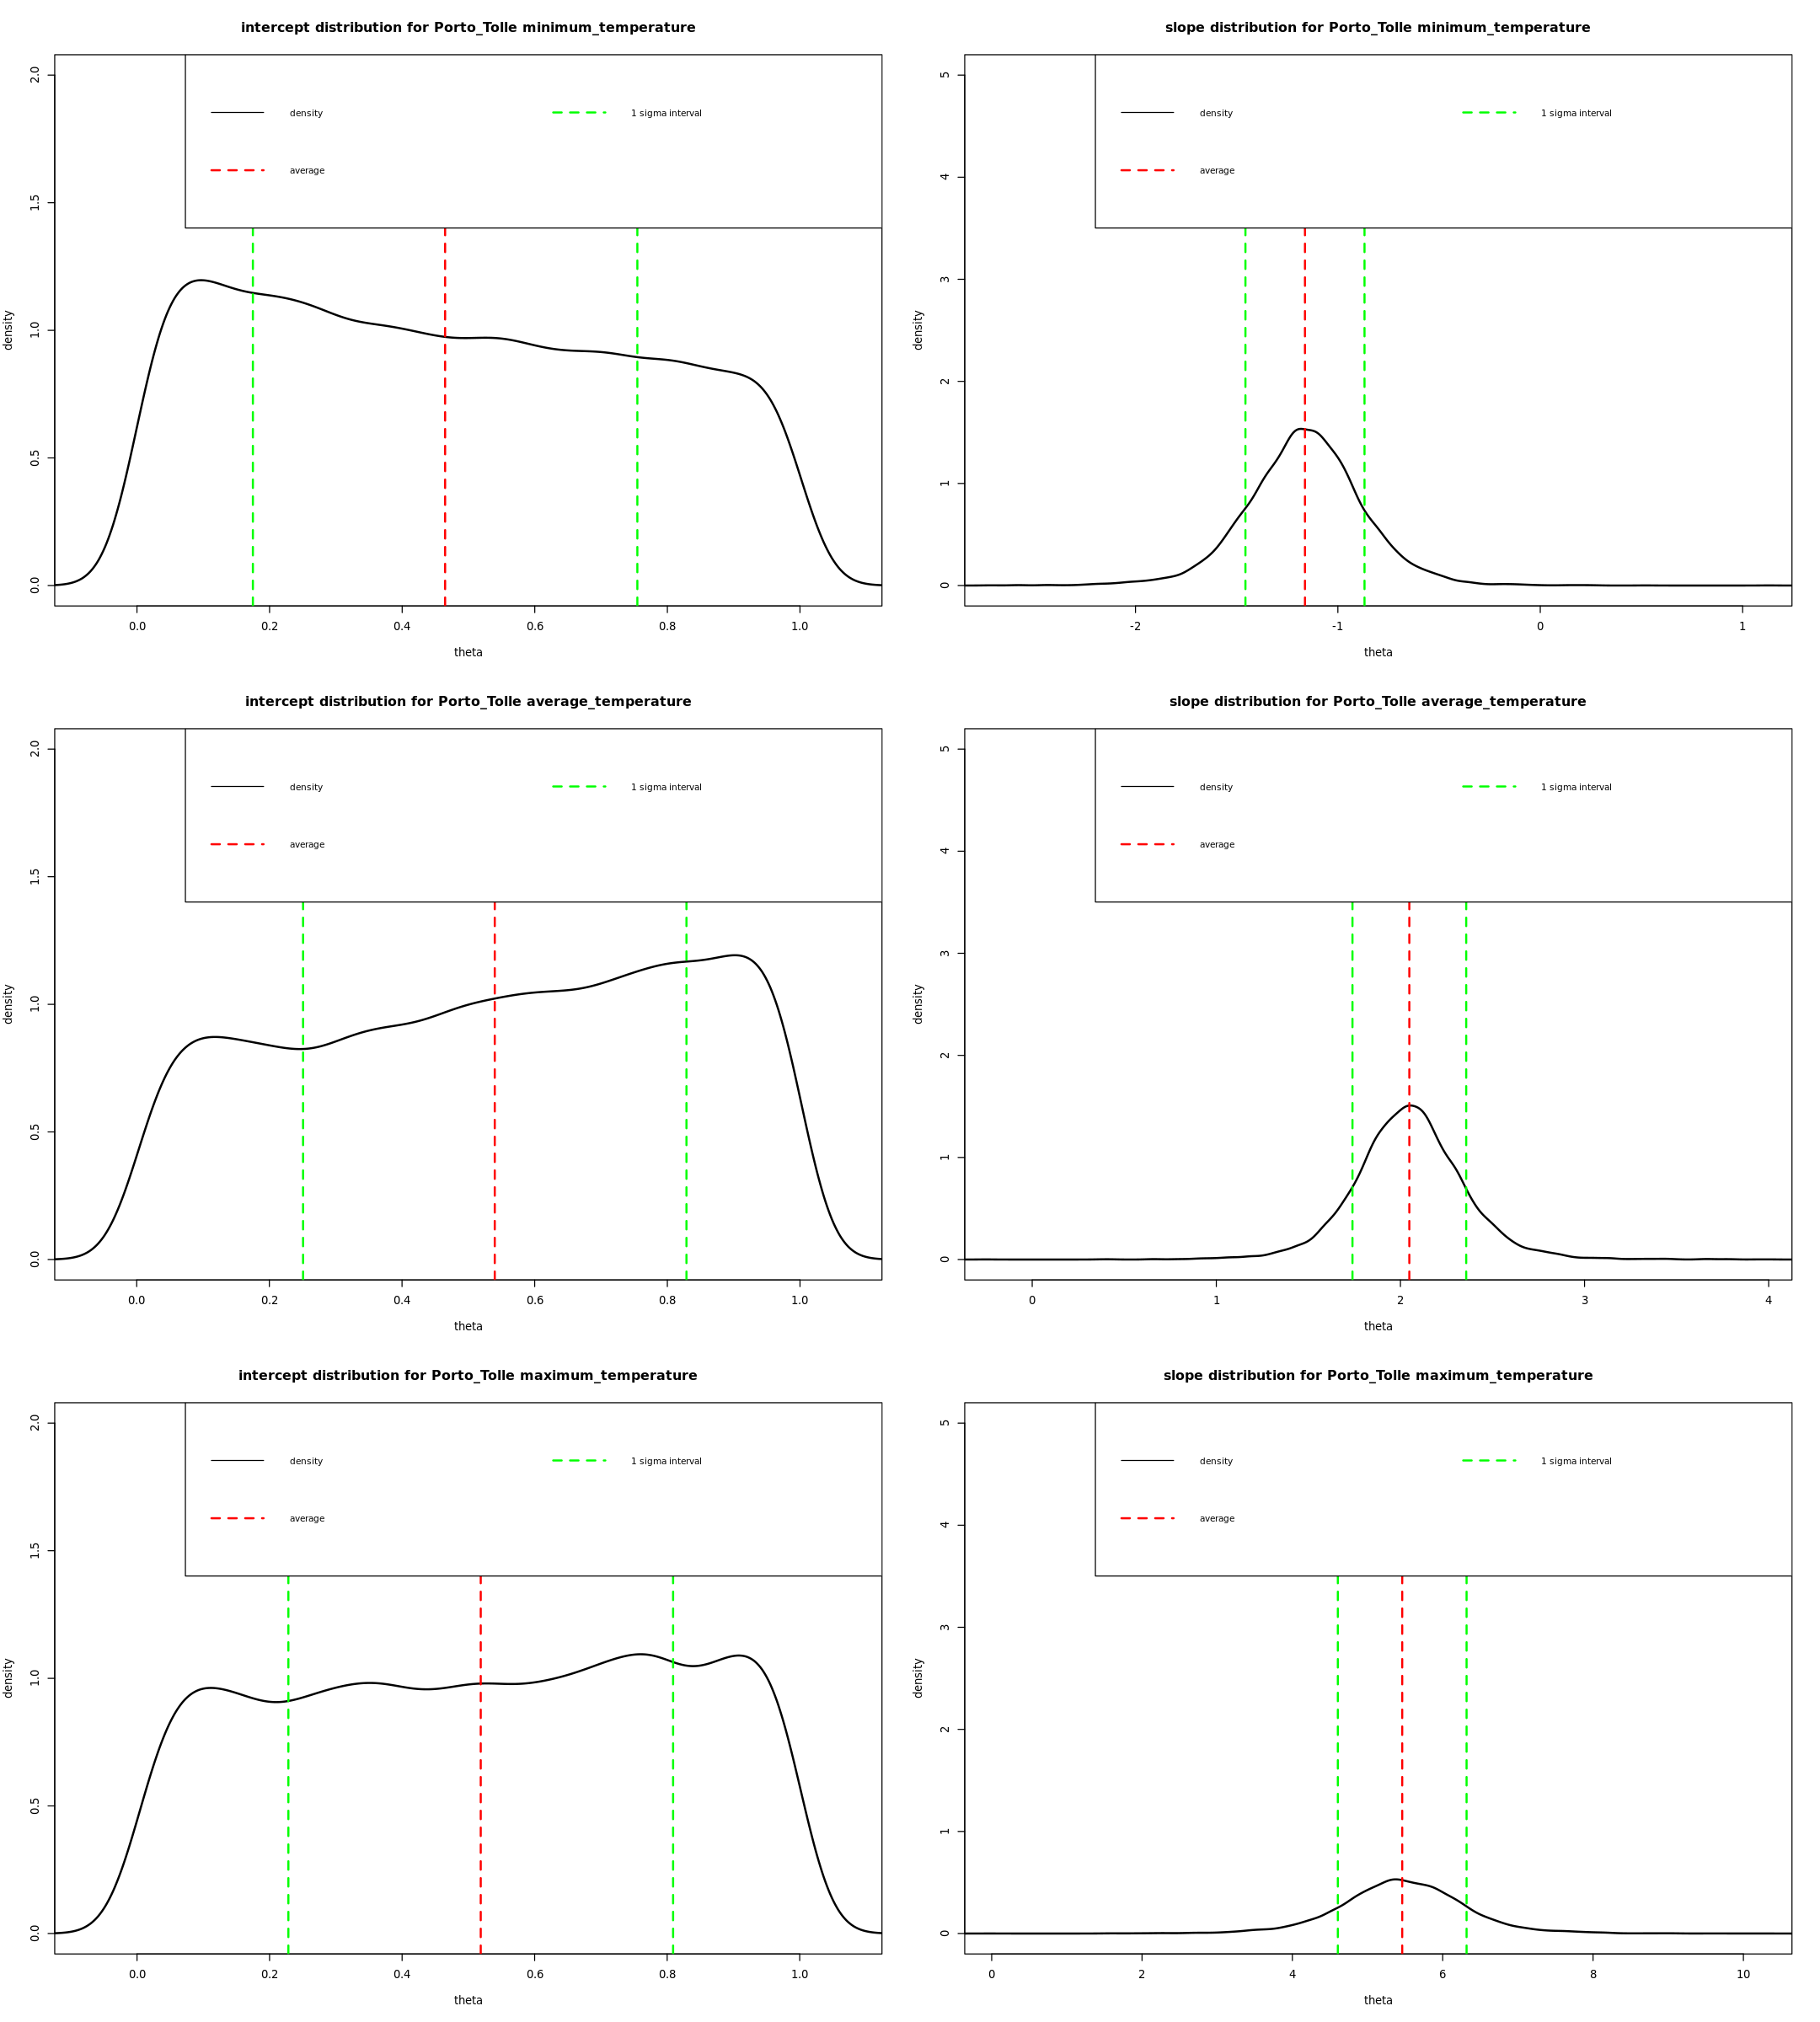

          temperature slope_mean   slope_sd intercept_mean intercept_sd
1 minimum_temperature -0.4678071 0.13592941      0.1163435   0.07258241
2 average_temperature  0.5614853 0.09931839      0.1347444   0.07136541
3 maximum_temperature  1.6075887 0.31774228      0.1278317   0.07216875


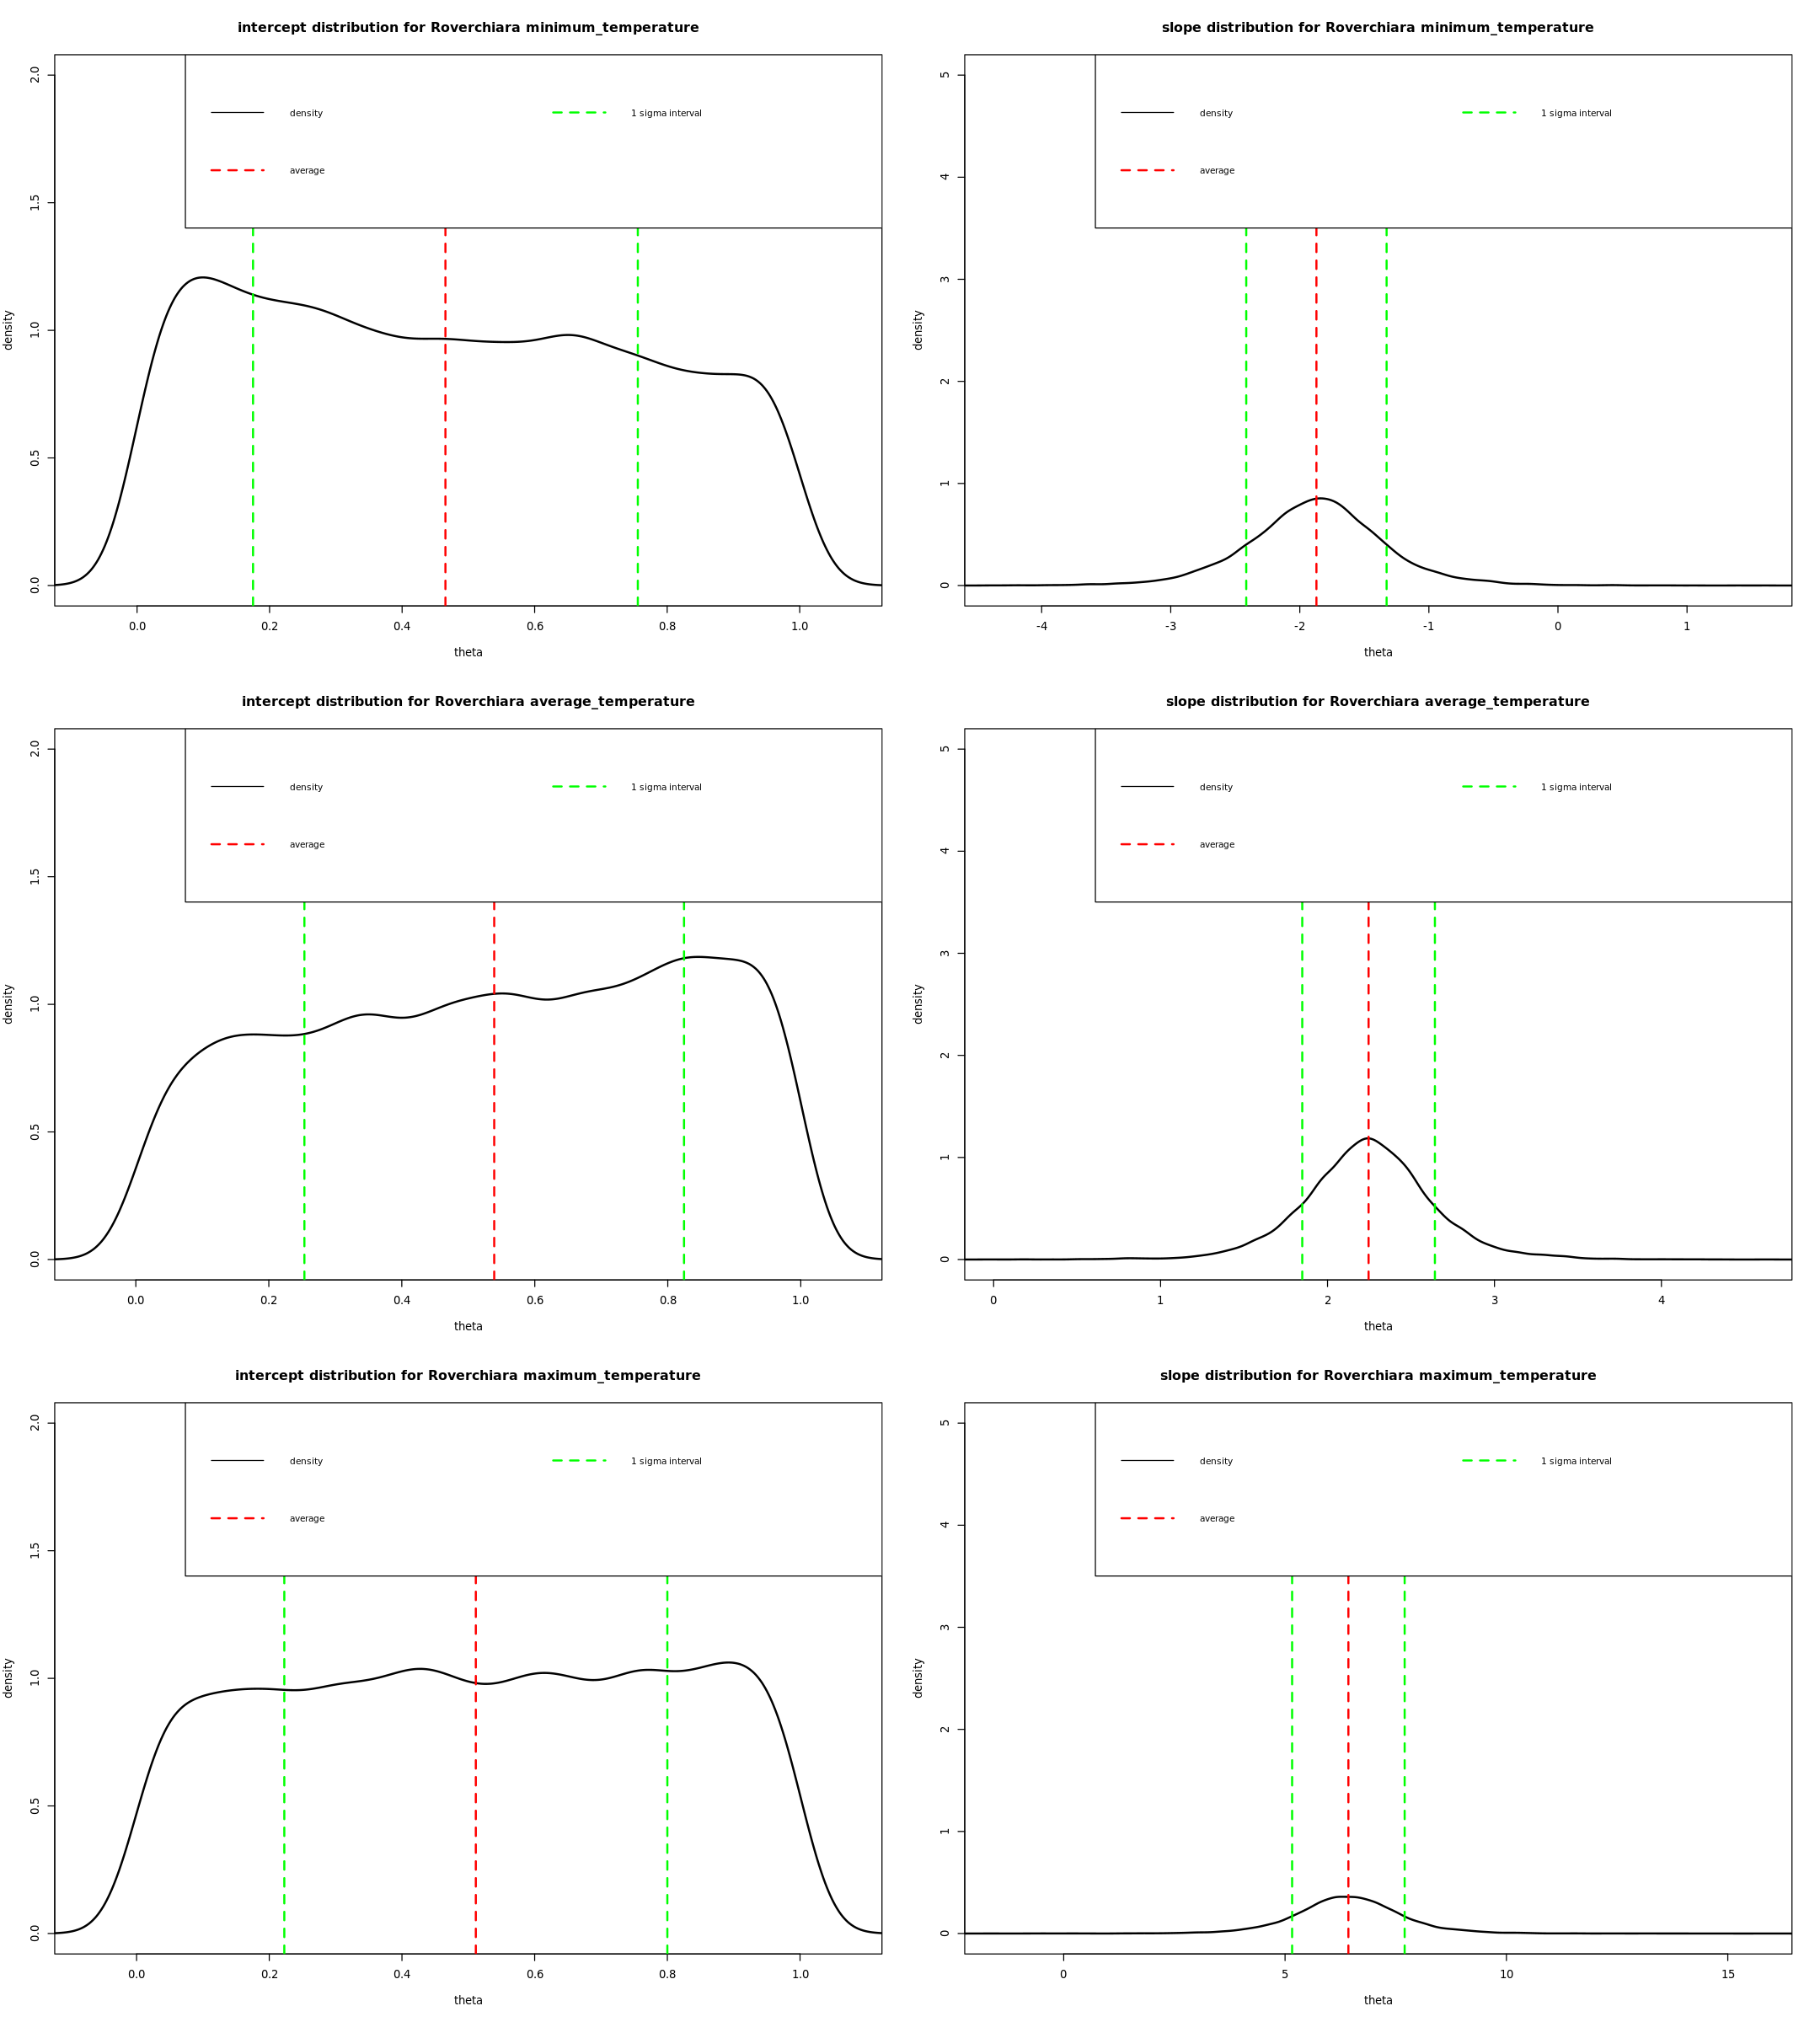

          temperature slope_mean   slope_sd intercept_mean intercept_sd
1 minimum_temperature -0.2895802 0.06210724      0.1114319   0.07132803
2 average_temperature  0.3524691 0.05122405      0.1444151   0.07139712
3 maximum_temperature  0.9784016 0.15383506      0.1313937   0.07216497


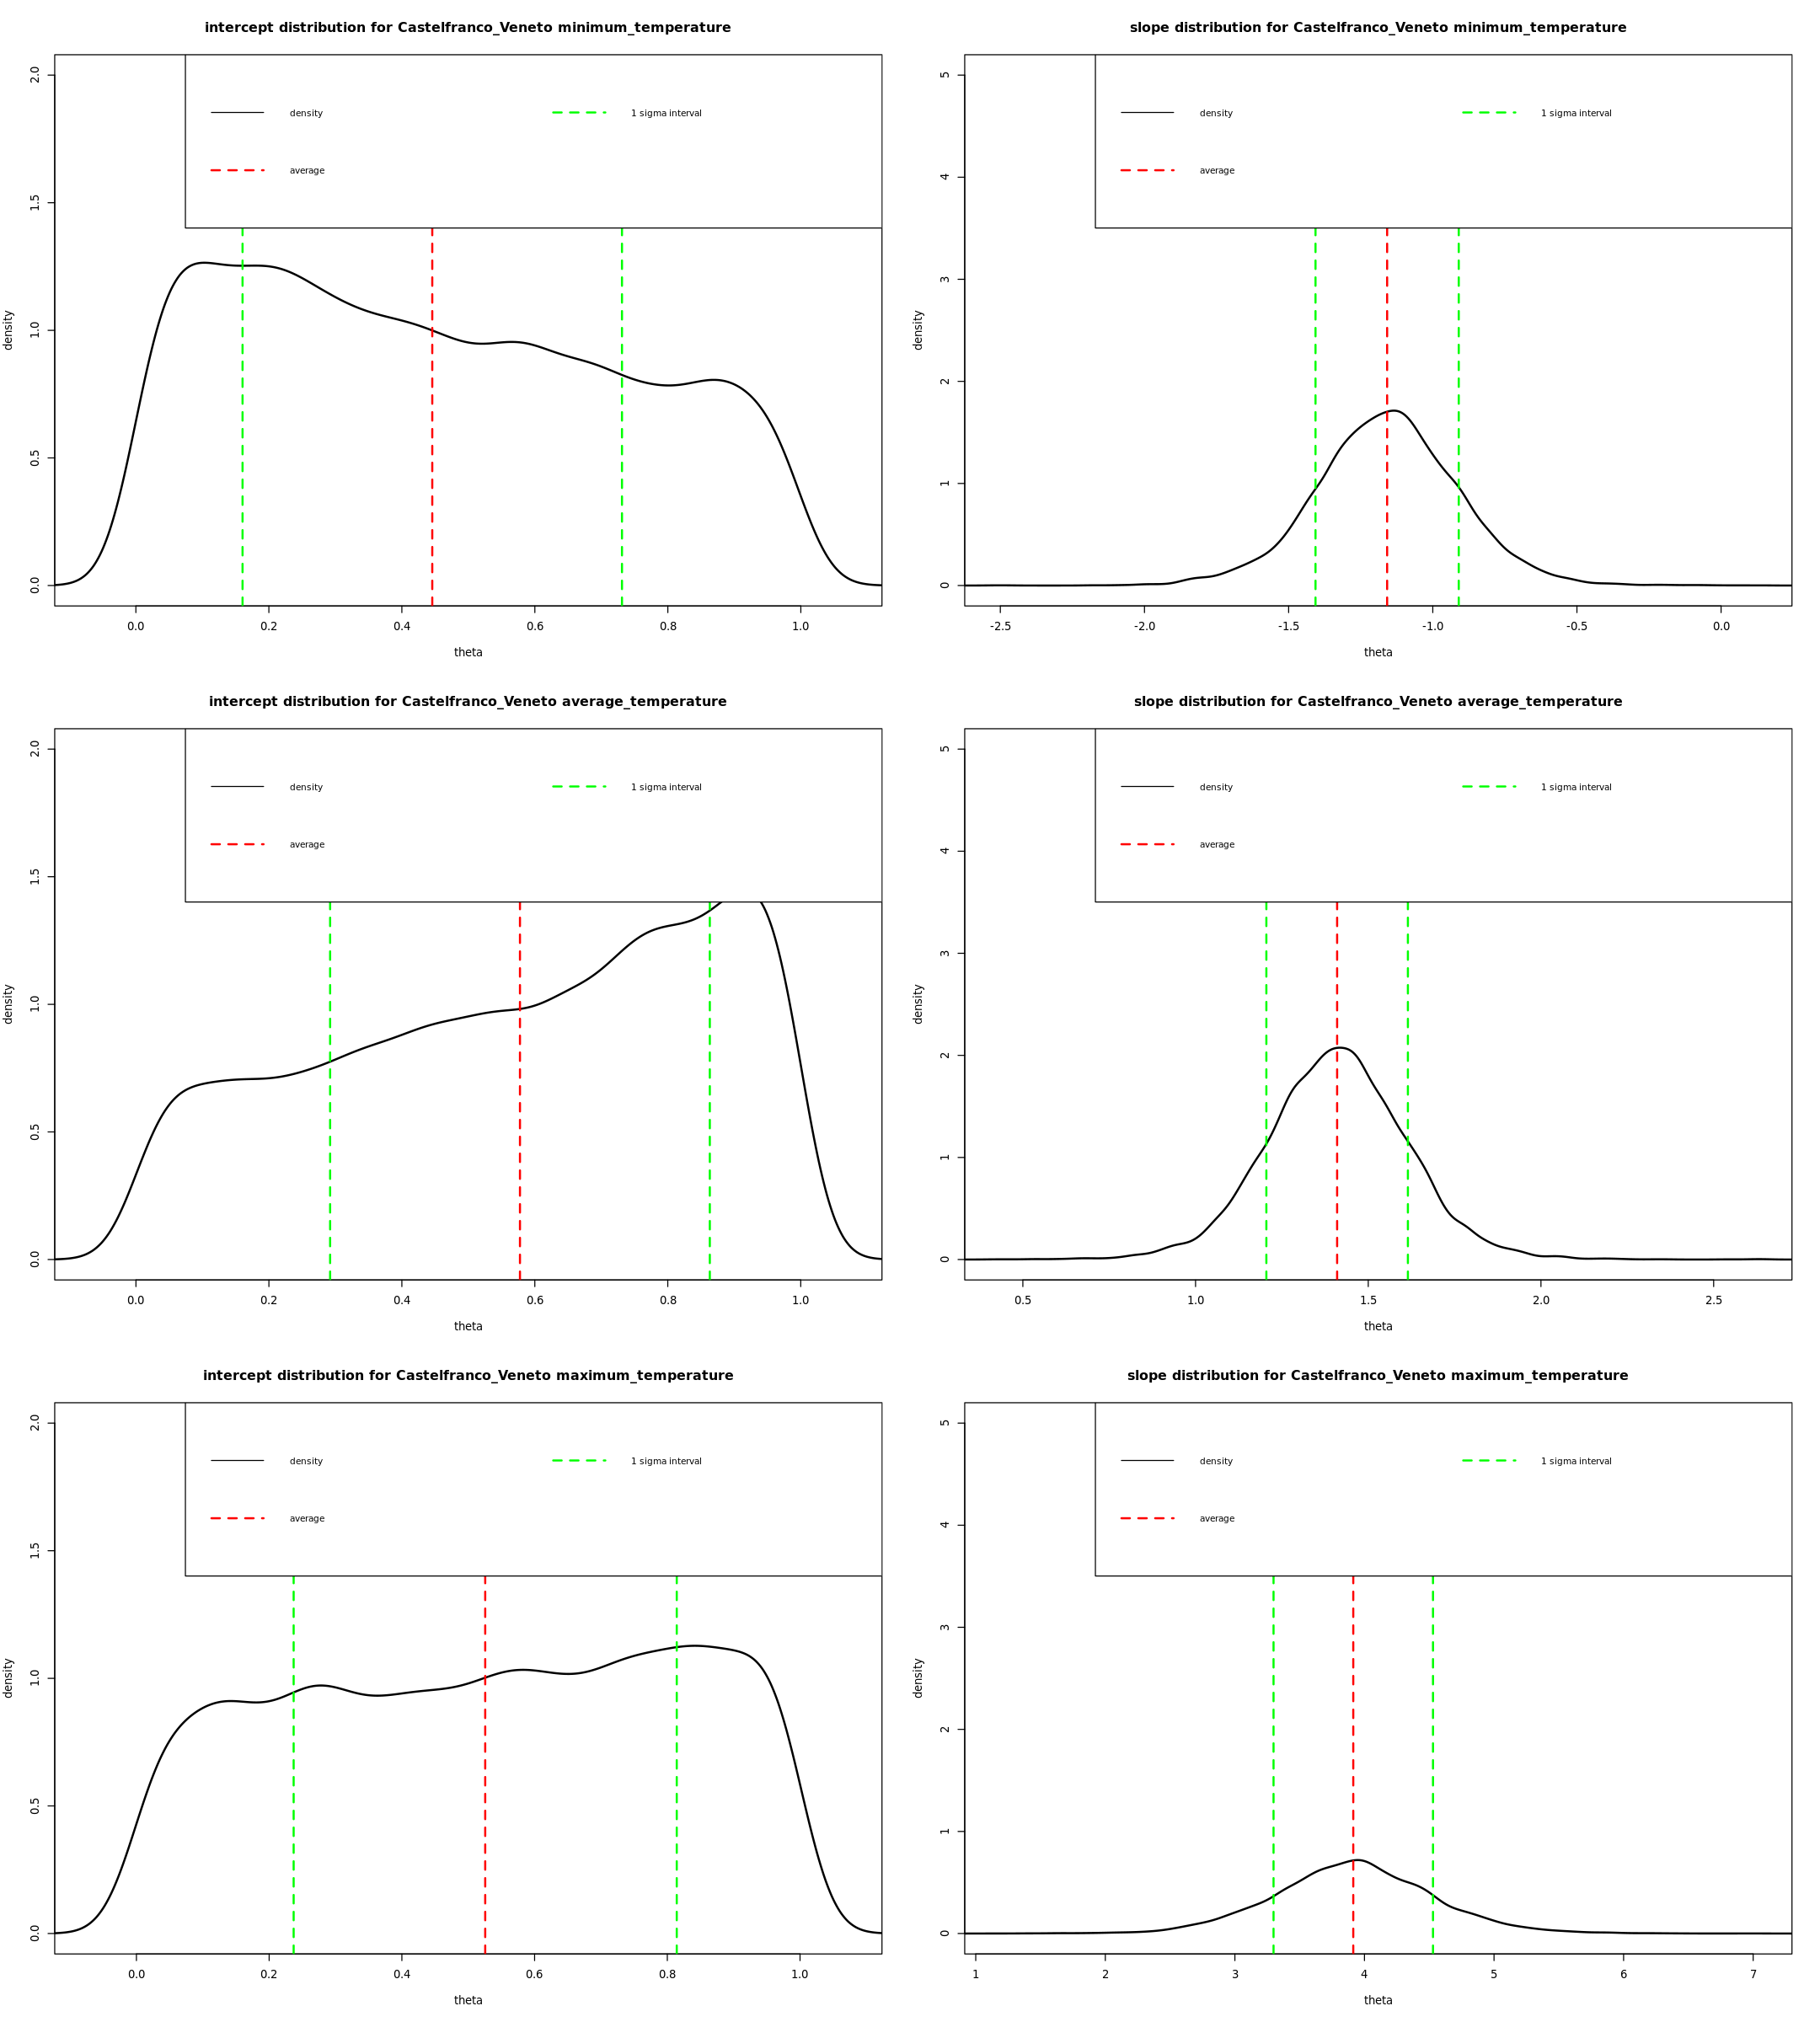

          temperature slope_mean  slope_sd intercept_mean intercept_sd
1 minimum_temperature -0.4217887 0.1145810      0.1155702   0.07175396
2 average_temperature  0.1535645 0.0333429      0.1541301   0.06874960
3 maximum_temperature  0.7488546 0.1561884      0.1326816   0.07252561


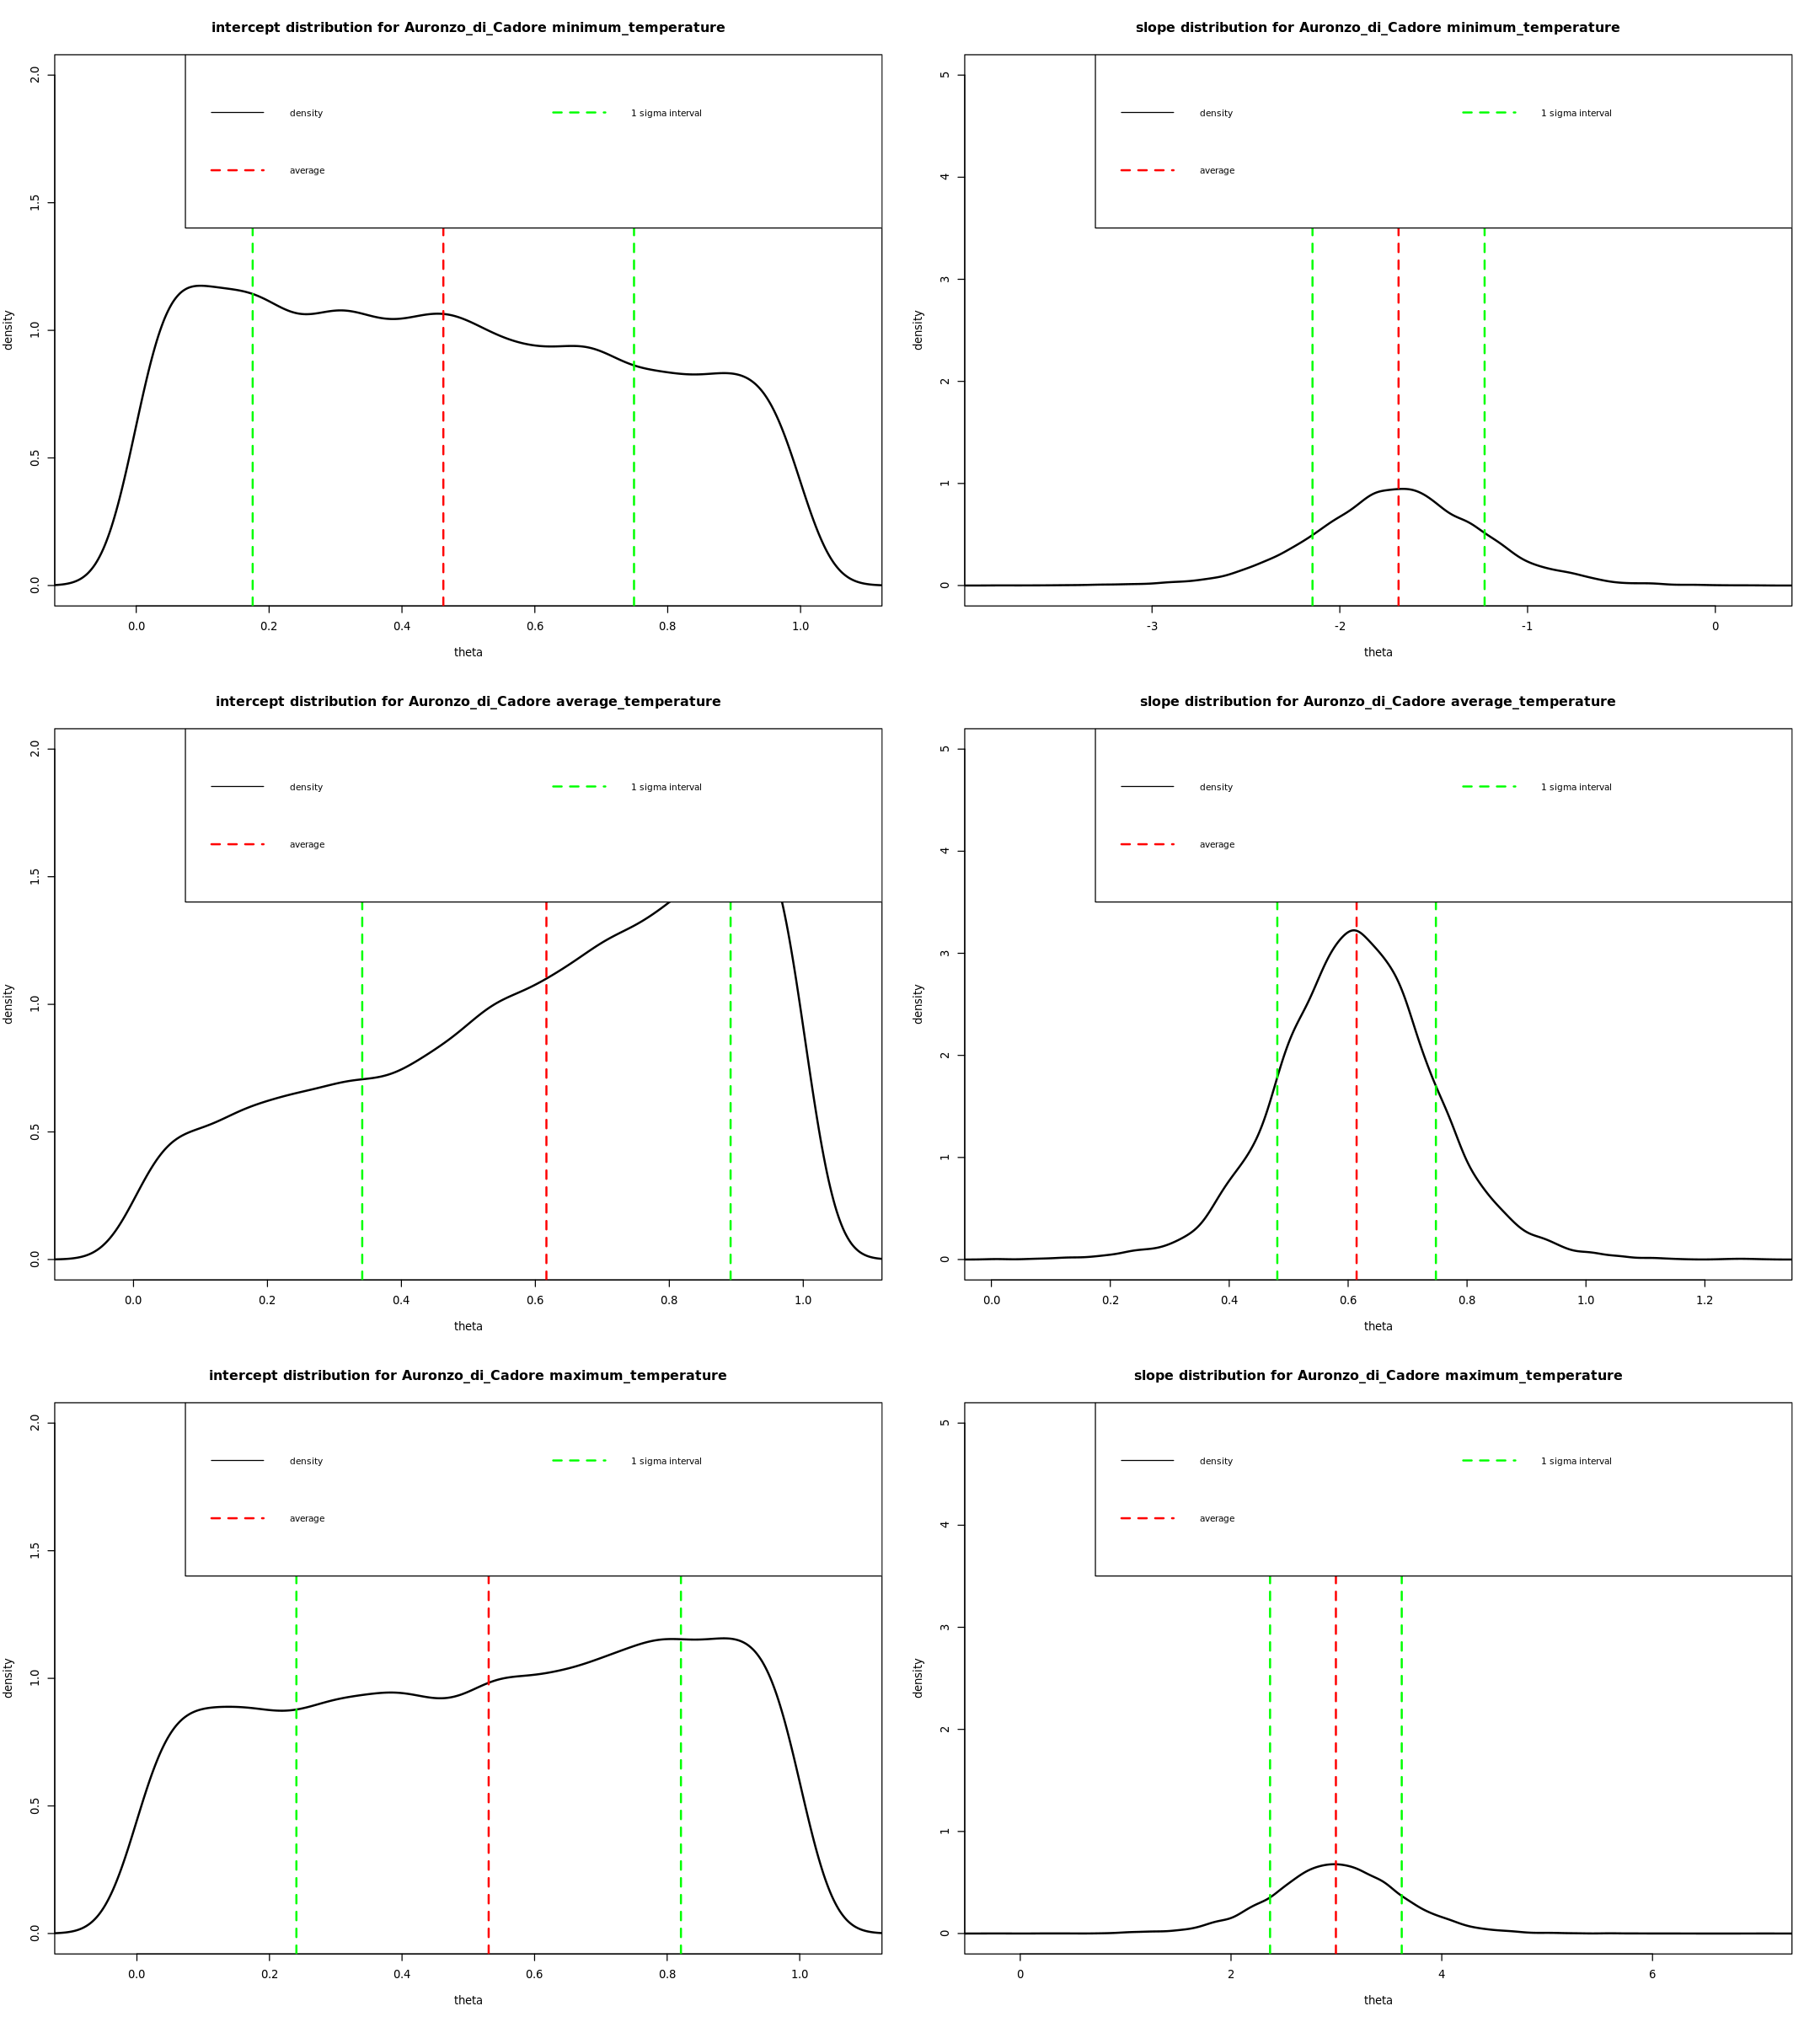

In [32]:
final_linear_regression_dataframe <- data.frame()
for (ln in location_names){
    temp <- my_final_linear_regression(ln)
    temp$location <- rep(c(ln), nrow(temp))
    final_linear_regression_dataframe %>% rbind(temp) -> final_linear_regression_dataframe }
final_linear_regression_dataframe %>% arrange(temperature) -> final_linear_regression_dataframe

In [33]:
final_linear_regression_dataframe

temperature         slope_mean slope_sd   intercept_mean intercept_sd
1  average_temperature  0.5120843 0.07721855 0.1349537      0.07224965  
2  average_temperature  0.5614853 0.09931839 0.1347444      0.07136541  
3  average_temperature  0.3524691 0.05122405 0.1444151      0.07139712  
4  average_temperature  0.1535645 0.03334290 0.1541301      0.06874960  
5  maximum_temperature  1.3653113 0.21404511 0.1296672      0.07257195  
6  maximum_temperature  1.6075887 0.31774228 0.1278317      0.07216875  
7  maximum_temperature  0.9784016 0.15383506 0.1313937      0.07216497  
8  maximum_temperature  0.7488546 0.15618835 0.1326816      0.07252561  
9  minimum_temperature -0.2906405 0.07354527 0.1161945      0.07248515  
10 minimum_temperature -0.4678071 0.13592941 0.1163435      0.07258241  
11 minimum_temperature -0.2895802 0.06210724 0.1114319      0.07132803  
12 minimum_temperature -0.4217887 0.11458100 0.1155702      0.07175396  
   location           
1  Porto_Tolle        
2  Roverchiara        
3  Castelfranco_Veneto
4  Auronzo_di_Cadore  
5  Porto_Tolle        
6  Roverchiara        
7  Castelfranco_Veneto
8  Auronzo_di_Cadore  
9  Porto_Tolle        
10 Roverchiara        
11 Castelfranco_Veneto
12 Auronzo_di_Cadore

In [34]:
final_linear_regression_dataframe %>% 
    group_by(temperature) %>% 
    summarize(slope_mean=mean(slope_mean), slope_sd=sqrt(sum(slope_sd))/n(),
              intercept_mean=mean(intercept_mean), intercept_sd=sqrt(sum(intercept_sd))/n()) -> minimal_final_linear_regression_dataframe
minimal_final_linear_regression_dataframe

temperature         slope_mean slope_sd  intercept_mean intercept_sd
1 average_temperature  0.3949008 0.1277458 0.1420608      0.1331732   
2 maximum_temperature  1.1750390 0.2293756 0.1303935      0.1344970   
3 minimum_temperature -0.3674541 0.1553550 0.1148850      0.1341989

The intercept distributions are still wide and lead to unprecise estimates. Better news come from the slope which, from the beginning, was stated to most meaningful parameter anyway. The slope estimates are slightly more precise, but still not optimal.

This might be due to the few points that are created when grouping by quadrennium.



------

## Conclusions

From the SNPA report, we know that:
- "*La stima aggiornata del rateo di variazione della temperatura media dal 1981 al 2019 è di +0,38 ± 0,05°C/10 anni*"
- "*Il rateo di variazione della temperatura massima (+0,42 ± 0,06°C/10 anni) è maggiore di quello della temperatura minima (+0,34 ± 0,04°C/10 anni)*"

On the other hand, the most precise estimates from this analysis (converted to the same units of measurement as the report) are the following:

In [35]:
minimal_final_linear_regression_dataframe

temperature         slope_mean slope_sd  intercept_mean intercept_sd
1 average_temperature  0.3949008 0.1277458 0.1420608      0.1331732   
2 maximum_temperature  1.1750390 0.2293756 0.1303935      0.1344970   
3 minimum_temperature -0.3674541 0.1553550 0.1148850      0.1341989

The biggest difference happens for the minimu_temperatures, which are increasing as well based on the report.

The estimates from this analysis are clearly higher than the ones from the report. This could be due to
- the amount of data available might not be matching exactly the one used in the report: in fact, as noticed in the first plot, two out of four of the locations have records for around 25 years, while the others have records for aroun 50 years. On the other hand, the SNPA report focusses only on the period of time between 1981 and 2019. Such a period is said to be chosen because "*si fa risalire all’inizio degli anni ’80 un cambiamento del trend di temperatura, quando ha inizio un periodo 
caratterizzato da un riscaldamento più marcato nel corso dell’ultimo secolo*"
- the limited number and climates of the locations in which data was collected: since three out of four of the locations are all in the same climate, a bias related to the most represented climate might be playing a role here. For example, the fact that all the data collecting locations have generally colder winterns could have caused a bias in the minimum temperature estimation (towards lower values). Also, the fact that three out of four of the locations fall within the Po Valley and have very hot summers could have caused a bias in the maximum temperature estimation (towards higher values).

------

## Part 3: Forecasts

Using the forecast R package [2], which provides methods and tools for displaying and analysing uni-variate time series, analyze the data. The library contains also the ARIMA (Autoregressive Integrated Moving Average), which allows to perform the equivalent of a linear regression in time series, where data is not stationary. Analyze your data and try to predict the evolution in the next years (average the data over multiple years, if needed).

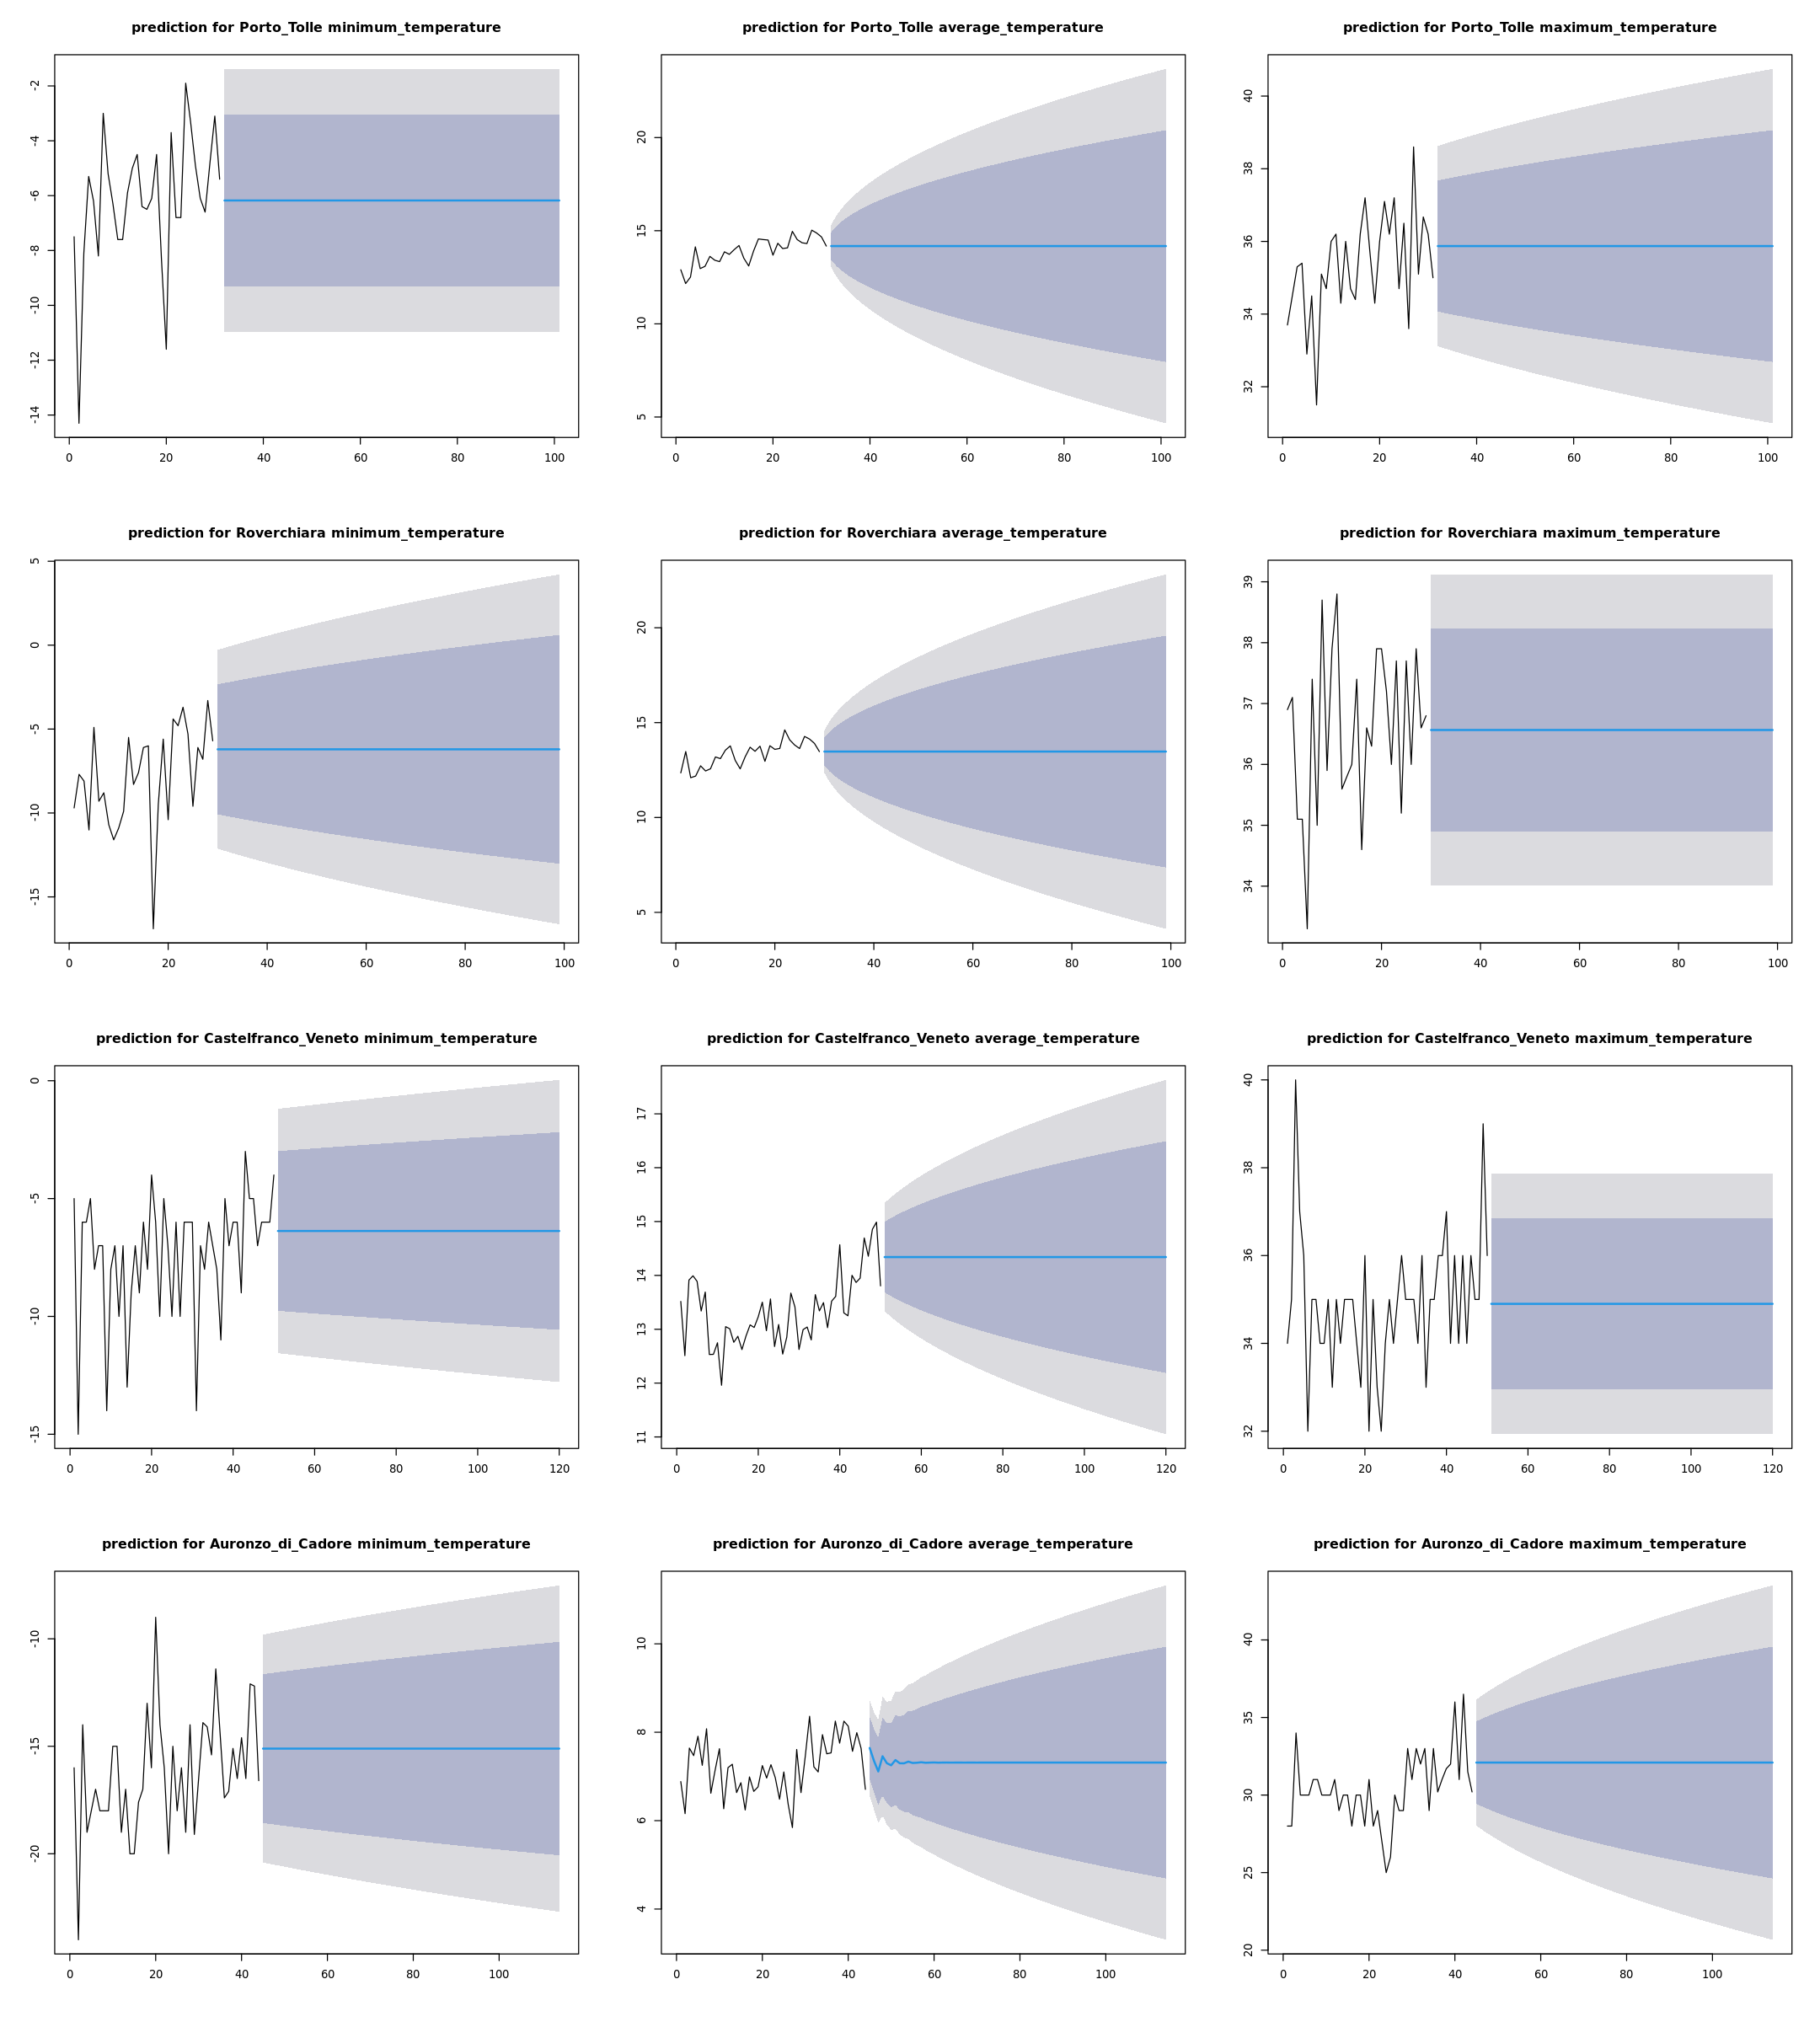

In [36]:
options(repr.plot.width=18, repr.plot.height=20)
par( mfrow=c(4,3) )
temperature_names <- c('minimum_temperature', 'average_temperature', 'maximum_temperature')

for (ln in location_names){
    for (temperature in temperature_names){
        input_df <- na.omit(get(paste(ln,'yearly',sep='_')))
        to_predict <- subset(input_df, select = c(temperature))[[1]]
        # I convert my data into a time-series object:
        ts_data <- ts(to_predict, frequency = 1)
        # I use auto.arima to automatically find the best ARIMA model
        model <- auto.arima(ts_data)
        # I can now make predictions for future time points (e.g. 70 years):
        forecast_result <- forecast(model, h = 70)
        plot(forecast_result, main=paste('prediction for', ln, temperature, sep=' ') )
    }}

------

## Bibliography

1. Rapporto sugli indicatori di impatto dei cambiamenti climaticil, 2021: \
https://www.snpambiente.it/wp-content/uploads/2021/06/Rapporto-SNPA-21_2021.pdf



2. R Forecast package: https://cran.r-project.org/web/packages/forecast/index.html